# Pakage Import

In [1]:
import ast
import time
import math
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, sqrt
from numpy import arccos, arctan2
from qiskit.visualization.bloch import Bloch
from qiskit import transpile, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector
from qiskit.circuit.library import RYGate, XGate

In [1140]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

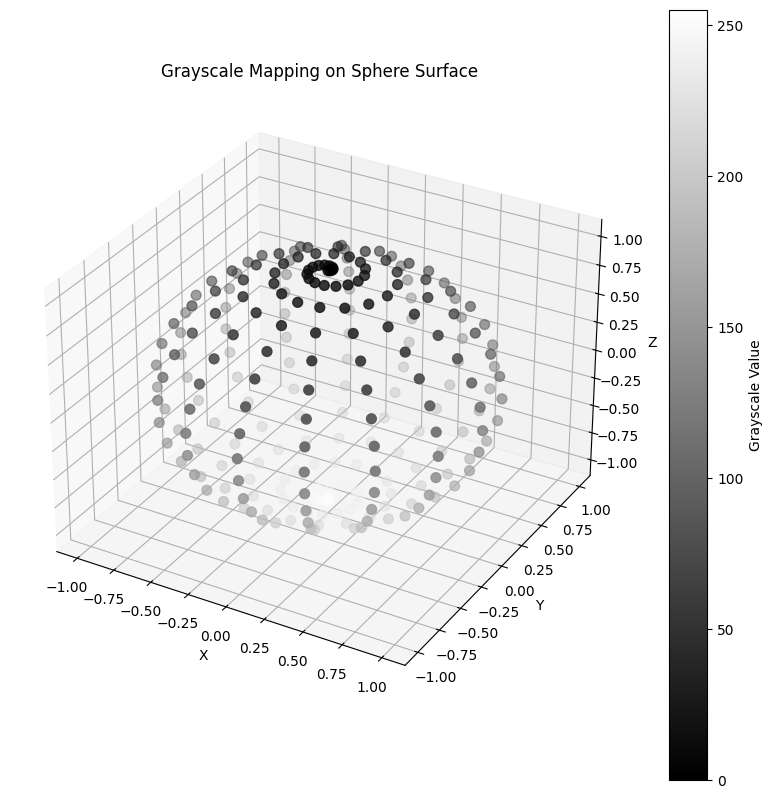

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 함수 정의: Grayscale 값을 구 좌표로 변환
def grayscale_to_sphere_coords(n, m):
    grayscale_values = np.linspace(0, 255, n * m)  # n*m 개의 grayscale 값
    x_vals, y_vals, z_vals = [], [], []

    for g in range(n * m):
        # 각 위도 및 경도 계산
        theta = np.pi * g / (n * m)  # 0에서 π까지
        phi = 2 * np.pi * (g % m) / m  # 0에서 2π까지
        # 북극과 남극을 정확히 매핑
        if g == 0:
            z = 1  # 북극점
            x = y = 0
        elif g == n * m - 1:
            z = -1  # 남극점
            x = y = 0
        else:
            z = np.cos(theta)
            r = np.sin(theta)
            x = r * np.cos(phi)
            y = r * np.sin(phi)

        x_vals.append(x)
        y_vals.append(y)
        z_vals.append(z)

    return np.array(x_vals), np.array(y_vals), np.array(z_vals), grayscale_values

# 위도(n)와 경도(m) 개수 설정
n = 16  # 위도 분할 수
m = 16  # 경도 분할 수

# Grayscale 값에 따라 좌표 계산
x_vals, y_vals, z_vals, grayscale_values = grayscale_to_sphere_coords(n, m)

# 시각화
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 좌표를 3D 산점도로 플롯
sc = ax.scatter(x_vals, y_vals, z_vals, c=grayscale_values, cmap='gray', s=50)

# 색상바 추가
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Grayscale Value')

# 축 설정 및 시각화
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Grayscale Mapping on Sphere Surface')
plt.show()


# Stereographic Projection Code

In [2]:
radius = []
k_list = []
size_list = []

def project(img, n):

    (row, col, _) = img
    x = row
    y = col
    z = 0
    r = round(np.sqrt(2**(2*n)/(8 * np.pi)),4)
    radius.append(r)
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

def get_2d_to_3d(point,r):
    [x, y, _] = point
    k = round(4*r**2 / (x**2 + y**2 + 4*r**2), 4)
    P = np.array([k * x, k * y, (1-2*k)*r ])
    size = np.sqrt(P[0]**2+P[1]**2+P[2]**2)
    resize = P*(1/size)
    k = k * (1/size)
    size_list.append(size)
    k_list.append(k)
    return resize

def generate_coordinates(input_tuple):
    # 입력된 튜플의 값을 2로 나눔
    x, y = input_tuple
    x /= 2
    y /= 2

    # 좌표 리스트 초기화
    coordinates = []

    # 음수부터 양수까지 좌표 생성
    for i in range(-int(x), int(x) + 1):
        for j in range(-int(x), int(y) + 1):
            if i != 0 and j != 0:
                # z 값은 항상 0
                coordinates.append(np.array([i, j, 0]))
    return coordinates

def generate_normal_coordinates(input_tuple):
    # 입력된 튜플의 값을 2로 나눔
    x, y = input_tuple
    x /= 2
    y /= 2

    # 좌표 리스트 초기화
    coordinates = []

    # 양수 값 좌표만 생성
    for i in range(0, 2 * int(x) + 1):
        for j in range(0, 2 * int(y) + 1):
            if i != 0 and j != 0:
                # z 값은 항상 0
                coordinates.append(np.array([i, j, 0]))
    return coordinates

def y_axis_reflection(point):
    return np.array([-point[0], point[1], point[2]])

def x_axis_reflection(point):
    return np.array([point[0], -point[1], point[2]])

def origin_reflection(point):
    return np.array([-point[0], -point[1], point[2]])


In [97]:
import numpy as np
import math

def Rotation(pixel, degree):
    rotation = degree * np.pi / 180
    degree = np.array([[np.cos(rotation), -np.sin(rotation),0],
                       [np.sin(rotation), np.cos(rotation),0],
                       [0,0,1]])
    rotated_pixel = []
    for i in range(len(pixel)):
        rotated_pixel.append(np.array(np.dot(degree, pixel[i])))
    return rotated_pixel

def Transition(pixel,a,b):
    list_= []
    for i in range(len(pixel)):
        x_ = pixel[i][0] 
        x_ += a
        y_ = pixel[i][1]
        y_ +=  b
        _ = [x_,y_,0]
        list_.append(_)
        arr = np.array(list_)
    return arr


def preprocess_image(image, rot=None, tra=None):
    """이미지 전처리 및 색상 정보를 구 좌표로 매핑하여 양자 회로 매개변수를 생성."""
    # Convert image to grayscale and calculate mean value per pixel
    img_mean = np.mean(image, axis=2, dtype=np.uint8)
    input_tuple = img_mean.shape

    # Generate normal coordinates
    Q = generate_normal_coordinates(input_tuple)

    # Calculate required number of qubits for coordinate representation
    n = int(np.ceil(math.log(input_tuple[0], 2)))

    # Project each coordinate to sphere
    P = []
    for i in range(len(Q)):
        sphere = project(Q[i], n)
        P.append(sphere)


    # Calculate phi and theta for spherical coordinates
    phis = []
    thetas = []
    for i in range(len(P)):
        phi = np.arctan2(P[i][1], P[i][0])
        if phi < 0:
            phi = (2 * np.pi - abs(phi)) / 4
        else:
            phi = phi / 4
        phis.append(phi)
        theta = np.arccos(P[i][2]) / 2
        thetas.append(theta)

    if rot is not None:
        Q = Rotation(Q, rot)   
        P_rot = []
        k_list = []
        size_list=[]
        for i in Q:
            sphere = project(i,n)
            P_rot.append(sphere)
        phis_rot = []
        for i in range(len(P_rot)):
            phi_rot = np.arctan2(P_rot[i][1], P_rot[i][0])
            if phi_rot <0:
                phi_rot = (6.283-abs(phi_rot))/4
                phis_rot.append(phi_rot)
            else:
                phi_rot = phi_rot/4
                phis_rot.append(phi_rot)
        phis = [a + b for a, b in zip(phis, phis_rot)]


    if tra is not None:
        Q = Transition(Q, tra[0], tra[1])
        P_tra = []
        size_list=  []
        k_list = []
        radius = []
        for i in Q:
            sphere = project(i,n)
            P_tra.append(sphere)
        phis_tra = []
        for i in range(len(P_tra)):
            phi_tra = np.arctan2(P_tra[i][1], P_tra[i][0])
            if phi_tra <0:
                phi_tra = (6.283-abs(phi_tra))/4
                phis_tra.append(phi_tra)
            else:
                phi_tra = phi_tra/4
                phis_tra.append(phi_tra)
        thetas_tra = []
        for i in range(len(P_tra)):
            theta_tra = np.arccos(P_tra[i][2])/2
            thetas_tra.append(theta_tra)
        phis = [a - b for a, b in zip(phis_tra, phis)]
        thetas = [a - b for a, b in zip(thetas_tra, thetas)]

    # Flatten the image for further processing
    input_im = image.copy().flatten()
    coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

    # Calculate required bits for width and height
    w_bits = int(np.ceil(math.log(image.shape[1], 2)))
    h_bits = int(np.ceil(math.log(image.shape[0], 2)))
    if not w_bits:
        w_bits = 1
    if not h_bits:
        h_bits = 1

    # Determine the number of bits required for index
    num_ind_bits = int(h_bits + w_bits)
    if not num_ind_bits:
        num_ind_bits = 1

    # Initialize lists to store theta and phi values
    origin_color_theta = []
    origin_color_phi = []
    color_theta = []
    color_phi = []

    # Flatten image and map pixel colors to spherical coordinates
    len_image = image.reshape(-1, 3)
    
    # Process each pixel's RGB values
    for i in range(len(len_image)):
        x, y, z = len_image[i]
        max_value = max(x, y, z)
        min_value = min(x, y, z)

        if max_value + min_value < 255:
            if x >= y >= z:  # (m, k, i)
                theta = (x+z)*np.pi/510+np.pi/1020-(np.pi/510) * (z+1)/(np.floor((x+z)/2)+1)
                phi = (y - z) * np.pi / (3 * (x - z))
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif z < x < y:  # (m-k, m, i)
                theta = (z+y)*np.pi/510+np.pi/1020-(np.pi/510) * (z+1)/(np.floor((z+y)/2)+1)
                phi = (y - x) * np.pi / (3 * (y - z)) + np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif x <= z <= y:  # (i, m, k)
                theta = (y+x)*np.pi/510+np.pi/1020-(np.pi/510) * (x+1)/(np.floor((y+x)/2)+1)
                phi = (z - x) * np.pi / (3 * (y - x)) + 2 * np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif z > y > x:  # (i, m-k, m)
                theta = (x+z)*np.pi/510+np.pi/1020-(np.pi/510) * (x+1)/(np.floor((x+z)/2)+1)
                phi = (z - y ) * np.pi / (3 * (z - x)) + np.pi
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif y <= x <= z:  # (k, i, m)
                theta = (z+y)*np.pi/510+np.pi/1020-(np.pi/510) * (y+1)/(np.floor((z+y)/2)+1)
                phi = (x - y) * np.pi / (3 * (z - y)) + 4 * np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif y <= z <= x:  # (m, i, m-k)
                theta = (x+y)*np.pi/510+np.pi/1020-(np.pi/510) * (y+1)/(np.floor((y+x)/2)+1)
                phi = (x - z) * np.pi / (3 * (x - y)) + 5 * np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)

        elif max_value + min_value > 255: # Bloch Sphere's lower part
            if x >= y >= z:  # (m, k, i)
                theta = (x+z)*np.pi/510-np.pi/1020+(np.pi/510) * (z+1)/(np.floor((510-x-z)/2)+1)
                phi = (y - z) * np.pi / (3 * (x - z))
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif z < x < y:  # (m-k, m, i)
                theta = (z+y)*np.pi/510-np.pi/1020+(np.pi/510) * (z+1)/(np.floor((510-z-y)/2)+1)
                phi = (y - x) * np.pi / (3 * (y - z)) + np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif x <= z <= y:  # (i, m, k)
                theta = (x+y)*np.pi/510-np.pi/1020+(np.pi/510) * (x+1)/(np.floor((510-y-x)/2)+1)
                phi = (z - x) * np.pi / (3 * (y - x)) + 2 * np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif z > y > x:  # (i, m-k, m)
                theta = (z+x)*np.pi/510-np.pi/1020+(np.pi/510) * (x+1)/(np.floor((510-x-z)/2)+1)
                phi = (z - y ) * np.pi / (3 * (z - x)) + np.pi
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif y <= x <= z:  # (k, i, m)
                theta = (y+z)*np.pi/510-np.pi/1020+(np.pi/510) * (y+1)/(np.floor((510-z-y)/2)+1)
                phi = (x - y) * np.pi / (3 * (z - y)) + 4 * np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif y <= z <= x:  # (m, i, m-k)
                theta = (x+y)*np.pi/510-np.pi/1020+(np.pi/510) * (y+1)/(np.floor((510-y-x)/2)+1)
                phi = (x - z ) * np.pi / (3 * (x - y)) + 5 * np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)

        elif max_value + min_value ==255: #equator
            if x >= y >= z:  # (m, k, i)
                theta = np.pi/2+((-1)**z)*np.pi/1020* z/127
                phi = (y - z) * np.pi / (3 * (x - z))
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif z < x < y:  # (m-k, m, i)
                theta = np.pi/2+((-1)**z)*np.pi/1020* z/127
                phi = (y - x) * np.pi / (3 * (y - z)) + np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif x <= z <= y:  # (i, m, k)
                theta = np.pi/2+((-1)**x)*np.pi/1020* x/127
                phi = (z - x) * np.pi / (3 * (y - x)) + 2 * np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif z > y > x:  # (i, m-k, m)
                theta = np.pi/2+((-1)**x)*np.pi/1020* x/127
                phi = (z - y) * np.pi / (3 * (z - x)) + np.pi
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif y <= x <= z:  # (k, i, m)
                theta = np.pi/2+((-1)**y)*np.pi/1020* y/127
                phi = (x - y) * np.pi / (3 * (z - y)) + 4 * np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)
            elif y <= z <= x:  # (m, i, m-k)
                theta = np.pi/2+((-1)**y)*np.pi/1020* y/127
                phi = (x - z) * np.pi / (3 * (x - y)) + 5 * np.pi / 3
                theta = np.mod(theta, 2*np.pi)
                origin_color_theta.append(theta)
                color_theta.append(theta/2)


        # Adjust theta and phi values to be within [0, 2*pi]
        #theta = np.mod(theta, 2*np.pi)

        phi = np.mod(phi, 2 * np.pi)

        # Convert negative phi to positive
        if phi < 0:
            phi += 2 * np.pi

        #origin_color_theta.append(theta)
        origin_color_phi.append(phi)

        #color_theta.append(theta / 2)
        color_phi.append(phi / 4)

    return {
        "P": P,
        "Q": Q,
        "n": n,
        "phis": phis,
        "thetas": thetas,
        "input_im": input_im,
        "coord_q_num": coord_q_num,
        "w_bits": w_bits,
        "h_bits": h_bits,
        "num_ind_bits": num_ind_bits,
        "origin_color_theta": origin_color_theta,
        "origin_color_phi": origin_color_phi,
        "color_theta": color_theta,
        "color_phi": color_phi
    }

def generate_normal_coordinates(input_tuple):
    # 입력된 튜플의 값을 2로 나눔
    x, y = input_tuple
    x /= 2
    y /= 2

    # 좌표 리스트 초기화
    coordinates = []

    # 양수 값 좌표만 생성
    for i in range(0, 2 * int(x) + 1):
        for j in range(0, 2 * int(y) + 1):
            if i != 0 and j != 0:
                # z 값은 항상 0
                coordinates.append(np.array([i, j, 0]))
    return coordinates

radius = []
k_list = []
size_list = []

def project(img, n):

    (row, col, _) = img
    x = row
    y = col
    z = 0
    r = round(np.sqrt(2**(2*n)/(8 * np.pi)),4)
    radius.append(r)
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

def get_2d_to_3d(point,r):
    [x, y, _] = point
    k = round(4*r**2 / (x**2 + y**2 + 4*r**2), 4)
    P = np.array([k * x, k * y, (1-2*k)*r ])
    size = np.sqrt(P[0]**2+P[1]**2+P[2]**2)
    resize = P*(1/size)
    k = k * (1/size)
    size_list.append(size)
    k_list.append(k)
    return resize

In [9]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error


def create_and_simulate_quantum_circuit(image, iter, simul):
    global qc_image
    """
    이미지 데이터를 입력으로 받아 양자 회로를 생성하고 시뮬레이션합니다.
    
    Args:
        image (np.ndarray): RGB 이미지 데이터 (H x W x 3 형식)

    Returns:
        dict: 양자 회로 시뮬레이션 결과의 측정 횟수(counts)
    """
    # 전처리 단계 수행
    params = preprocess_image(image)

    # 양자 레지스터 크기 설정
    w_bits = params["w_bits"]
    h_bits = params["h_bits"]
    num_ind_bits = params["num_ind_bits"]
    phis = params["phis"]
    thetas = params["thetas"]
    color_phi = params["color_phi"]
    color_theta = params["color_theta"]
    
    # 양자 회로 생성
    O = QuantumRegister(w_bits + h_bits, 'q2')
    c = QuantumRegister(1, 'q1')
    p = QuantumRegister(1, 'q3')
    color = QuantumRegister(1, "q4")
    cr = ClassicalRegister(O.size + c.size + p.size + color.size, "classical")
    num_bits = O.size + c.size + p.size + color.size
    qc_image = QuantumCircuit(c, O, p, color, cr)

    # 초기화
    qc_image.id(c)
    qc_image.h(O)
    qc_image.h(p)
    qc_image.h(color)

    # 제어 큐비트 리스트
    controls_ = [q for q in O] + [q for q in p] + [q for q in color]

    # 색상 정보 매핑 및 회로 구성
    for i, (phi, theta) in enumerate(zip(phis, thetas)):
        qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)

        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

        qc_image.barrier()

        # 각도 조절
        for coord_or_intns in (0, 1):
            if not coord_or_intns:  # p = 1, theta
                qc_image.mcry(theta=2 * theta, q_controls=controls_, q_target=c[0])
                qc_image.barrier()
            else:
                qc_image.x(p)  # p = 0, phi
                qc_image.barrier()
                qc_image.mcry(theta=2 * phi, q_controls=controls_, q_target=c[0])
                if i != len(thetas) - 1:
                    qc_image.x(p)
                    qc_image.barrier()

        qc_image.barrier()

        if i != len(thetas) - 1:
            for k, qub_ind in enumerate(qubit_index_bin):
                if int(qub_ind):
                    qc_image.x(O[k])

    # 색상 정보 매핑 추가
    qc_image.x(p)
    qc_image.x(O)
    qc_image.x(color)
    qc_image.barrier()
    
    for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
        qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)

        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
        qc_image.barrier()

        for coord_or_intns in (0, 1):
            if not coord_or_intns:  # p = 1, theta
                qc_image.mcry(theta=2 * theta, q_controls=controls_, q_target=c[0])
                qc_image.barrier()
            else:
                qc_image.x(p)  # p = 0, phi
                qc_image.barrier()
                qc_image.mcry(theta=2 * phi, q_controls=controls_, q_target=c[0])
                if i != len(thetas) - 1:
                    qc_image.x(p)
                    qc_image.barrier()

        if i != len(thetas) - 1:
            for k, qub_ind in enumerate(qubit_index_bin):
                if int(qub_ind):
                    qc_image.x(O[k])

    qc_image.x(color)
    qc_image.x(p)
    qc_image.x(O)
    qc_image.barrier()

    # 측정
    qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

    # 시뮬레이션 수행
    if simul == 'simul':
        aer_sim = Aer.get_backend('aer_simulator')
        t_qc = transpile(qc_image, aer_sim)
        job = aer_sim.run(t_qc, shots=iter)
    elif simul == 'ionq':
        ionq_sim = provider.get_backend("ionq_simulator")
        t_qc = transpile(qc_image, ionq_sim)
        job = ionq_sim.run(t_qc, shots=iter)
    result = job.result()
    counts = result.get_counts()

    def add_missing_states(counts, num_bits):
        # 모든 가능한 상태 생성
        all_possible_states = {format(i, f'0{num_bits}b') for i in range(2**num_bits)}
        
        # 현재 측정된 상태에서 누락된 상태 찾기
        missing_states = all_possible_states - set(counts.keys())
        
        # 누락된 상태를 측정 결과에 추가
        for state in missing_states:
            counts[state] = 0
            
        return counts

    return add_missing_states(counts,num_bits)
    

def reconstruct_values(counts):

    pixel_theta = []
    pixel_phi = []

    pixel_color_theta = []
    pixel_color_phi = []
    
    pixel_theta_recon = []
    pixel_phi_recon = []

    pixel_color_theta_recon = []
    pixel_color_phi_recon = []

    for i in range(0, int(len(counts) / 8)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            bin_coord = key[1:-2]
            angle_decision = int(key[-2])
            switch = int(key[-1]) # switch = 1, position, and switch = 0, color
            int_coord = int(bin_coord, 2)
            if switch == 1:
                if int_coord == i and angle_decision == 1:
                    pixel_theta.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_phi.append((state,bin_coord, amount))
            elif switch == 0:
                if int_coord == i and angle_decision == 1:
                    pixel_color_theta.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_color_phi.append((state,bin_coord, amount))

    # position
    # ======================== phi ====================================
    phi_result_dict_ionq = {}
    for state in pixel_phi:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict_ionq:
            phi_result_dict_ionq[key] += value  
        else:
            phi_result_dict_ionq[key] = value  

    phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
    #print(phi_result_list)

    phi_state_0_ionq = []
    for state, phi, amount in pixel_phi:
        if not int(state):
            phi_state_0_ionq.append((phi, amount))

    for i in range(0, int(len(counts) / 8)):
        try:
            phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
            pixel_phi_recon.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict_ionq = {}
    for state in pixel_theta:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict_ionq:
            theta_result_dict_ionq[key] += value  
        else:
            theta_result_dict_ionq[key] = value  

    theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]

    theta_state_0_ionq = []
    for state, theta, amount in pixel_theta:
        if not int(state):
            theta_state_0_ionq.append((theta, amount))

    for i in range(0, int(len(counts) / 8)):
        try:
            theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
            pixel_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # color
    # ======================== phi ====================================
    color_phi_result_dict_ionq = {}
    for state in pixel_color_phi:
        key = state[1]
        value = state[2] 
        if key in color_phi_result_dict_ionq:
            color_phi_result_dict_ionq[key] += value  
        else:
            color_phi_result_dict_ionq[key] = value  

    color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
    #print(color_phi_result_list)


    color_phi_state_0_ionq = []
    for state, phi, amount in pixel_color_phi:
        if not int(state):
            color_phi_state_0_ionq.append((phi, amount))

    for i in range(0, int(len(counts) / 8)):
        try:
            phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
            pixel_color_phi_recon.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    color_theta_result_dict_ionq = {}
    for state in pixel_color_theta:
        key = state[1]
        value = state[2] 
        if key in color_theta_result_dict_ionq:
            color_theta_result_dict_ionq[key] += value  
        else:
            color_theta_result_dict_ionq[key] = value  

    color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

    color_theta_state_0_ionq = []

    for state, theta, amount in pixel_color_theta:
        if not int(state):
            color_theta_state_0_ionq.append((theta, amount))

    for i in range(0, int(len(counts) / 8)):
        try:
            theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
            pixel_color_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    return pixel_theta_recon, pixel_phi_recon, list(reversed(pixel_color_theta_recon)), list(reversed(pixel_color_phi_recon))

def color_errors(original_values, recon_values):
    mse = mean_squared_error(original_values, recon_values)
    mae = mean_absolute_error(original_values, recon_values)
    print("MSE = ", mse, "MAE =", mae)
    return mse, mae


def position_error(pixel_theta_recon, pixel_phi_recon, Q):
    recon_pixel_ionq = []
    for i in range(0, int(len(pixel_theta_recon))):
        x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        z = np.cos(pixel_theta_recon[i])
        recon_pixel_ionq.append(np.array([x, y, z]))

    back_recon_pixel_ionq = []
    for i in range(0, int(len(pixel_theta_recon))):
        k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
        k /= size_list[i]
        X = recon_pixel_ionq[i][0] / k
        Y = recon_pixel_ionq[i][1] / k
        back_P = np.array([X, Y, 0])
        back_recon_pixel_ionq.append(back_P)

    back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))
    #print("Reconstructed pixel =", back_recon_pixel_ionq)

    x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
    y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    x_Q = [point[0] for point in Q]
    y_Q = [point[1] for point in Q]

    error = []
    for i in range(0, int(len(pixel_theta_recon))):
        del_x = x_Q[i] - x_values_ionq[i]
        del_y = y_Q[i] - y_values_ionq[i]
        err = np.sqrt(del_x**2 + del_y**2)
        error.append(err)
    posmse = sum(error)/int(len(pixel_theta_recon))
    print("Error =", sum(error)/int(len(pixel_theta_recon)))
    return posmse


In [10]:
import numpy as np

def reconstruct_quantum_circuit_results(counts, P, Q, size_list, radius):
    # Initialize lists for reconstructed angles and colors
    pixel_theta_recon_ionq = []
    pixel_phi_recon_ionq = []
    pixel_color_theta_recon_ionq = []
    pixel_color_phi_recon_ionq = []

    pixel_theta_ionq = []
    pixel_phi_ionq = []
    pixel_color_theta_ionq = []
    pixel_color_phi_ionq = []

    # Process counts to extract necessary information
    for i in range(len(P)):
        for key, amount in counts.items():
            state = key[0]
            bin_coord = key[1:-2]
            angle_decision = int(key[-2])
            switch = int(key[-1])  # switch = 1: position, switch = 0: color
            int_coord = int(bin_coord, 2)

            if switch == 1:  # Position data
                if int_coord == i:
                    if angle_decision == 1:
                        pixel_theta_ionq.append((state, bin_coord, amount))
                    else:
                        pixel_phi_ionq.append((state, bin_coord, amount))
            else:  # Color data
                if int_coord == i:
                    if angle_decision == 1:
                        pixel_color_theta_ionq.append((state, bin_coord, amount))
                    else:
                        pixel_color_phi_ionq.append((state, bin_coord, amount))

    # Helper function to compute reconstructed angles
    def compute_reconstructed_angles(pixel_data, result_list):
        state_0 = [(phi, amount) for state, phi, amount in pixel_data if not int(state)]
        for i in range(len(P)):
            try:
                angle = np.arccos((state_0[i][1] / result_list[i][1])**(1/2))
                yield angle
            except ZeroDivisionError:
                print("ZeroDivisionError")
                yield 0

    # Compute phi and theta for position and color
    def compute_reconstructions(pixel_phi_ionq, pixel_theta_ionq, pixel_color_phi_ionq, pixel_color_theta_ionq):
        # Create dictionaries to hold aggregated values
        phi_result_dict_ionq = {}
        theta_result_dict_ionq = {}
        color_phi_result_dict_ionq = {}
        color_theta_result_dict_ionq = {}

        for state in pixel_phi_ionq:
            key, value = state[1], state[2]
            phi_result_dict_ionq[key] = phi_result_dict_ionq.get(key, 0) + value

        for state in pixel_theta_ionq:
            key, value = state[1], state[2]
            theta_result_dict_ionq[key] = theta_result_dict_ionq.get(key, 0) + value

        for state in pixel_color_phi_ionq:
            key, value = state[1], state[2]
            color_phi_result_dict_ionq[key] = color_phi_result_dict_ionq.get(key, 0) + value

        for state in pixel_color_theta_ionq:
            key, value = state[1], state[2]
            color_theta_result_dict_ionq[key] = color_theta_result_dict_ionq.get(key, 0) + value

        # Convert dictionaries to lists
        phi_result_list_ionq = list(phi_result_dict_ionq.items())
        theta_result_list_ionq = list(theta_result_dict_ionq.items())
        color_phi_result_list_ionq = list(color_phi_result_dict_ionq.items())
        color_theta_result_list_ionq = list(color_theta_result_dict_ionq.items())

        # Reconstruct angles for position
        for phi in compute_reconstructed_angles(pixel_phi_ionq, phi_result_list_ionq):
            pixel_phi_recon_ionq.append(phi * 4)

        for theta in compute_reconstructed_angles(pixel_theta_ionq, theta_result_list_ionq):
            pixel_theta_recon_ionq.append(theta * 2)

        # Reconstruct angles for color
        for phi in compute_reconstructed_angles(pixel_color_phi_ionq, color_phi_result_list_ionq):
            pixel_color_phi_recon_ionq.append(phi * 4)

        for theta in compute_reconstructed_angles(pixel_color_theta_ionq, color_theta_result_list_ionq):
            pixel_color_theta_recon_ionq.append(theta * 2)

    compute_reconstructions(pixel_phi_ionq, pixel_theta_ionq, pixel_color_phi_ionq, pixel_color_theta_ionq)

    # Reconstruct color
    def reconstruct_colors():
        color_recon_ionq = []
        for i in range(len(pixel_color_phi_recon_ionq)):
            phi_deg = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi, -1)
            theta_deg = round(pixel_color_theta_recon_ionq[i] * 180 / np.pi, -1)
            n_recon = theta_deg * 510 / 180

            if phi_deg <= 60.0:
                k_recon = phi_deg * 3 * n_recon / 180
                color_recon_ionq.append(np.array([n_recon, k_recon, 0]))
            elif 60.0 < phi_deg <= 120.0:
                k_recon = (phi_deg - 60.0) * 3 * n_recon / 180
                color_recon_ionq.append(np.array([n_recon - k_recon, n_recon, 0]))
            elif 120.0 < phi_deg <= 180.0:
                k_recon = (phi_deg - 120.0) * 3 * n_recon / 180
                color_recon_ionq.append(np.array([0, n_recon, k_recon]))
            elif 180.0 < phi_deg <= 240.0:
                k_recon = (phi_deg - 180.0) * 3 * n_recon / 180
                color_recon_ionq.append(np.array([0, n_recon - k_recon, n_recon]))
            elif 240.0 < phi_deg <= 300.0:
                k_recon = (phi_deg - 240.0) * 3 * n_recon / 180
                color_recon_ionq.append(np.array([k_recon, 0, n_recon]))
            elif 300.0 < phi_deg <= 360.0:
                k_recon = (phi_deg - 300.0) * 3 * n_recon / 180
                color_recon_ionq.append(np.array([n_recon, 0, n_recon - k_recon]))

        return list(reversed(color_recon_ionq))

    color_recon_ionq = reconstruct_colors()
    print("Reconstructed color =", color_recon_ionq)

    # Visualization and error calculation
    def visualize_and_calculate_error():
        recon_pixel_ionq = []
        for i in range(len(P)):
            x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
            y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
            z = np.cos(pixel_theta_recon_ionq[i])
            recon_pixel_ionq.append(np.array([x, y, z]))

        back_recon_pixel_ionq = []
        for i in range(len(P)):
            k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
            k /= size_list[i]
            X = recon_pixel_ionq[i][0] / k
            Y = recon_pixel_ionq[i][1] / k
            back_P = np.array([X, Y, 0])
            back_recon_pixel_ionq.append(back_P)

        back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))
        print("Reconstructed pixel =", back_recon_pixel_ionq)

        x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
        y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

        x_Q = [point[0] for point in Q]
        y_Q = [point[1] for point in Q]

        error_ionq = []
        for i in range(len(Q)):
            del_x = x_Q[i] - x_values_ionq[i]
            del_y = y_Q[i] - y_values_ionq[i]
            err_ionq = np.sqrt(del_x**2 + del_y**2)
            error_ionq.append(err_ionq)

        print("Error =", error_ionq)


    return visualize_and_calculate_error()

# Example usage
# counts = ...  # Provide your counts dictionary
# P = ...       # Provide your P data
# Q = ...       # Provide your Q data
# size_list = ...  # Provide your size list
# radius = ...     # Provide your radius
# reconstruct_quantum_circuit_results(counts, P, Q, size_list, radius)


# Image

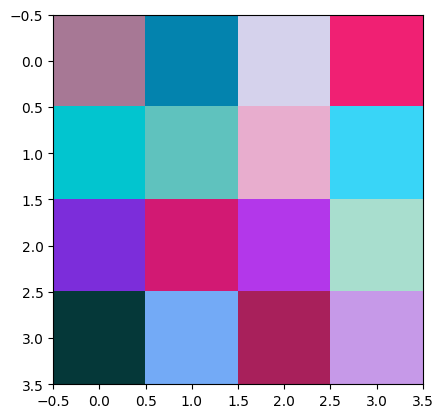

In [11]:
image = np.random.randint(0, 256, size=(4, 4, 3), dtype=np.uint8)

plt.imshow(image, cmap = 'gray')

# Encoding

## Simulation

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\3923856416.py:96: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


[array([0.33546701, 0.31592029, 0.8875    ]), array([0.38972194, 0.30327074, 0.86956522]), array([0.5641629 , 0.24031851, 0.78991597]), array([0.67487613, 0.        , 0.73793103]), array([0.44067605, 0.48500374, 0.75536481]), array([0.4257082 , 0.47599311, 0.76954733]), array([0.6552864 , 0.37811627, 0.65393258]), array([0.76750247, 0.21181151, 0.60504202]), array([0.22803745, 0.57294108, 0.78723404]), array([0.40632153, 0.62804098, 0.66367713]), array([0.58580637, 0.60108541, 0.54362416]), array([0.75187694, 0.55839451, 0.35053763]), array([0.15384063, 0.68658914, 0.71058315]), array([0.25956408, 0.79025781, 0.55508475]), array([0.41841377, 0.83354865, 0.36073059]), array([ 0.64682334,  0.74890856, -0.1440678 ])]
0.42387 sec


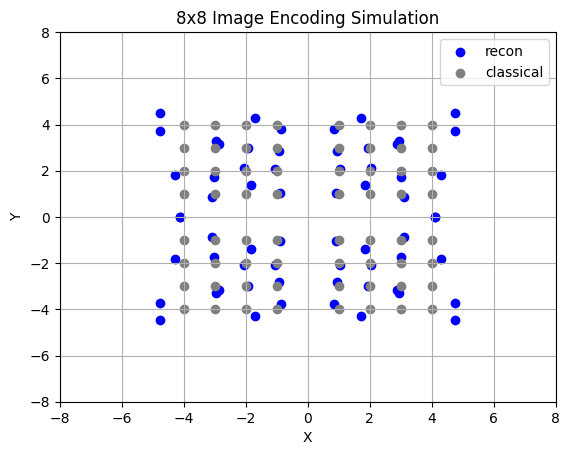

0.2746316995127093


In [827]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)


controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])

        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    
qc_image.x(p)
qc_image.x(O)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=14848)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))
print(recon_pixel)
back_recon_pixel= []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel[i][0] / k
    Y = recon_pixel[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)
back_recon_pixel = list(reversed(back_recon_pixel))

end = time.time()
print(f"{end - start:.5f} sec")

back_2 = [y_axis_reflection(point) for point in back_recon_pixel]
back_3 = [origin_reflection(point) for point in back_recon_pixel]
back_4 = [x_axis_reflection(point) for point in back_recon_pixel]

x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_2 = [point[0] for point in back_2]
y_2 = [point[1] for point in back_2]

x_3 = [point[0] for point in back_3]
y_3 = [point[1] for point in back_3]

x_4 = [point[0] for point in back_4]
y_4 = [point[1] for point in back_4]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]


origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)

x_Q_origin = [point[0] for point in Q_origin]
y_Q_origin = [point[1] for point in Q_origin]

# 시각화
plt.scatter(x_values, y_values, color='blue', label='recon')
plt.scatter(x_2, y_2, color='blue')
plt.scatter(x_3, y_3, color='blue')
plt.scatter(x_4, y_4, color='blue')
plt.scatter(x_Q_origin, y_Q_origin, color='gray', label = 'classical')
plt.title('8x8 Image Encoding Simulation')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.legend()
plt.grid(True)
plt.show()

error = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values[i]
    del_y = y_Q[i] - y_values[i]
    err = del_x**2+del_y**2
    error.append(err)

MSE = sum(error)/len(Q) 
print(MSE)

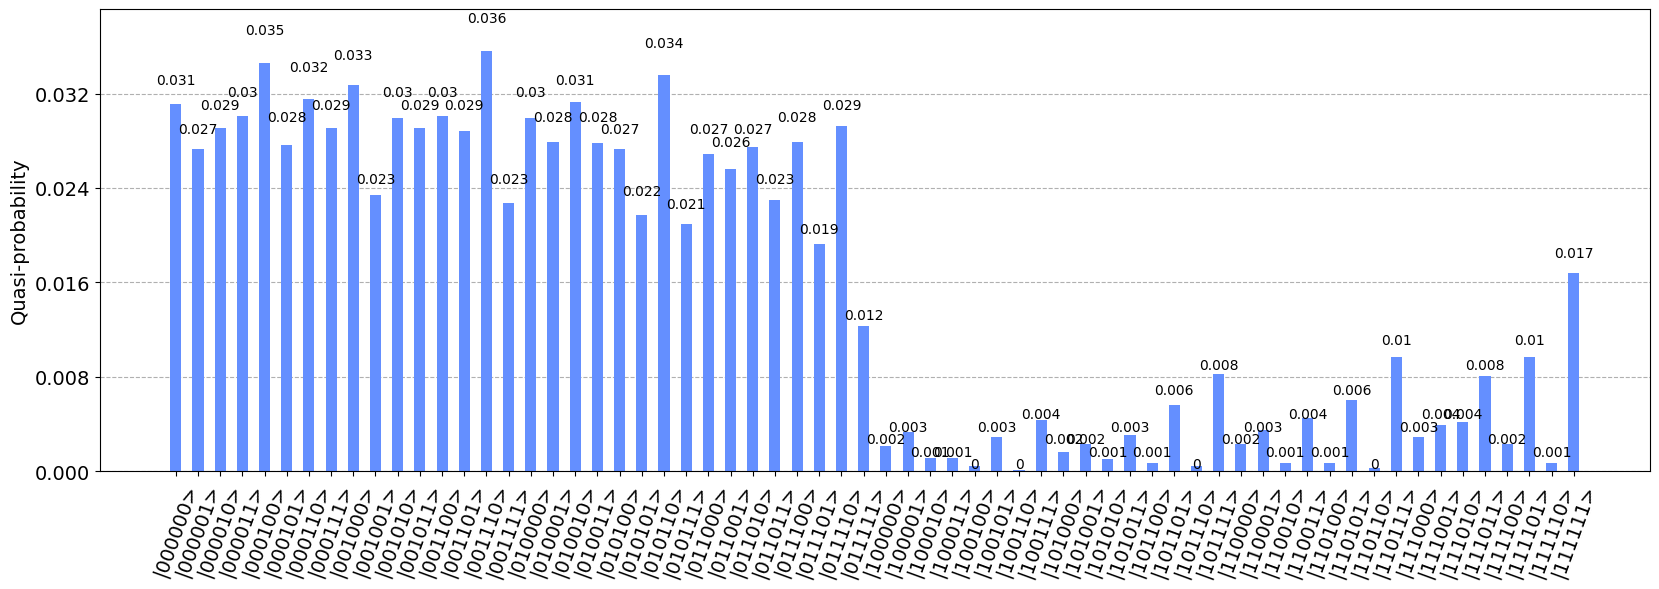

In [635]:
simul_8by8 = {}
for i in counts:
    simul_8by8[f"|{i}>"]=counts[i] / 8192
plot_histogram(simul_8by8, figsize=(20,6))

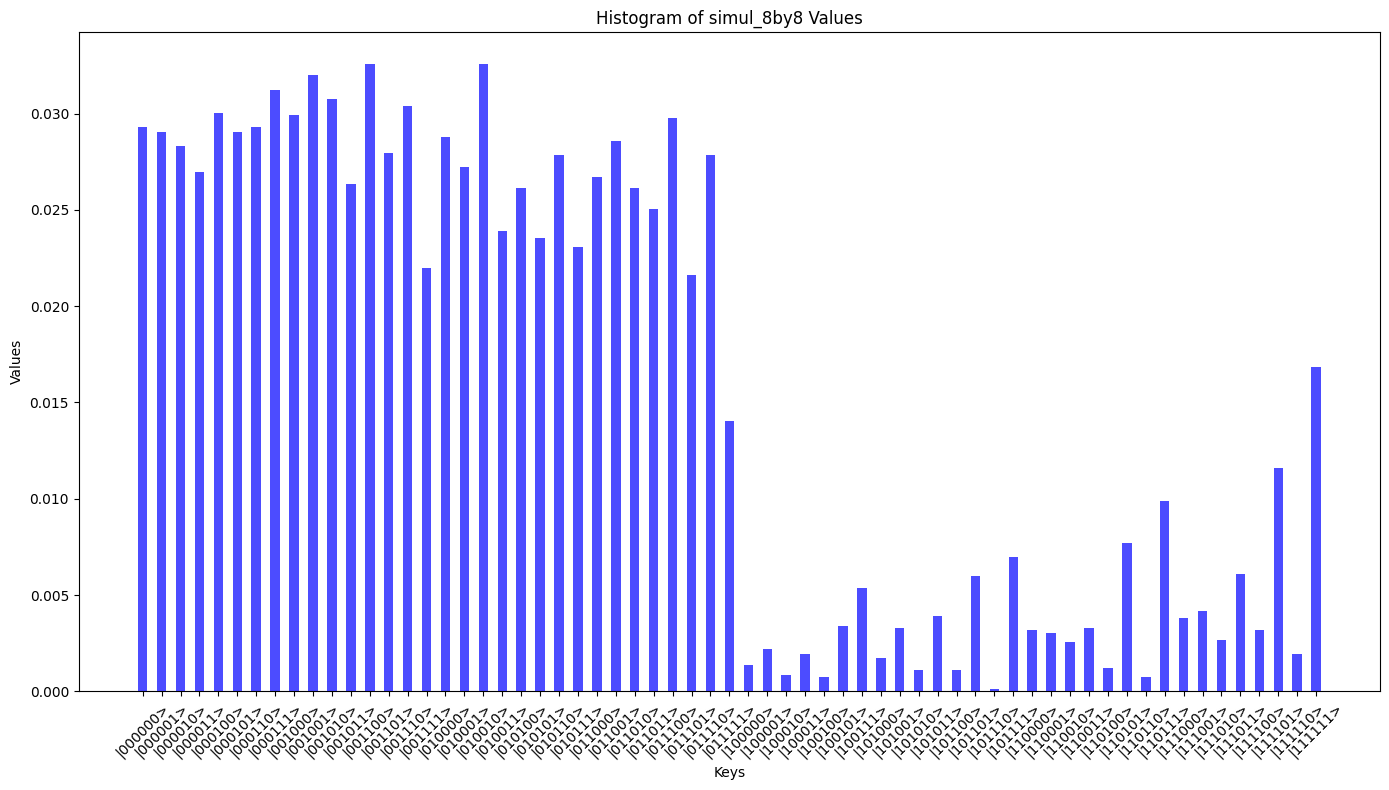

In [144]:
sorted_keys = sorted(simul_8by8.keys())
sorted_values = [simul_8by8[key] for key in sorted_keys]

# 막대 그래프 그리기
plt.figure(figsize=(14, 8))
plt.bar(sorted_keys, sorted_values, color='blue', alpha=0.7, width=0.5)

# 그래프 제목과 축 레이블 설정
plt.title('Histogram of simul_8by8 Values')
plt.xlabel('Keys')
plt.ylabel('Values')

# X축의 레이블이 겹치지 않도록 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()  # 레이아웃 조정
plt.show()

### Iteration에 따른 오차 분석

In [157]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)


controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])

        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    
qc_image.x(p)
qc_image.x(O)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterMSE = []
for iter in range(200):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc_image, aer_sim)
    qobj = assemble(t_qc, shots=256*(iter+1))
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()

    pixel_theta_recon = []
    pixel_phi_recon = []

    pixel_theta = []
    pixel_phi = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            decision = int(key[-1])
            bin_coord = key[1:-1]
            int_coord = int(bin_coord, 2)
            if int_coord == i and decision == 1:
                pixel_theta.append((state,bin_coord, amount))
            elif int_coord == i and decision == 0:
                pixel_phi.append((state,bin_coord, amount))

    # ======================== phi ====================================
    phi_result_dict = {}
    for state in pixel_phi:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict:
            phi_result_dict[key] += value  
        else:
            phi_result_dict[key] = value  

    phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
    #print(phi_result_list)

    phi_state_0 = []
    for state, phi, amount in pixel_phi:
        if not int(state):
            phi_state_0.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
            pixel_phi_recon.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict = {}
    for state in pixel_theta:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict:
            theta_result_dict[key] += value  
        else:
            theta_result_dict[key] = value  

    theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

    theta_state_0 = []

    for state, theta, amount in pixel_theta:
        if not int(state):
            theta_state_0.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
            pixel_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_pixel = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        z = np.cos(pixel_theta_recon[i])
        recon_pixel.append(np.array([x,y,z]))
    print(recon_pixel)
    back_recon_pixel= []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel[i][0] / k
        Y = recon_pixel[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel.append(back_P)
    back_recon_pixel = list(reversed(back_recon_pixel))

    end = time.time()
    print(f"{end - start:.5f} sec")

    x_values = [point[0] for point in back_recon_pixel]
    y_values = [point[1] for point in back_recon_pixel]

    x_Q = [point[0] for point in Q]
    y_Q = [point[1] for point in Q]

    error = []
    for j in range(len(Q)):
        del_x = x_Q[j] - x_values[j]
        del_y = y_Q[j] - y_values[j]
        err = del_x**2+del_y**2
        error.append(np.sqrt(err))
    MSE = sum(error)/len(Q)
    iterMSE.append(MSE) 

    print("iteration = ",(iter+1)*256)
    print("MSE = ", MSE)
    print("==========================================================================")

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\1231730157.py:98: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


[array([0., 0., 1.]), array([0.74535599, 0.        , 0.66666667]), array([0.66143783, 0.        , 0.75      ]), array([0.83147942, 0.        , 0.55555556]), array([0.66143783, 0.        , 0.75      ]), array([1.000000e+00, 0.000000e+00, 6.123234e-17]), array([0.98974332, 0.        , 0.14285714]), array([0.77138922, 0.        , 0.63636364]), array([-0.0374234 ,  0.90273253,  0.42857143]), array([0.83147942, 0.        , 0.55555556]), array([0.8, 0. , 0.6]), array([0.5527708 , 0.        , 0.83333333]), array([0.25298221, 0.86736759, 0.42857143]), array([0.8660254, 0.       , 0.5      ]), array([0.66143783, 0.        , 0.75      ]), array([ 0.9797959,  0.       , -0.2      ])]
0.31715 sec
iteration =  256
MSE =  2.7760886794611945
[array([0.26452003, 0.49760375, 0.82608696]), array([0.57495957, 0.        , 0.81818182]), array([0.57495957, 0.        , 0.81818182]), array([0., 0., 1.]), array([0.29365949, 0.46831577, 0.83333333]), array([0.20499077, 0.80581438, 0.55555556]), array([0.7580693

In [162]:
iters = []
for iter in range(200):
    iters.append((iter+1)*256)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterMSE,
                   "Margin" : [0.5]*200})
df

Iterations       MSE  Margin
0           256  2.776089     0.5
1           512  1.929496     0.5
2           768  2.567560     0.5
3          1024  1.277270     0.5
4          1280  1.374645     0.5
..          ...       ...     ...
195       50176  0.203656     0.5
196       50432  0.234764     0.5
197       50688  0.184418     0.5
198       50944  0.227809     0.5
199       51200  0.182345     0.5

[200 rows x 3 columns]

In [163]:
df.to_excel("8by8 Image Encoding simulation only position.xlsx")

## IonQ

In [37]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

[array([0.36634273, 0.36816446, 0.85454545]), array([0.36920695, 0.32535181, 0.87053571]), array([0.57559063, 0.31500722, 0.75462963]), array([0.68017384, 0.        , 0.73305085]), array([0.36320475, 0.46892345, 0.80510441]), array([0.4154122 , 0.45224041, 0.78924731]), array([0.59244827, 0.47483963, 0.65079365]), array([0.79202561, 0.22978643, 0.5655914 ]), array([0.307286  , 0.53477698, 0.78713969]), array([0.2941873 , 0.63736327, 0.71219512]), array([0.53988641, 0.602585  , 0.5877193 ]), array([0.76278841, 0.49117081, 0.42060086]), array([0.14254849, 0.59910512, 0.78787879]), array([0.17683447, 0.74907871, 0.63844394]), array([0.48991894, 0.79566606, 0.35622318]), array([ 0.6818407 ,  0.72432305, -0.10222222])]
9.76065 sec


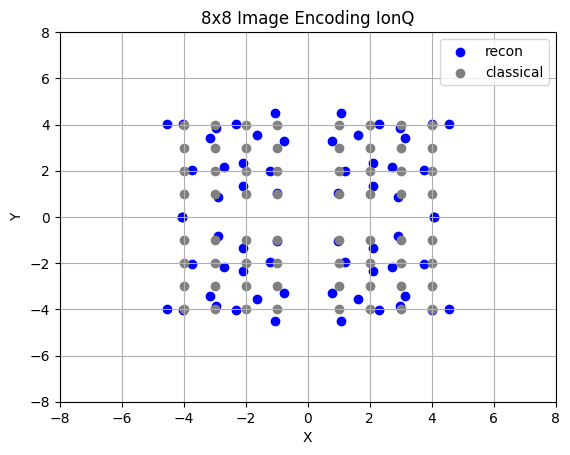

0.2491221484253966


In [707]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)


controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])

        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    
qc_image.x(p)
qc_image.x(O)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=14336)
result = job.result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))
print(recon_pixel)
back_recon_pixel= []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel[i][0] / k
    Y = recon_pixel[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)
back_recon_pixel = list(reversed(back_recon_pixel))

end = time.time()
print(f"{end - start:.5f} sec")

back_2 = [y_axis_reflection(point) for point in back_recon_pixel]
back_3 = [origin_reflection(point) for point in back_recon_pixel]
back_4 = [x_axis_reflection(point) for point in back_recon_pixel]

x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_2 = [point[0] for point in back_2]
y_2 = [point[1] for point in back_2]

x_3 = [point[0] for point in back_3]
y_3 = [point[1] for point in back_3]

x_4 = [point[0] for point in back_4]
y_4 = [point[1] for point in back_4]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]


origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)

x_Q_origin = [point[0] for point in Q_origin]
y_Q_origin = [point[1] for point in Q_origin]

# 시각화
plt.scatter(x_values, y_values, color='blue', label='recon')
plt.scatter(x_2, y_2, color='blue')
plt.scatter(x_3, y_3, color='blue')
plt.scatter(x_4, y_4, color='blue')
plt.scatter(x_Q_origin, y_Q_origin, color='gray', label = 'classical')
plt.title('8x8 Image Encoding IonQ')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.legend()
plt.grid(True)
plt.show()

error = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values[i]
    del_y = y_Q[i] - y_values[i]
    err = del_x**2+del_y**2
    error.append(err)

MSE = sum(error)/len(Q) 
print(MSE)

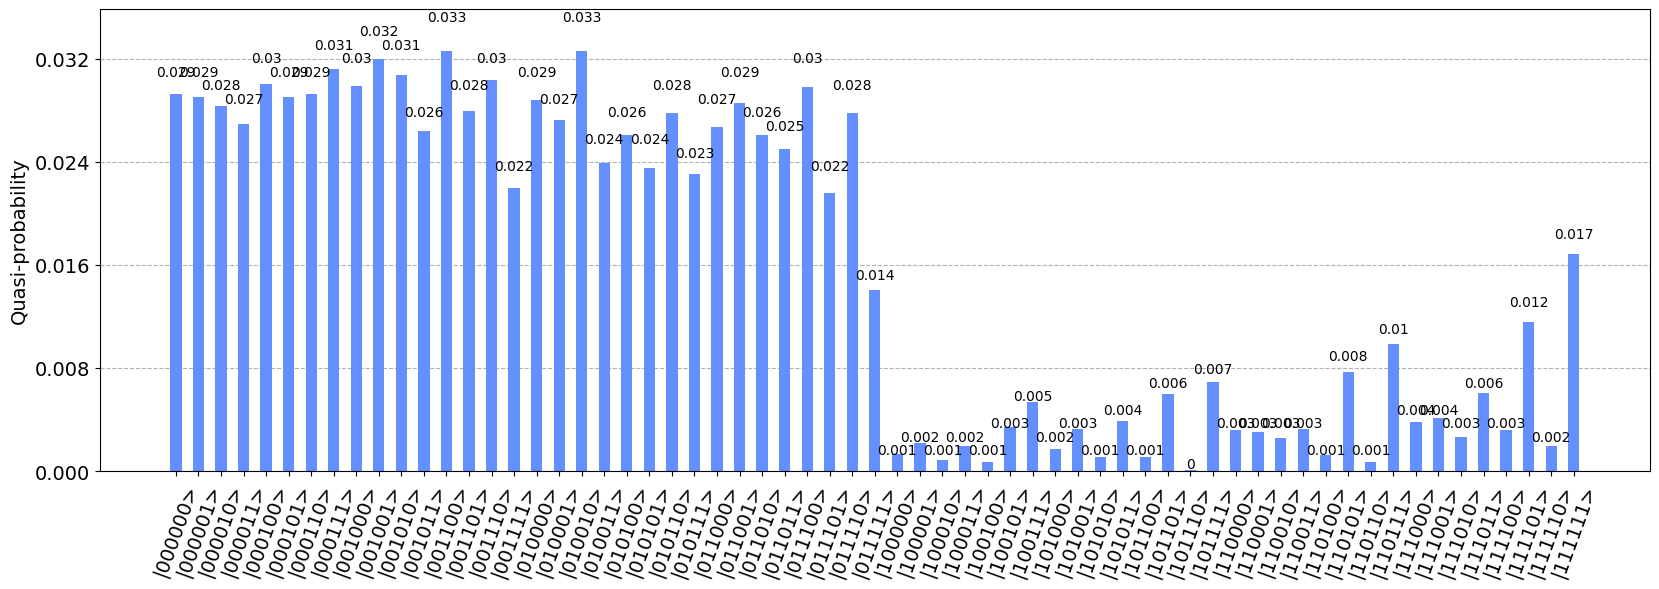

In [172]:
ionq_8by8 = {}
for i in counts:
    ionq_8by8[f"|{i}>"]=counts[i] / 6656
plot_histogram(simul_8by8, figsize=(20,6))

### Iteration 에 따른 MSE 분석

In [164]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)


controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])

        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    
qc_image.x(p)
qc_image.x(O)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterMSE = []
for iter in range(200):
    ionq_sim = provider.get_backend("ionq_simulator")
    t_qc_image = transpile(qc_image, ionq_sim)
    job = ionq_sim.run(t_qc_image, shots=256*(iter+1))
    result = job.result()
    counts = result.get_counts()

    pixel_theta_recon = []
    pixel_phi_recon = []

    pixel_theta = []
    pixel_phi = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            decision = int(key[-1])
            bin_coord = key[1:-1]
            int_coord = int(bin_coord, 2)
            if int_coord == i and decision == 1:
                pixel_theta.append((state,bin_coord, amount))
            elif int_coord == i and decision == 0:
                pixel_phi.append((state,bin_coord, amount))

    # ======================== phi ====================================
    phi_result_dict = {}
    for state in pixel_phi:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict:
            phi_result_dict[key] += value  
        else:
            phi_result_dict[key] = value  

    phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
    #print(phi_result_list)

    phi_state_0 = []
    for state, phi, amount in pixel_phi:
        if not int(state):
            phi_state_0.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
            pixel_phi_recon.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict = {}
    for state in pixel_theta:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict:
            theta_result_dict[key] += value  
        else:
            theta_result_dict[key] = value  

    theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

    theta_state_0 = []

    for state, theta, amount in pixel_theta:
        if not int(state):
            theta_state_0.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
            pixel_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_pixel = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        z = np.cos(pixel_theta_recon[i])
        recon_pixel.append(np.array([x,y,z]))
    print(recon_pixel)
    back_recon_pixel= []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel[i][0] / k
        Y = recon_pixel[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel.append(back_P)
    back_recon_pixel = list(reversed(back_recon_pixel))

    end = time.time()
    print(f"{end - start:.5f} sec")

    x_values = [point[0] for point in back_recon_pixel]
    y_values = [point[1] for point in back_recon_pixel]

    x_Q = [point[0] for point in Q]
    y_Q = [point[1] for point in Q]

    error = []
    for j in range(len(Q)):
        del_x = x_Q[j] - x_values[j]
        del_y = y_Q[j] - y_values[j]
        err = del_x**2+del_y**2
        error.append(np.sqrt(err))
    MSE = sum(error)/len(Q)
    iterMSE.append(MSE) 

    print("iteration = ",(iter+1)*256)
    print("MSE = ", MSE)
    print("==========================================================================")

[array([0.8, 0. , 0.6]), array([0.8660254, 0.       , 0.5      ]), array([0.9797959, 0.       , 0.2      ]), array([0., 0., 1.]), array([0.67986927, 0.        , 0.73333333]), array([0., 0., 1.]), array([0., 0., 1.]), array([0.9860133 , 0.        , 0.16666667]), array([0., 0., 1.]), array([-0.38569461,  0.66804266,  0.63636364]), array([1.000000e+00, 0.000000e+00, 6.123234e-17]), array([1.000000e+00, 0.000000e+00, 6.123234e-17]), array([1.000000e+00, 0.000000e+00, 6.123234e-17]), array([0.26398653, 0.90509668, 0.33333333]), array([-0.0923866 ,  0.82633089,  0.55555556]), array([ 1.2246468e-16,  0.0000000e+00, -1.0000000e+00])]
8.89503 sec
iteration =  256
MSE =  2.9432980856186766
[array([0.53293871, 0.        , 0.84615385]), array([0.51507875, 0.        , 0.85714286]), array([0.328503  , 0.61796577, 0.71428571]), array([0.96209139, 0.        , 0.27272727]), array([0., 0., 1.]), array([0.66143783, 0.        , 0.75      ]), array([0.50250857, 0.70532626, 0.5       ]), array([0.88443328, 

In [166]:
iters = []
for iter in range(200):
    iters.append((iter+1)*256)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterMSE,
                   "Margin" : [0.5]*200})

In [167]:
df.to_excel("8by8 Image Encoding IonQ only position.xlsx")

# Rotation

In [168]:
def Rotation(pixel, degree):
    rotation = degree * np.pi / 180
    degree = np.array([[np.cos(rotation), -np.sin(rotation),0],
                       [np.sin(rotation), np.cos(rotation),0],
                       [0,0,1]])
    rotated_pixel = []
    for i in range(len(pixel)):
        rotated_pixel.append(np.array(np.dot(degree, pixel[i])))
    return rotated_pixel

In [169]:
def rotate_x_axis(point, axis_angle_degrees):
    angle = axis_angle_degrees * np.pi / 180
    x, y, z = point[0], point[1], point[2]
    m = np.tan(angle)
    intersection_x = round((x + y  * m) / (1 + m** 2),4)
    intersection_y = round((x * m+ y * (m**2)) / (1 + m ** 2),4)
    
    x_reflected = 2 * intersection_x - x
    y_reflected = 2 * intersection_y - y
    
    return np.array([x_reflected, y_reflected, z])

def rotate_y_axis(point, axis_angle_degrees):
    angle = axis_angle_degrees * np.pi / 180
    x, y, z = point[0], point[1], point[2]
    cot = 1 / np.tan(angle)
    intersection_x = round((x - y  * cot) / (1 + cot ** 2),4)
    intersection_y = round((-x * cot+ y * (cot**2)) / (1 + cot ** 2),4)
    
    x_reflected = 2 * intersection_x - x
    y_reflected = 2 * intersection_y - y
    
    return np.array([x_reflected, y_reflected, z])

def origin_reflection(point):
    return np.array([-point[0], -point[1], point[2]])

## Simulation

In [170]:
Q_rot = Rotation(Q, 30)

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\299488452.py:150: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


back =  [array([0.33093797, 1.52635204, 0.        ]), array([0.28263934, 2.17594932, 0.        ]), array([-0.76180571,  3.07896381,  0.        ]), array([-0.87701543,  3.69054406,  0.        ]), array([1.24518012, 1.72550235, 0.        ]), array([0.50937837, 2.70210805, 0.        ]), array([0.58784032, 3.37561093, 0.        ]), array([-0.87415364,  4.45282111,  0.        ]), array([2.21142154, 2.15538379, 0.        ]), array([1.62520108, 3.28577138, 0.        ]), array([0.57198347, 4.40077066, 0.        ]), array([0.59050296, 5.21074288, 0.        ]), array([2.74169073, 3.51967327, 0.        ]), array([2.55270152, 3.9566271 , 0.        ]), array([1.03742879, 4.67137745, 0.        ]), array([1.09738944, 5.79812715, 0.        ])]
0.34196 sec


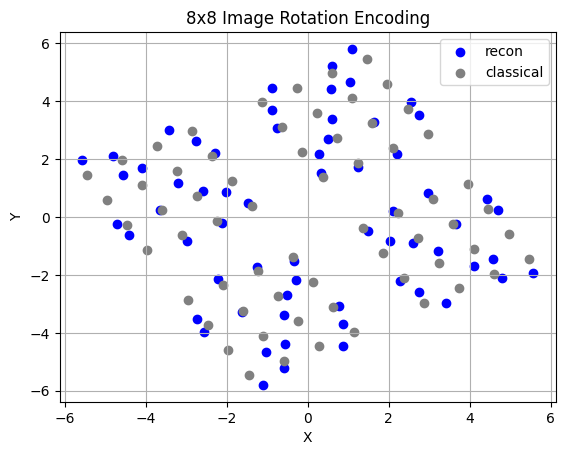

0.19441146378793886


In [721]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

rotate_angle = 30
Q_rot = Rotation(Q, rotate_angle)

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

P_rot = []
k_list = []
size_list=[]
for i in Q_rot:
    sphere = project(i,n)
    P_rot.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)


phis_rot = []
for i in range(len(P_rot)):
    phi = round(np.arctan2(P_rot[i][1], P_rot[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_rot.append(phi)
    else:
        phi = round(phi/4,4)
        phis_rot.append(phi)

rotate = []
for i in range(len(P)):
    angle = round((phis_rot[i] - phis[i]),4)
    rotate.append(angle)        

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)


controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)

for i, (angle, theta) in enumerate(zip(rotate, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            pass
        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*angle,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(p)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=12544)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))

back_recon_pixel= []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel[i][0] / k
    Y = recon_pixel[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)
#back_recon_pixel = list(reversed(back_recon_pixel))
print("back = ", back_recon_pixel)
end = time.time()
print(f"{end - start:.5f} sec")

if rotate_angle % 90 == 0:
    back_2 = [y_axis_reflection(point) for point in back_recon_pixel]
    back_3 = [origin_reflection(point) for point in back_recon_pixel]
    back_4 = [x_axis_reflection(point) for point in back_recon_pixel]
else:
    back_2 = [rotate_y_axis(point, rotate_angle) for point in back_recon_pixel]
    back_3 = [origin_reflection(point) for point in back_recon_pixel]
    back_4 = [rotate_x_axis(point, rotate_angle) for point in back_recon_pixel]

x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_2 = [point[0] for point in back_2]
y_2 = [point[1] for point in back_2]

x_3 = [point[0] for point in back_3]
y_3 = [point[1] for point in back_3]

x_4 = [point[0] for point in back_4]
y_4 = [point[1] for point in back_4]

x_Q_rot = [point[0] for point in Q_rot]
y_Q_rot = [point[1] for point in Q_rot]

origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)
origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)
Q_origin_rot = Rotation(Q_origin, rotate_angle)

x_Q_origin_rot = [point[0] for point in Q_origin_rot]
y_Q_origin_rot = [point[1] for point in Q_origin_rot]

# 시각화
plt.scatter(x_values, y_values, color='blue', label='recon')
plt.scatter(x_2, y_2, color='blue')
plt.scatter(x_3, y_3, color='blue')
plt.scatter(x_4, y_4, color='blue')
plt.scatter(x_Q_origin_rot, y_Q_origin_rot, color='gray', label = 'classical')
plt.title('8x8 Image Rotation Encoding')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

error = []
for i in range(len(Q)):
    del_x = x_Q_rot[i] - x_values[i]
    del_y = y_Q_rot[i] - y_values[i]
    err = del_x**2+del_y**2
    error.append(err)

MSE = sum(error)/len(Q) 
print(MSE)

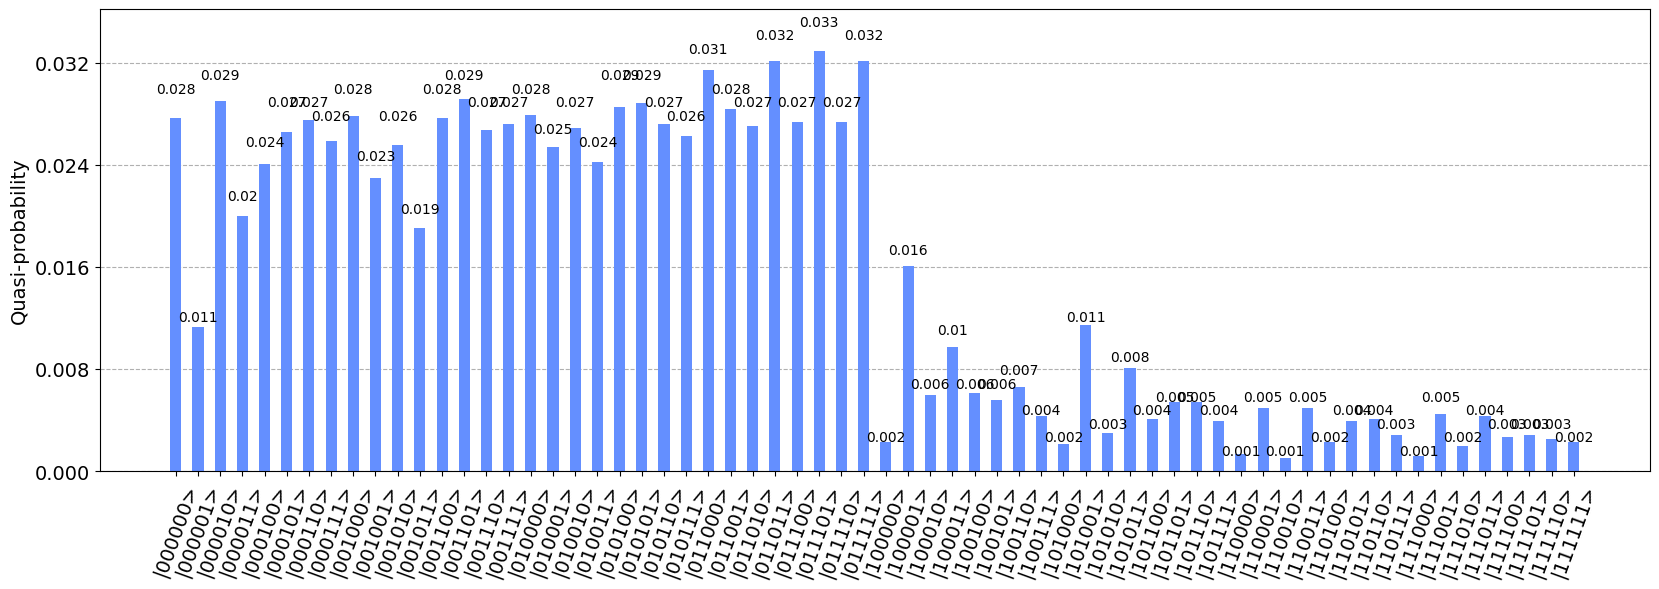

In [174]:
simul_8by8_rot = {}
for i in counts:
    simul_8by8_rot[f"|{i}>"]=counts[i] / 6656
plot_histogram(simul_8by8_rot, figsize=(20,6))

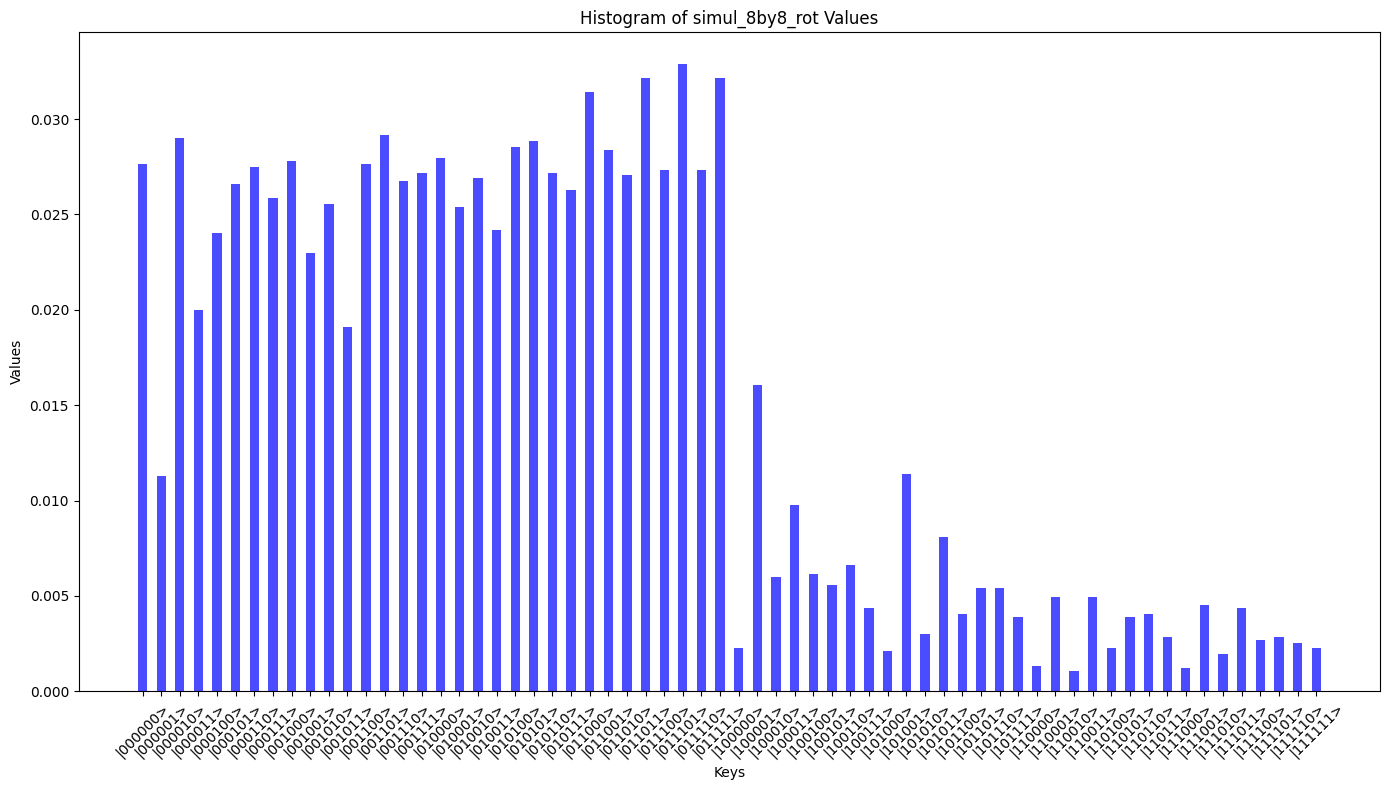

In [175]:
sorted_keys = sorted(simul_8by8_rot.keys())
sorted_values = [simul_8by8_rot[key] for key in sorted_keys]

# 막대 그래프 그리기
plt.figure(figsize=(14, 8))
plt.bar(sorted_keys, sorted_values, color='blue', alpha=0.7, width=0.5)

# 그래프 제목과 축 레이블 설정
plt.title('Histogram of simul_8by8_rot Values')
plt.xlabel('Keys')
plt.ylabel('Values')

# X축의 레이블이 겹치지 않도록 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()  # 레이아웃 조정
plt.show()

### Iteration에 따른 오차 분석

In [176]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

rotate_angle = 30
Q_rot = Rotation(Q, rotate_angle)

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

phis_rot = []
for i in range(len(P_rot)):
    phi = round(np.arctan2(P_rot[i][1], P_rot[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_rot.append(phi)
    else:
        phi = round(phi/4,4)
        phis_rot.append(phi)

rotate = []
for i in range(len(P)):
    angle = round((phis_rot[i] - phis[i]),4)
    rotate.append(angle)        

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)


controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])

        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    
qc_image.x(p)
qc_image.x(O)

for i, (angle, theta) in enumerate(zip(rotate, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            pass
        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*angle,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(p)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterMSE = []
for iter in range(200):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc_image, aer_sim)
    qobj = assemble(t_qc, shots=256*(iter+1))
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()

    pixel_theta_recon = []
    pixel_phi_recon = []

    pixel_theta = []
    pixel_phi = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            decision = int(key[-1])
            bin_coord = key[1:-1]
            int_coord = int(bin_coord, 2)
            if int_coord == i and decision == 1:
                pixel_theta.append((state,bin_coord, amount))
            elif int_coord == i and decision == 0:
                pixel_phi.append((state,bin_coord, amount))

    # ======================== phi ====================================
    phi_result_dict = {}
    for state in pixel_phi:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict:
            phi_result_dict[key] += value  
        else:
            phi_result_dict[key] = value  

    phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
    #print(phi_result_list)

    phi_state_0 = []
    for state, phi, amount in pixel_phi:
        if not int(state):
            phi_state_0.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
            pixel_phi_recon.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict = {}
    for state in pixel_theta:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict:
            theta_result_dict[key] += value  
        else:
            theta_result_dict[key] = value  

    theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

    theta_state_0 = []

    for state, theta, amount in pixel_theta:
        if not int(state):
            theta_state_0.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
            pixel_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_pixel = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        z = np.cos(pixel_theta_recon[i])
        recon_pixel.append(np.array([x,y,z]))
    print(recon_pixel)
    back_recon_pixel= []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel[i][0] / k
        Y = recon_pixel[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel.append(back_P)
    #back_recon_pixel = list(reversed(back_recon_pixel))

    end = time.time()
    print(f"{end - start:.5f} sec")

    if rotate_angle % 90 == 0:
        back_2 = [y_axis_reflection(point) for point in back_recon_pixel]
        back_3 = [origin_reflection(point) for point in back_recon_pixel]
        back_4 = [x_axis_reflection(point) for point in back_recon_pixel]
    else:
        back_2 = [rotate_y_axis(point, rotate_angle) for point in back_recon_pixel]
        back_3 = [origin_reflection(point) for point in back_recon_pixel]
        back_4 = [rotate_x_axis(point, rotate_angle) for point in back_recon_pixel]

    x_values = [point[0] for point in back_recon_pixel]
    y_values = [point[1] for point in back_recon_pixel]
    x_Q_rot = [point[0] for point in Q_rot]
    y_Q_rot = [point[1] for point in Q_rot]
    '''
    x_2 = [point[0] for point in back_2]
    y_2 = [point[1] for point in back_2]

    x_3 = [point[0] for point in back_3]
    y_3 = [point[1] for point in back_3]

    x_4 = [point[0] for point in back_4]
    y_4 = [point[1] for point in back_4]

    origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)
    origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
    origin_input_tuple = origin_img_mean.shape
    Q_origin = generate_coordinates(origin_input_tuple)
    Q_origin_rot = Rotation(Q_origin, rotate_angle)

    x_Q_origin_rot = [point[0] for point in Q_origin_rot]
    y_Q_origin_rot = [point[1] for point in Q_origin_rot]
    '''
    error = []
    for j in range(len(Q)):
        del_x = x_Q_rot[j] - x_values[j]
        del_y = y_Q_rot[j] - y_values[j]
        err = del_x**2+del_y**2
        error.append(np.sqrt(err))
    MSE = sum(error)/len(Q)
    iterMSE.append(MSE) 

    print("iteration = ",(iter+1)*256)
    print("MSE = ", MSE)
    print("==========================================================================")

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\659318.py:146: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


[array([-0.10886621,  0.97372899, -0.2       ]), array([-0.27826624,  0.95405567,  0.11111111]), array([-0.42993284,  0.3474382 ,  0.83333333]), array([-0.5755102 ,  0.16967028,  0.8       ]), array([1.000000e+00, 0.000000e+00, 6.123234e-17]), array([-0.62873567,  0.76964003,  0.11111111]), array([-0.224,  0.768,  0.6  ]), array([0.62853936, 0.        , 0.77777778]), array([0.57495957, 0.        , 0.81818182]), array([-0., -0.,  1.]), array([-7.45355992e-01,  9.12797830e-17,  6.66666667e-01]), array([0.23333333, 0.5527708 , 0.8       ]), array([0.13882028, 0.64670621, 0.75      ]), array([-0.09622504,  0.86066297,  0.5       ]), array([-0.,  0.,  1.]), array([0.07856742, 0.62360956, 0.77777778])]
0.33446 sec
iteration =  256
MSE =  2.977904471881261
[array([0.30288993, 0.92675508, 0.22222222]), array([0.06543303, 0.86354995, 0.5       ]), array([-0.09953405,  0.89025957,  0.44444444]), array([-0.40770538,  0.80628956,  0.42857143]), array([0.26398653, 0.90509668, 0.33333333]), array([0

In [178]:
iters = []
for iter in range(200):
    iters.append((iter+1)*256)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterMSE,
                   "Margin" : [0.5]*200})
df.to_excel("8by8 Image Rotation simulation only position.xlsx")

## IonQ

back =  [array([0.32263781, 1.29218835, 0.        ]), array([-0.34909396,  2.09760679,  0.        ]), array([-0.80461111,  3.24979763,  0.        ]), array([-1.44966685,  3.91891862,  0.        ]), array([1.01587259, 1.83495491, 0.        ]), array([0.50552837, 2.9553156 , 0.        ]), array([0.16654712, 4.00431769, 0.        ]), array([-1.11818543,  4.56318911,  0.        ]), array([2.37889775, 1.95692249, 0.        ]), array([0.89899094, 3.57165328, 0.        ]), array([1.53250367, 3.74411824, 0.        ]), array([0.7690596 , 5.30885537, 0.        ]), array([3.08771391, 2.91634068, 0.        ]), array([2.27019498, 4.27059361, 0.        ]), array([1.36347713, 3.74624894, 0.        ]), array([1.36837699, 5.55597008, 0.        ])]
8.63967 sec


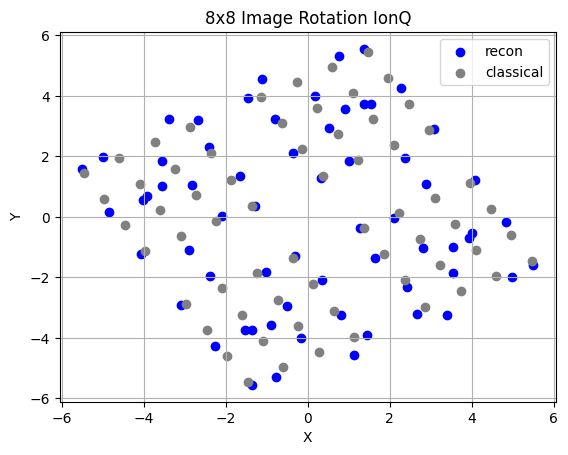

0.25238801501070735


In [722]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

rotate_angle = 30
Q_rot = Rotation(Q, rotate_angle)

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

P_rot = []
k_list = []
size_list=[]
for i in Q_rot:
    sphere = project(i,n)
    P_rot.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)


phis_rot = []
for i in range(len(P_rot)):
    phi = round(np.arctan2(P_rot[i][1], P_rot[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_rot.append(phi)
    else:
        phi = round(phi/4,4)
        phis_rot.append(phi)

rotate = []
for i in range(len(P)):
    angle = round((phis_rot[i] - phis[i]),4)
    rotate.append(angle)        

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)


controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)

for i, (angle, theta) in enumerate(zip(rotate, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            pass
        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*angle,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(p)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=12288)
result = job.result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))

back_recon_pixel= []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel[i][0] / k
    Y = recon_pixel[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)
#back_recon_pixel = list(reversed(back_recon_pixel))
print("back = ", back_recon_pixel)
end = time.time()
print(f"{end - start:.5f} sec")

if rotate_angle % 90 == 0:
    back_2 = [y_axis_reflection(point) for point in back_recon_pixel]
    back_3 = [origin_reflection(point) for point in back_recon_pixel]
    back_4 = [x_axis_reflection(point) for point in back_recon_pixel]
else:
    back_2 = [rotate_y_axis(point, rotate_angle) for point in back_recon_pixel]
    back_3 = [origin_reflection(point) for point in back_recon_pixel]
    back_4 = [rotate_x_axis(point, rotate_angle) for point in back_recon_pixel]

x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_2 = [point[0] for point in back_2]
y_2 = [point[1] for point in back_2]

x_3 = [point[0] for point in back_3]
y_3 = [point[1] for point in back_3]

x_4 = [point[0] for point in back_4]
y_4 = [point[1] for point in back_4]

x_Q_rot = [point[0] for point in Q_rot]
y_Q_rot = [point[1] for point in Q_rot]

origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)
origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)
Q_origin_rot = Rotation(Q_origin, rotate_angle)

x_Q_origin_rot = [point[0] for point in Q_origin_rot]
y_Q_origin_rot = [point[1] for point in Q_origin_rot]

# 시각화
plt.scatter(x_values, y_values, color='blue', label='recon')
plt.scatter(x_2, y_2, color='blue')
plt.scatter(x_3, y_3, color='blue')
plt.scatter(x_4, y_4, color='blue')
plt.scatter(x_Q_origin_rot, y_Q_origin_rot, color='gray', label = 'classical')
plt.title('8x8 Image Rotation IonQ')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

error = []
for i in range(len(Q)):
    del_x = x_Q_rot[i] - x_values[i]
    del_y = y_Q_rot[i] - y_values[i]
    err = del_x**2+del_y**2
    error.append(err)

MSE = sum(error)/len(Q) 
print(MSE)

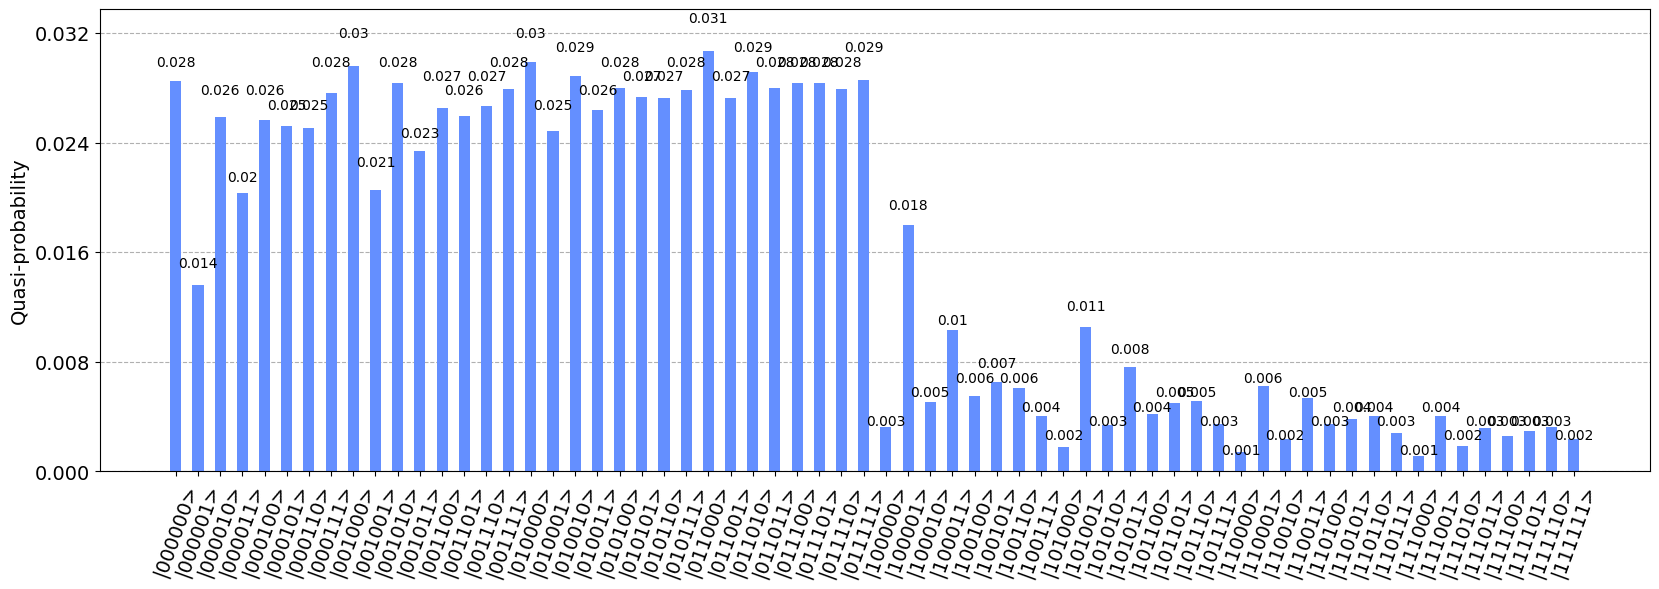

In [95]:
ionq_8by8_rot = {}
for i in counts:
    ionq_8by8_rot[f"|{i}>"]=counts[i] / 200000
plot_histogram(ionq_8by8_rot, figsize=(20,6))

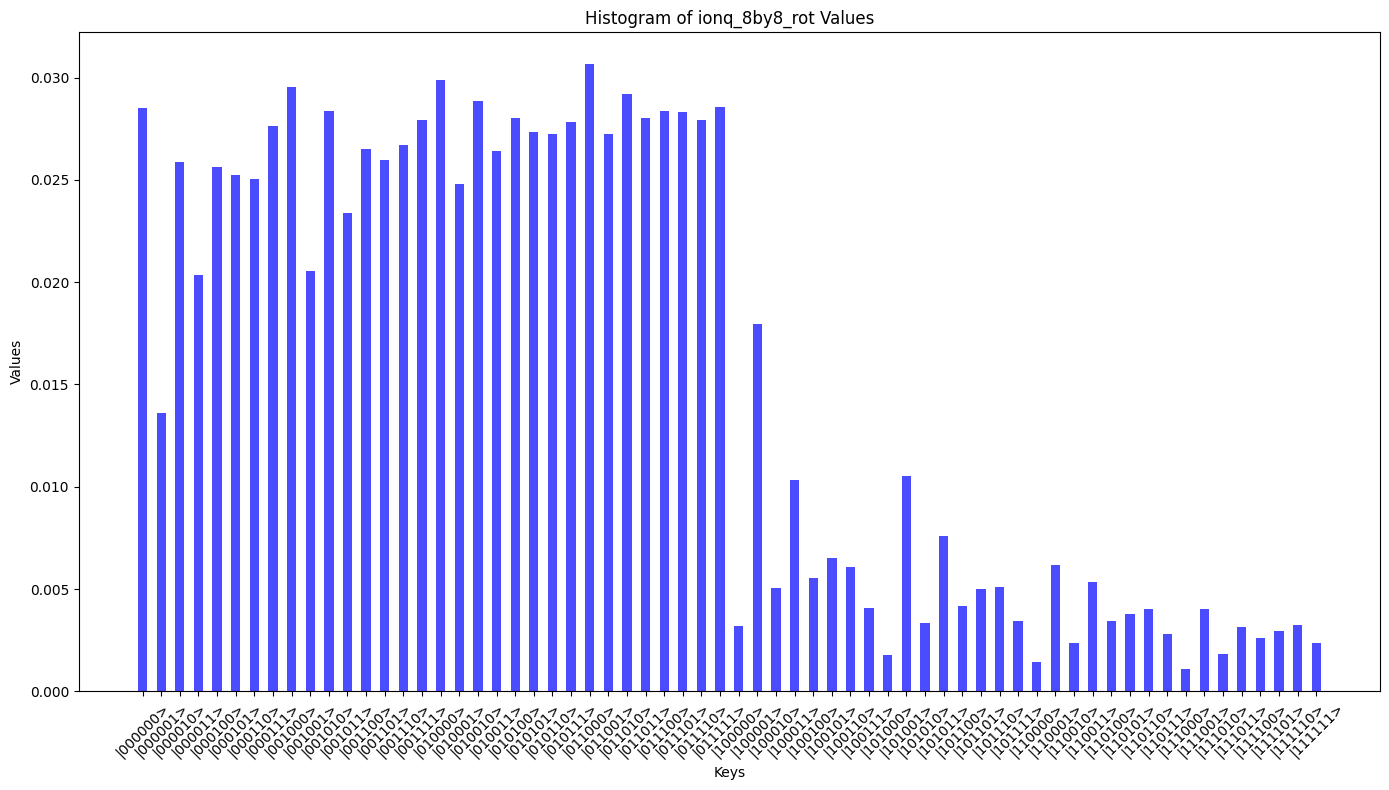

In [97]:
sorted_keys = sorted(ionq_8by8_rot.keys())
sorted_values = [ionq_8by8_rot[key] for key in sorted_keys]

# 막대 그래프 그리기
plt.figure(figsize=(14, 8))
plt.bar(sorted_keys, sorted_values, color='blue', alpha=0.7, width=0.5)

# 그래프 제목과 축 레이블 설정
plt.title('Histogram of ionq_8by8_rot Values')
plt.xlabel('Keys')
plt.ylabel('Values')

# X축의 레이블이 겹치지 않도록 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()  # 레이아웃 조정
plt.show()

### Iteration에 따른 MSE 분석 

In [179]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

rotate_angle = 30
Q_rot = Rotation(Q, rotate_angle)

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

phis_rot = []
for i in range(len(P_rot)):
    phi = round(np.arctan2(P_rot[i][1], P_rot[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_rot.append(phi)
    else:
        phi = round(phi/4,4)
        phis_rot.append(phi)

rotate = []
for i in range(len(P)):
    angle = round((phis_rot[i] - phis[i]),4)
    rotate.append(angle)        

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)


controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])

        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    
qc_image.x(p)
qc_image.x(O)

for i, (angle, theta) in enumerate(zip(rotate, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            pass
        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*angle,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(p)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterMSE = []
for iter in range(200):
    ionq_sim = provider.get_backend("ionq_simulator")
    t_qc_image = transpile(qc_image, ionq_sim)
    job = ionq_sim.run(t_qc_image, shots=256*(iter+1))
    result = job.result()
    counts = result.get_counts()

    pixel_theta_recon = []
    pixel_phi_recon = []

    pixel_theta = []
    pixel_phi = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            decision = int(key[-1])
            bin_coord = key[1:-1]
            int_coord = int(bin_coord, 2)
            if int_coord == i and decision == 1:
                pixel_theta.append((state,bin_coord, amount))
            elif int_coord == i and decision == 0:
                pixel_phi.append((state,bin_coord, amount))

    # ======================== phi ====================================
    phi_result_dict = {}
    for state in pixel_phi:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict:
            phi_result_dict[key] += value  
        else:
            phi_result_dict[key] = value  

    phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
    #print(phi_result_list)

    phi_state_0 = []
    for state, phi, amount in pixel_phi:
        if not int(state):
            phi_state_0.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
            pixel_phi_recon.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict = {}
    for state in pixel_theta:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict:
            theta_result_dict[key] += value  
        else:
            theta_result_dict[key] = value  

    theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

    theta_state_0 = []

    for state, theta, amount in pixel_theta:
        if not int(state):
            theta_state_0.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
            pixel_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_pixel = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        z = np.cos(pixel_theta_recon[i])
        recon_pixel.append(np.array([x,y,z]))
    print(recon_pixel)
    back_recon_pixel= []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel[i][0] / k
        Y = recon_pixel[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel.append(back_P)
    #back_recon_pixel = list(reversed(back_recon_pixel))

    end = time.time()
    print(f"{end - start:.5f} sec")

    if rotate_angle % 90 == 0:
        back_2 = [y_axis_reflection(point) for point in back_recon_pixel]
        back_3 = [origin_reflection(point) for point in back_recon_pixel]
        back_4 = [x_axis_reflection(point) for point in back_recon_pixel]
    else:
        back_2 = [rotate_y_axis(point, rotate_angle) for point in back_recon_pixel]
        back_3 = [origin_reflection(point) for point in back_recon_pixel]
        back_4 = [rotate_x_axis(point, rotate_angle) for point in back_recon_pixel]

    x_values = [point[0] for point in back_recon_pixel]
    y_values = [point[1] for point in back_recon_pixel]
    x_Q_rot = [point[0] for point in Q_rot]
    y_Q_rot = [point[1] for point in Q_rot]
    '''
    x_2 = [point[0] for point in back_2]
    y_2 = [point[1] for point in back_2]

    x_3 = [point[0] for point in back_3]
    y_3 = [point[1] for point in back_3]

    x_4 = [point[0] for point in back_4]
    y_4 = [point[1] for point in back_4]

    origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)
    origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
    origin_input_tuple = origin_img_mean.shape
    Q_origin = generate_coordinates(origin_input_tuple)
    Q_origin_rot = Rotation(Q_origin, rotate_angle)

    x_Q_origin_rot = [point[0] for point in Q_origin_rot]
    y_Q_origin_rot = [point[1] for point in Q_origin_rot]
    '''
    error = []
    for j in range(len(Q)):
        del_x = x_Q_rot[j] - x_values[j]
        del_y = y_Q_rot[j] - y_values[j]
        err = del_x**2+del_y**2
        error.append(np.sqrt(err))
    MSE = sum(error)/len(Q)
    iterMSE.append(MSE) 

    print("iteration = ",(iter+1)*256)
    print("MSE = ", MSE)
    print("==========================================================================")

[array([-5.00000000e-01,  8.66025404e-01,  6.12323400e-17]), array([-3.82716049e-01,  9.23866021e-01,  6.12323400e-17]), array([-0.43735765,  0.60355103,  0.66666667]), array([-0.,  0.,  1.]), array([0., 0., 1.]), array([-0.10038977,  0.89791337,  0.42857143]), array([0.8660254, 0.       , 0.5      ]), array([0., 0., 1.]), array([0.2003084 , 0.47453416, 0.85714286]), array([0., 0., 1.]), array([0.8, 0. , 0.6]), array([-0.33716531,  0.41272657,  0.84615385]), array([0., 0., 1.]), array([-2.800000e-01,  9.600000e-01,  6.123234e-17]), array([0., 0., 1.]), array([0.6, 0. , 0.8])]
10.11385 sec
iteration =  256
MSE =  3.39168900587004
[array([ 0.9977753 ,  0.        , -0.06666667]), array([ 0.94280904,  0.        , -0.33333333]), array([-0.53609467,  0.26944851,  0.8       ]), array([-0.32218974,  0.558049  ,  0.76470588]), array([ 0.58488323,  0.77759705, -0.23076923]), array([0.01731357, 0.84818832, 0.52941176]), array([0.65894508, 0.70943032, 0.25      ]), array([-0.23368489,  0.63172587,

In [180]:
iters = []
for iter in range(200):
    iters.append((iter+1)*256)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterMSE,
                   "Margin" : [0.5]*200})
df.to_excel("8by8 Image Rotation IonQ only position.xlsx")

# Translation

In [181]:
def Transition(pixel,a,b):
    list_= []
    for i in range(len(pixel)):
        x_ = pixel[i][0] 
        x_ += a
        y_ = pixel[i][1]
        y_ +=  b
        _ = [x_,y_,0]
        list_.append(_)
        arr = np.array(list_)
    return arr

def translate(point, a, b):
    return [point[0] + a, point[1] + b, point[2]]

def x_axis_transition(point, a):
    return np.array([2 * a -point[0], point[1], point[2]])

def y_axis_transition(point, b):
    return np.array([point[0], 2 * b -point[1], point[2]])

def origin_transition(point, a, b):
    return np.array([2 * a - point[0], 2 * b - point[1], point[2]])

## Simulation

In [182]:
Q_tra = Transition(Q,2,3)

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\3680702987.py:151: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


[array([0.31700408, 0.47831296, 0.8189781 ]), array([0.29191531, 0.42052861, 0.859035  ]), array([0.18002654, 0.38450382, 0.90539895]), array([0.15057221, 0.37201314, 0.91593353]), array([0.36003893, 0.36278196, 0.8595122 ]), array([0.28524918, 0.34606335, 0.89379699]), array([0.26849353, 0.33858294, 0.9018164 ]), array([0.19792045, 0.34535735, 0.9173635 ]), array([0.35770373, 0.2687713 , 0.89432099]), array([0.31813525, 0.30016152, 0.89927361]), array([0.25878973, 0.29878803, 0.91856061]), array([0.21601243, 0.2612769 , 0.94078319]), array([0.34080225, 0.22222519, 0.91349318]), array([0.25373606, 0.25226264, 0.93379953]), array([0.27932166, 0.28274485, 0.91762452]), array([0.19782852, 0.24480177, 0.94917647])]
0.53557 sec


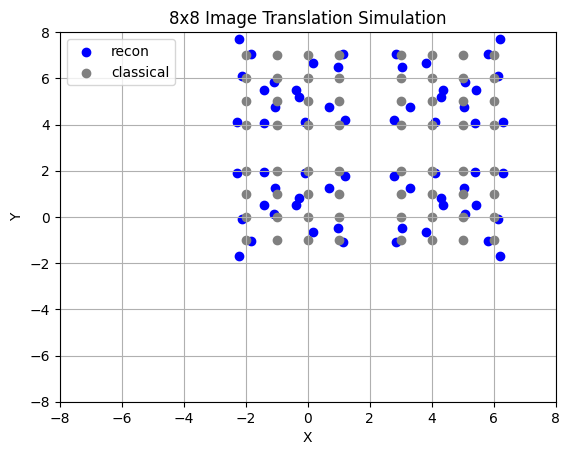

Error =  [0.2979474828017571, 0.38735046220549096, 0.4932126981515781, 0.15498916731234064, 0.1493086718016923, 0.3515843942688554, 0.6154031852871846, 0.3757990576674337, 0.4080501952025471, 0.24504987122855784, 0.15981377726992982, 0.8288549002047128, 0.3058623120482283, 1.0924301115176176, 0.7800348658979109, 0.7226037103203319]
MSE =  0.46051842894913564


In [766]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

P_tra = []
size_list=  []
k_list = []
radius = []
for i in Q_tra:
    sphere = project(i,n)
    P_tra.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

phis_tra = []
for i in range(len(P_tra)):
    phi = round(np.arctan2(P_tra[i][1], P_tra[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_tra.append(phi)
    else:
        phi = round(phi/4,4)
        phis_tra.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

thetas_tra = []
for i in range(len(P_tra)):
    theta = round(np.arccos(P_tra[i][2])/2,4)
    thetas_tra.append(theta)

thetas_del = []
phis_del = []
for i in range(len(thetas)):
    theta_del = round(thetas_tra[i]-thetas[i],4)
    thetas_del.append(theta_del)
    phi_del = round(phis_tra[i]-phis[i],4)
    phis_del.append(phi_del)

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])

        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)

for i, (phi, theta) in enumerate(zip(phis_del, thetas_del)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=66560)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []
pixel_theta = []
pixel_phi = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

#theta_state_0.append(('010001', 0))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))
print(recon_pixel)
back_recon_pixel= []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel[i][0] / k
    Y = recon_pixel[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)
#back_recon_pixel = list(reversed(back_recon_pixel))
end = time.time()
print(f"{end - start:.5f} sec")

back_2 = [y_axis_transition(point,3) for point in back_recon_pixel]
back_3 = [origin_transition(point,2,3) for point in back_recon_pixel]
back_4 = [x_axis_transition(point,2) for point in back_recon_pixel]

x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_Q_tra = [point[0] for point in Q_tra]
y_Q_tra = [point[1] for point in Q_tra]

x_Q_tra2 = [point[0] for point in back_2]
y_Q_tra2 = [point[1] for point in back_2]

x_Q_tra3 = [point[0] for point in back_3]
y_Q_tra3 = [point[1] for point in back_3]

x_Q_tra4 = [point[0] for point in back_4]
y_Q_tra4 = [point[1] for point in back_4]

origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)
origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)
Q_oritin_tra = Transition(Q_origin,2,3)

x_Q_origin_tra = [point[0] for point in Q_oritin_tra]
y_Q_origin_tra = [point[1] for point in Q_oritin_tra]

# 시각화
plt.scatter(x_values, y_values, color='blue', label='recon')
plt.scatter(x_Q_tra2, y_Q_tra2, color='blue')
plt.scatter(x_Q_tra3, y_Q_tra3, color='blue')
plt.scatter(x_Q_tra4, y_Q_tra4, color='blue')
plt.scatter(x_Q_origin_tra, y_Q_origin_tra, color='gray', label = 'classical')
plt.title('8x8 Image Translation Simulation')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.grid(True)
plt.show()

error = []
for i in range(len(Q)):
    del_x = x_Q_tra[i] - x_values[i]
    del_y = y_Q_tra[i] - y_values[i]
    err = del_x**2+del_y**2
    error.append(np.sqrt(err))

MSE = sum(error)/len(Q)
print("=============================")
print("Error = ",error)
print("=============================")
print("MSE = ",MSE)

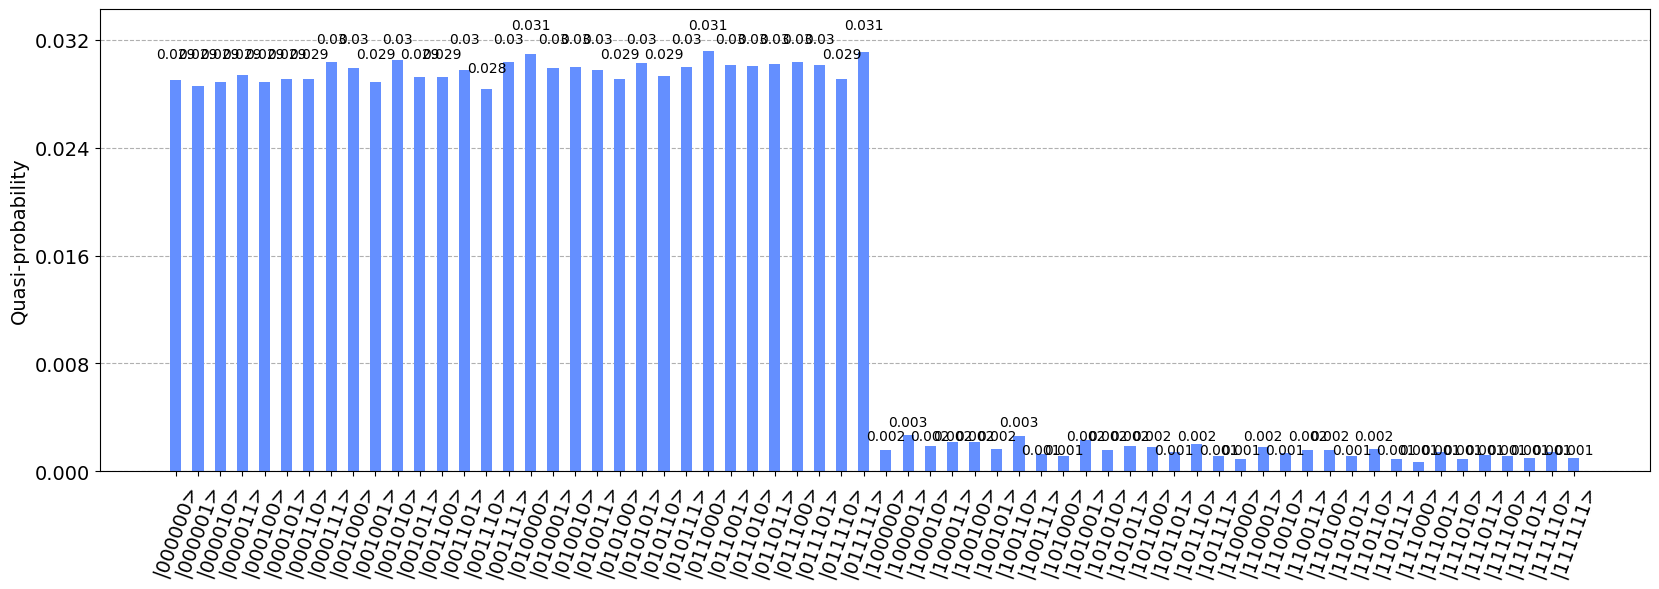

In [107]:
simul_8by8_tra = {}
for i in counts:
    simul_8by8_tra[f"|{i}>"]=counts[i] / 200000
plot_histogram(simul_8by8_tra, figsize=(20,6))

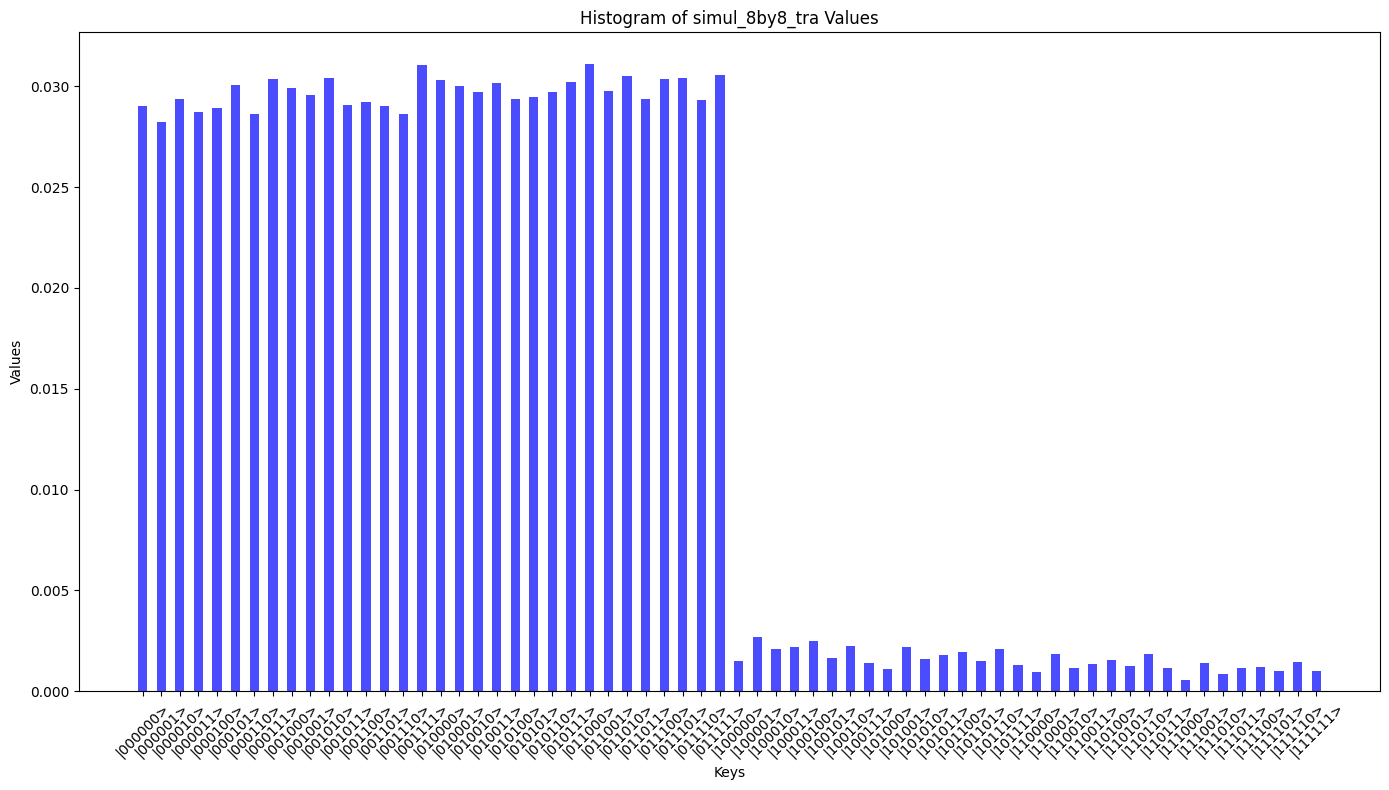

In [104]:
sorted_keys = sorted(simul_8by8_tra.keys())
sorted_values = [simul_8by8_tra[key] for key in sorted_keys]

# 막대 그래프 그리기
plt.figure(figsize=(14, 8))
plt.bar(sorted_keys, sorted_values, color='blue', alpha=0.7, width=0.5)

# 그래프 제목과 축 레이블 설정
plt.title('Histogram of simul_8by8_tra Values')
plt.xlabel('Keys')
plt.ylabel('Values')

# X축의 레이블이 겹치지 않도록 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()  # 레이아웃 조정
plt.show()

### Iteration에 따른 오차 분석

In [740]:
Q_tra = Transition(Q,2,3)

In [744]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

P_tra = []
size_list=  []
k_list = []
radius = []
for i in Q_tra:
    sphere = project(i,n)
    P_tra.append(sphere)
    
phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

phis_tra = []
for i in range(len(P_tra)):
    phi = round(np.arctan2(P_tra[i][1], P_tra[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_tra.append(phi)
    else:
        phi = round(phi/4,4)
        phis_tra.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

thetas_tra = []
for i in range(len(P_tra)):
    theta = round(np.arccos(P_tra[i][2])/2,4)
    thetas_tra.append(theta)

thetas_del = []
phis_del = []
for i in range(len(thetas)):
    theta_del = round(thetas_tra[i]-thetas[i],4)
    thetas_del.append(theta_del)
    phi_del = round(phis_tra[i]-phis[i],4)
    phis_del.append(phi_del)

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])

        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)

for i, (phi, theta) in enumerate(zip(phis_del, thetas_del)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterMSE = []
for iter in range(500):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc_image, aer_sim)
    qobj = assemble(t_qc, shots=1024*(iter+1))
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()

    pixel_theta_recon = []
    pixel_phi_recon = []

    pixel_theta = []
    pixel_phi = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            decision = int(key[-1])
            bin_coord = key[1:-1]
            int_coord = int(bin_coord, 2)
            if int_coord == i and decision == 1:
                pixel_theta.append((state,bin_coord, amount))
            elif int_coord == i and decision == 0:
                pixel_phi.append((state,bin_coord, amount))

    # ======================== phi ====================================
    phi_result_dict = {}
    for state in pixel_phi:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict:
            phi_result_dict[key] += value  
        else:
            phi_result_dict[key] = value  

    phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
    #print(phi_result_list)

    phi_state_0 = []
    for state, phi, amount in pixel_phi:
        if not int(state):
            phi_state_0.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
            pixel_phi_recon.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict = {}
    for state in pixel_theta:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict:
            theta_result_dict[key] += value  
        else:
            theta_result_dict[key] = value  

    theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

    theta_state_0 = []

    for state, theta, amount in pixel_theta:
        if not int(state):
            theta_state_0.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
            pixel_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_pixel = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        z = np.cos(pixel_theta_recon[i])
        recon_pixel.append(np.array([x,y,z]))
    print(recon_pixel)
    back_recon_pixel= []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel[i][0] / k
        Y = recon_pixel[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel.append(back_P)
    #back_recon_pixel = list(reversed(back_recon_pixel))

    end = time.time()
    print(f"{end - start:.5f} sec")

    x_values = [point[0] for point in back_recon_pixel]
    y_values = [point[1] for point in back_recon_pixel]

    x_Q_tra = [point[0] for point in Q_tra]
    y_Q_tra = [point[1] for point in Q_tra]
    '''
    origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)
    origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
    origin_input_tuple = origin_img_mean.shape
    Q_origin = generate_coordinates(origin_input_tuple)
    Q_oritin_tra = Transition(Q_origin,2,3)

    x_Q_origin_tra = [point[0] for point in Q_oritin_tra]
    y_Q_origin_tra = [point[1] for point in Q_oritin_tra]
    '''
    error = []
    for j in range(len(Q)):
        del_x = x_Q_tra[j] - x_values[j]
        del_y = y_Q_tra[j] - y_values[j]
        err = del_x**2+del_y**2
        error.append(np.sqrt(err))
    MSE = sum(error)/len(Q)
    iterMSE.append(MSE) 

    print("iteration = ",(iter+1)*1024)
    print("MSE = ", MSE)
    print("==========================================================================")

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\1585714447.py:153: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


[array([0.35179988, 0.30289776, 0.88571429]), array([0.3731693 , 0.35503633, 0.85714286]), array([0.18486718, 0.29481838, 0.9375    ]), array([0.24313729, 0.41863977, 0.875     ]), array([0.3122499, 0.       , 0.95     ]), array([0.09372955, 0.43664717, 0.89473684]), array([0.19482101, 0.54094666, 0.81818182]), array([0., 0., 1.]), array([0., 0., 1.]), array([0.34283965, 0.        , 0.93939394]), array([0., 0., 1.]), array([0.46423077, 0.        , 0.88571429]), array([0.25259074, 0.27194304, 0.92857143]), array([0.41075867, 0.38045592, 0.82857143]), array([0.53293871, 0.        , 0.84615385]), array([0., 0., 1.])]
0.41285 sec
iteration =  1024
MSE =  4.756591099256941
[array([0.06108279, 0.55654136, 0.82857143]), array([0.27150168, 0.22617862, 0.93548387]), array([0.00180674, 0.24803261, 0.96875   ]), array([0., 0., 1.]), array([0.26401069, 0.20327017, 0.94285714]), array([0.40076465, 0.33036307, 0.85454545]), array([0.42916564, 0.        , 0.90322581]), array([0.22717576, 0.25676877, 

In [745]:
iters = []
for iter in range(500):
    iters.append((iter+1)*1024)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterMSE,
                   "Margin" : [0.5]*500})
df

Iterations       MSE  Margin
0          1024  4.756591     0.5
1          2048  3.891349     0.5
2          3072  2.376167     0.5
3          4096  1.785299     0.5
4          5120  1.918451     0.5
..          ...       ...     ...
495      507904  0.124184     0.5
496      508928  0.168037     0.5
497      509952  0.161763     0.5
498      510976  0.146138     0.5
499      512000  0.171729     0.5

[500 rows x 3 columns]

In [754]:
df.to_excel("8by8 Image Translation Simulation only position.xlsx")

## IonQ

[array([0.33386071, 0.44520784, 0.8308592 ]), array([0.22933483, 0.47355485, 0.85038306]), array([0.27037257, 0.36630251, 0.89034889]), array([0.14842329, 0.33932758, 0.92888499]), array([0.36557324, 0.37984793, 0.84974805]), array([0.2760529 , 0.36437383, 0.88939671]), array([0.26555191, 0.352148  , 0.89748201]), array([0.18138863, 0.33489961, 0.92462988]), array([0.38953433, 0.28180383, 0.8768407 ]), array([0.29596278, 0.3017752 , 0.90627687]), array([0.24464208, 0.25353079, 0.93588054]), array([0.21282463, 0.30796217, 0.92728905]), array([0.35014012, 0.24435111, 0.90426458]), array([0.29423024, 0.25562899, 0.92091388]), array([0.2665243, 0.2399297, 0.9334873]), array([0.20205733, 0.23661527, 0.95036101])]
8.86946 sec


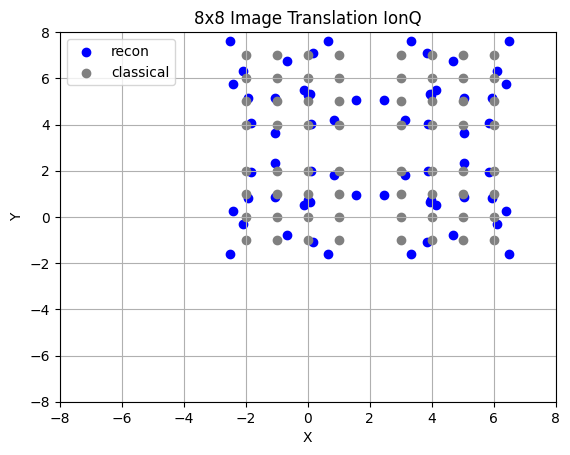

Error =  [0.2474031885524932, 0.5557519554151432, 1.1496728176681101, 0.70707815598846, 0.12271930319333299, 0.25966541472269555, 0.5342405820491908, 0.18350708497932847, 0.35082230984821355, 0.14871134503209332, 1.1379897483741672, 0.401201917084533, 0.17809522587644816, 0.17194465379004129, 0.46660453855902206, 0.7882570957743855]
MSE =  0.4627290835567287


In [767]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

P_tra = []
size_list=  []
k_list = []
radius = []
for i in Q_tra:
    sphere = project(i,n)
    P_tra.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

phis_tra = []
for i in range(len(P_tra)):
    phi = round(np.arctan2(P_tra[i][1], P_tra[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_tra.append(phi)
    else:
        phi = round(phi/4,4)
        phis_tra.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

thetas_tra = []
for i in range(len(P_tra)):
    theta = round(np.arccos(P_tra[i][2])/2,4)
    thetas_tra.append(theta)

thetas_del = []
phis_del = []
for i in range(len(thetas)):
    theta_del = round(thetas_tra[i]-thetas[i],4)
    thetas_del.append(theta_del)
    phi_del = round(phis_tra[i]-phis[i],4)
    phis_del.append(phi_del)

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])

        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)

for i, (phi, theta) in enumerate(zip(phis_del, thetas_del)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=71936)
result = job.result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []
pixel_theta = []
pixel_phi = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

#theta_state_0.append(('010001', 0))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))
print(recon_pixel)
back_recon_pixel= []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel[i][0] / k
    Y = recon_pixel[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)
#back_recon_pixel = list(reversed(back_recon_pixel))
end = time.time()
print(f"{end - start:.5f} sec")

back_2 = [y_axis_transition(point,3) for point in back_recon_pixel]
back_3 = [origin_transition(point,2,3) for point in back_recon_pixel]
back_4 = [x_axis_transition(point,2) for point in back_recon_pixel]

x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_Q_tra = [point[0] for point in Q_tra]
y_Q_tra = [point[1] for point in Q_tra]

x_Q_tra2 = [point[0] for point in back_2]
y_Q_tra2 = [point[1] for point in back_2]

x_Q_tra3 = [point[0] for point in back_3]
y_Q_tra3 = [point[1] for point in back_3]

x_Q_tra4 = [point[0] for point in back_4]
y_Q_tra4 = [point[1] for point in back_4]

origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)
origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)
Q_oritin_tra = Transition(Q_origin,2,3)

x_Q_origin_tra = [point[0] for point in Q_oritin_tra]
y_Q_origin_tra = [point[1] for point in Q_oritin_tra]

# 시각화
plt.scatter(x_values, y_values, color='blue', label='recon')
plt.scatter(x_Q_tra2, y_Q_tra2, color='blue')
plt.scatter(x_Q_tra3, y_Q_tra3, color='blue')
plt.scatter(x_Q_tra4, y_Q_tra4, color='blue')
plt.scatter(x_Q_origin_tra, y_Q_origin_tra, color='gray', label = 'classical')
plt.title('8x8 Image Translation IonQ')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.grid(True)
plt.show()

error = []
for i in range(len(Q)):
    del_x = x_Q_tra[i] - x_values[i]
    del_y = y_Q_tra[i] - y_values[i]
    err = del_x**2+del_y**2
    error.append(np.sqrt(err))

MSE = sum(error)/len(Q)
print("=============================")
print("Error = ",error)
print("=============================")
print("MSE = ",MSE)

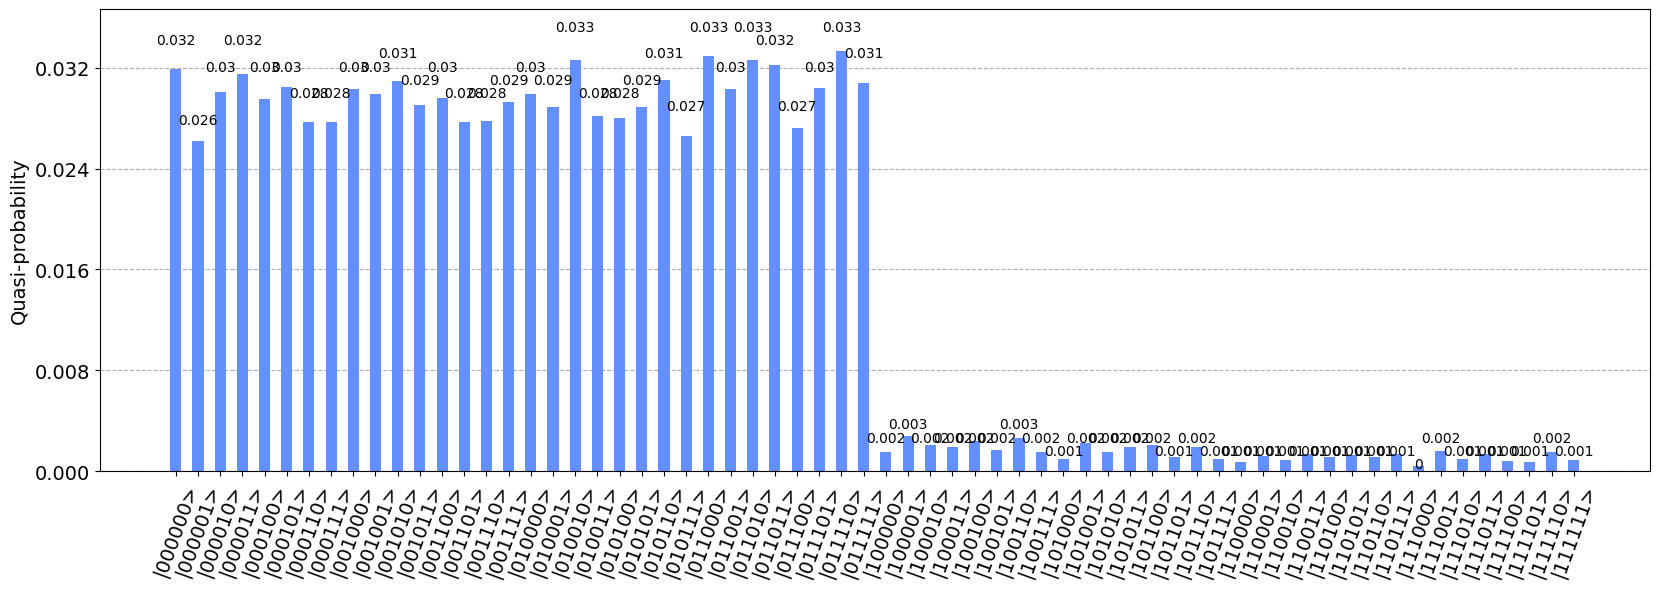

In [189]:
ionq_8by8_tra = {}
for i in counts:
    ionq_8by8_tra[f"|{i}>"]=counts[i] / 10000
plot_histogram(ionq_8by8_tra, figsize=(20,6))

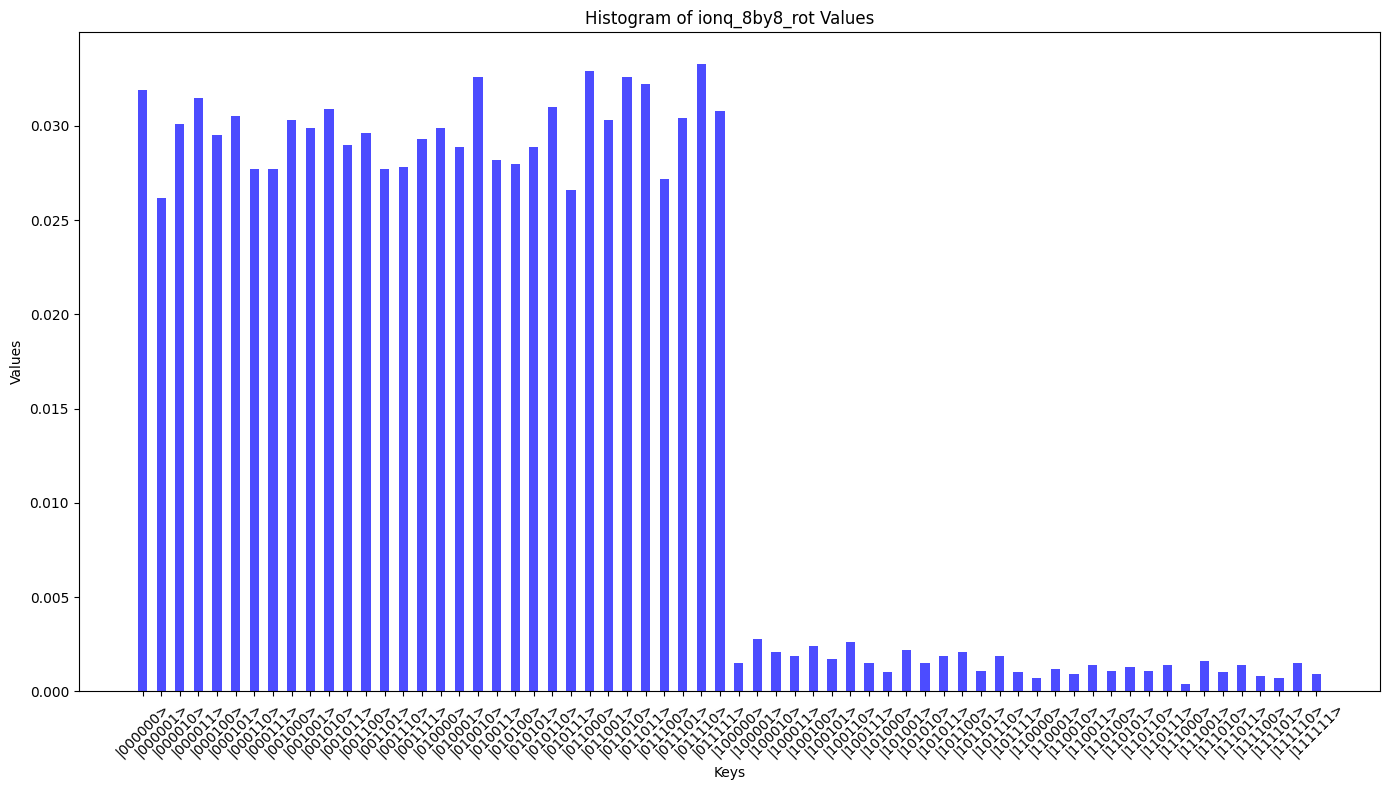

In [190]:
sorted_keys = sorted(ionq_8by8_tra.keys())
sorted_values = [ionq_8by8_tra[key] for key in sorted_keys]

# 막대 그래프 그리기
plt.figure(figsize=(14, 8))
plt.bar(sorted_keys, sorted_values, color='blue', alpha=0.7, width=0.5)

# 그래프 제목과 축 레이블 설정
plt.title('Histogram of ionq_8by8_rot Values')
plt.xlabel('Keys')
plt.ylabel('Values')

# X축의 레이블이 겹치지 않도록 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()  # 레이아웃 조정
plt.show()

### Iteration에 따른 성능 분석

In [193]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

P_tra = []
size_list=  []
k_list = []
radius = []
for i in Q_tra:
    sphere = project(i,n)
    P_tra.append(sphere)
    
phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

phis_tra = []
for i in range(len(P_tra)):
    phi = round(np.arctan2(P_tra[i][1], P_tra[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_tra.append(phi)
    else:
        phi = round(phi/4,4)
        phis_tra.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

thetas_tra = []
for i in range(len(P_tra)):
    theta = round(np.arccos(P_tra[i][2])/2,4)
    thetas_tra.append(theta)

thetas_del = []
phis_del = []
for i in range(len(thetas)):
    theta_del = round(thetas_tra[i]-thetas[i],4)
    thetas_del.append(theta_del)
    phi_del = round(phis_tra[i]-phis[i],4)
    phis_del.append(phi_del)

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])

        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)

for i, (phi, theta) in enumerate(zip(phis_del, thetas_del)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterMSE = []
for iter in range(400):
    ionq_sim = provider.get_backend("ionq_simulator")
    t_qc_image = transpile(qc_image, ionq_sim)
    job = ionq_sim.run(t_qc_image, shots=256*(iter+1))
    result = job.result()
    counts = result.get_counts()

    pixel_theta_recon = []
    pixel_phi_recon = []

    pixel_theta = []
    pixel_phi = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            decision = int(key[-1])
            bin_coord = key[1:-1]
            int_coord = int(bin_coord, 2)
            if int_coord == i and decision == 1:
                pixel_theta.append((state,bin_coord, amount))
            elif int_coord == i and decision == 0:
                pixel_phi.append((state,bin_coord, amount))

    # ======================== phi ====================================
    phi_result_dict = {}
    for state in pixel_phi:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict:
            phi_result_dict[key] += value  
        else:
            phi_result_dict[key] = value  

    phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
    #print(phi_result_list)

    phi_state_0 = []
    for state, phi, amount in pixel_phi:
        if not int(state):
            phi_state_0.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
            pixel_phi_recon.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict = {}
    for state in pixel_theta:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict:
            theta_result_dict[key] += value  
        else:
            theta_result_dict[key] = value  

    theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

    theta_state_0 = []

    for state, theta, amount in pixel_theta:
        if not int(state):
            theta_state_0.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
            pixel_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_pixel = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
        z = np.cos(pixel_theta_recon[i])
        recon_pixel.append(np.array([x,y,z]))
    print(recon_pixel)
    back_recon_pixel= []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel[i][0] / k
        Y = recon_pixel[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel.append(back_P)
    #back_recon_pixel = list(reversed(back_recon_pixel))

    end = time.time()
    print(f"{end - start:.5f} sec")

    x_values = [point[0] for point in back_recon_pixel]
    y_values = [point[1] for point in back_recon_pixel]

    x_Q_tra = [point[0] for point in Q_tra]
    y_Q_tra = [point[1] for point in Q_tra]
    '''
    origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)
    origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
    origin_input_tuple = origin_img_mean.shape
    Q_origin = generate_coordinates(origin_input_tuple)
    Q_oritin_tra = Transition(Q_origin,2,3)

    x_Q_origin_tra = [point[0] for point in Q_oritin_tra]
    y_Q_origin_tra = [point[1] for point in Q_oritin_tra]
    '''
    error = []
    for j in range(len(Q)):
        del_x = x_Q_tra[j] - x_values[j]
        del_y = y_Q_tra[j] - y_values[j]
        err = del_x**2+del_y**2
        error.append(np.sqrt(err))
    MSE = sum(error)/len(Q)
    iterMSE.append(MSE) 

    print("iteration = ",(iter+1)*256)
    print("MSE = ", MSE)
    print("==========================================================================")

[array([0., 0., 1.]), array([0.8, 0. , 0.6]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0.69985421, 0.        , 0.71428571]), array([0.66143783, 0.        , 0.75      ]), array([0.74535599, 0.        , 0.66666667]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([-0.07349309,  0.6573422 ,  0.75      ]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.])]
9.18520 sec
iteration =  256
MSE =  6.867297133315805
[array([-0.14039947,  0.40211178,  0.9047619 ]), array([0., 0., 1.]), array([-0.02207438,  0.53248135,  0.84615385]), array([0., 0., 1.]), array([0.74535599, 0.        , 0.66666667]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0.49888765, 0.        , 0.86666667]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0.51507875, 0.        , 0.85714286]), array([0.23417175, 0.44051388, 0.86666667]), array([-0.,  0.,  1.]), array([0., 0., 1.])]
20.63672 sec
iter

In [195]:
iters = []
for iter in range(400):
    iters.append((iter+1)*256)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterMSE,
                   "Margin" : [0.5]*400})
df.to_excel("8by8 Image Translation IonQ only position.xlsx")

## Color Mapping

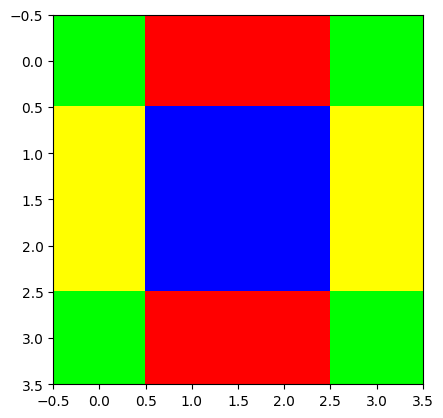

In [350]:
import os
os.path.abspath('')
image = 'color_sample_4x4.png'
image = os.path.join(os.path.abspath(''),
                            image)
image = np.array(Image.open(image))
plt.imshow(image, cmap = 'gray')

In [360]:
image_transform = np.rot90(image, k=1)
image_resize = np.flipud(image_transform.reshape(-1,3))

In [10]:
n = 255
k = 0
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi_color = round(np.arctan2(y,x),4) / 2
theta_color = round(np.arccos(z),4) / 2

In [13]:
thetas

[0.5136, 0.5136, 0.5136, 0.5136]

In [11]:
print(theta_color, phi_color)

0.7854 0.0


C:\Users\HCI\AppData\Local\Temp\ipykernel_18672\4287815518.py:60: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


0 th pixel phi, theta angle 45.10359839397003 58.67900734377537
1 th pixel phi, theta angle 315.07254957114964 58.51089022965832
2 th pixel phi, theta angle 135.1941280823449 58.53489965235412
3 th pixel phi, theta angle 226.03644320550728 59.21140370974862
[array([0.60296579, 0.60515023, 0.51983214]), array([ 0.60374088, -0.60221386,  0.52233649]), array([-0.60517263,  0.6010856 ,  0.52197911]), array([-0.59636129, -0.61833678,  0.51187189])]


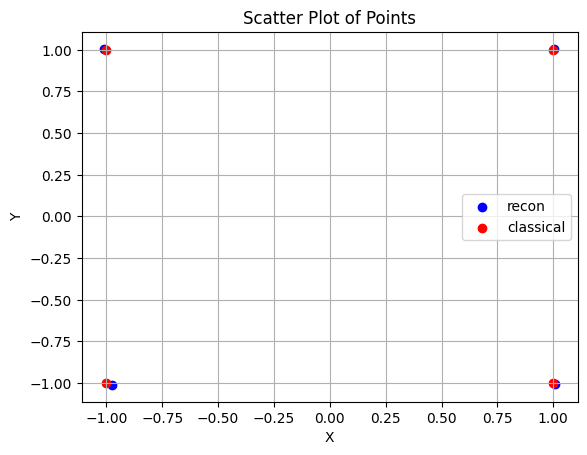

In [8]:
c = QuantumRegister(1)
O = QuantumRegister(w_bits+h_bits)
p = QuantumRegister(1)
color = QuantumRegister(1)
cr = ClassicalRegister(c.size+O.size+p.size+color.size,"classical")

qc_image = QuantumCircuit(c,O,p,color, cr)
qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]])

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
# color value mapping
qc_image.x(color)
qc_image.barrier()
for i, (phi_color, theta_color) in enumerate(zip(phi_colors, theta_colors)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta_color,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi_color,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.barrier()
qc_image.x(color)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

# Measurement
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

for i in range(len(pixel_phi_recon)):
    print(f"{i} th pixel phi, theta angle",pixel_phi_recon[i] * 180 / np.pi, pixel_theta_recon[i] * 180 / np.pi)



recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))
print(recon_pixel)
back_recon_pixel= []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel[i][0] / k
    Y = recon_pixel[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)
back_recon_pixel = list(reversed(back_recon_pixel))
x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]
# 시각화
plt.scatter(x_values, y_values, color='blue', label='recon')
plt.scatter(x_Q, y_Q, color='red', label = 'classical')
plt.title('Scatter Plot of Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


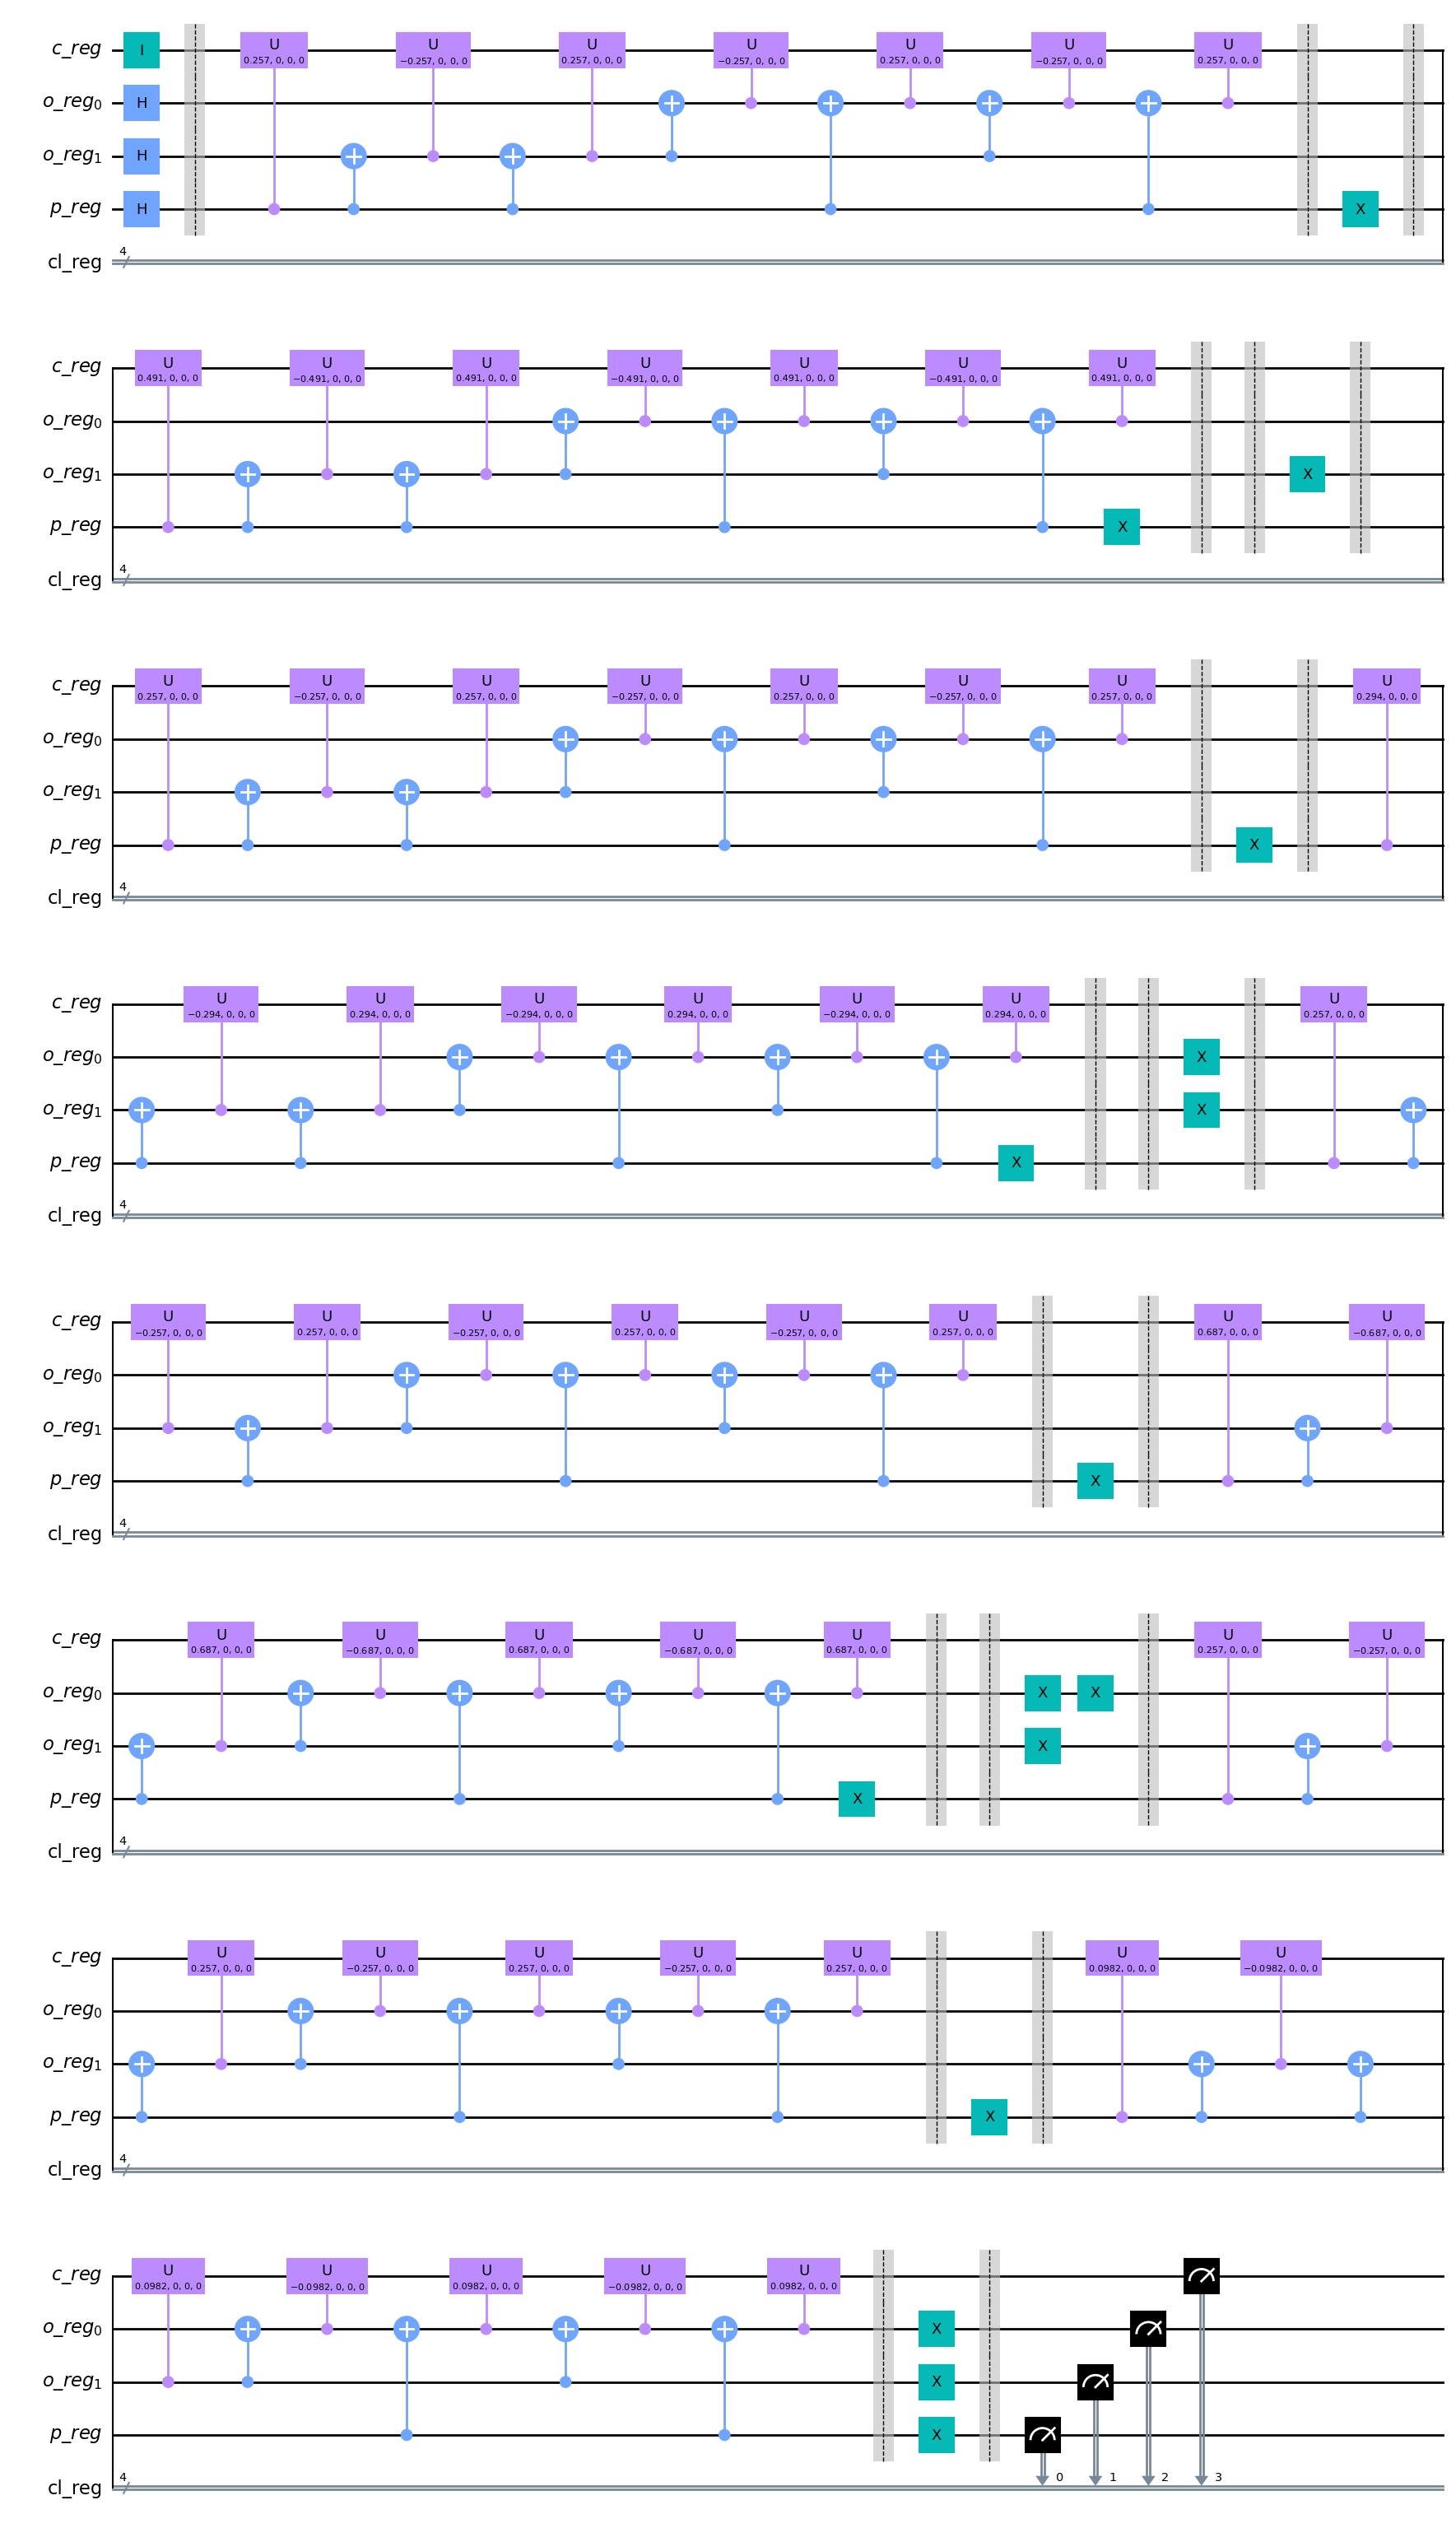

In [9]:
qc_image.draw('mpl')

In [20]:
n = 200
k = 100
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi_origin = round(np.arctan2(y,x),4) / 2
theta_origin = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

phi_err = []
theta_err = []
total_err = []
recon_color_list = []
recon_color_err = []
delta_color = []
for iter in range(2000):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=100*(iter+10))
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()
    pixel_color_theta_recon = []
    pixel_color_phi_recon = []

    pixel_color_theta = []
    pixel_color_phi = []

    for i in range(0, 1):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[-1]
            decision = int(key[0])
            bin_coord = key[1:-1]

            if decision == 1:
                pixel_color_theta.append((state, amount))
            elif decision == 0:
                pixel_color_phi.append((state, amount))

    # ======================== phi ====================================
    total_phi_value = 0
    for state in pixel_color_phi:
        state_value = state[1]
        total_phi_value += state_value

    phi_state_0 = []
    for phi, amount in pixel_color_phi:
        if not int(phi):
            phi_state_0.append((phi, amount))

    for i in range(1):
        try:
            phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
            pixel_color_phi_recon.append(phi*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================

    total_theta_value = 0
    for state in pixel_color_theta:
        state_value = state[1]
        total_theta_value += state_value

    theta_state_0 = []
    for theta, amount in pixel_color_theta:
        if not int(theta):
            theta_state_0.append((theta, amount))

    for i in range(1):
        try:
            theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
            pixel_color_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_color = []
    for i in range(len(pixel_color_phi_recon)):
        n_recon = round(pixel_color_theta_recon[i] * 1020 / np.pi,5)
        k_recon = round(pixel_color_phi_recon[i] * 6 * n_recon / np.pi,5)

        if phi <= 0.5236:
            recon_color.append(np.array([n_recon,k_recon,0]))
        ''''
        elif 0.5236 < phi <= 0.5236*2:
            recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
        elif 0.5236*2 < phi <= 0.5236*3:
            recon_color.append(np.array([0,n_recon,k_recon]))
        elif 0.5236*3 < phi <= 0.5236*4:
            recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
        elif 0.5236*4 < phi <= 0.5236*5:
            recon_color.append(np.array([k_recon,0,n_recon]))
        elif 0.5236*5 < phi <= 0.5236*6:
            recon_color.append(np.array([n_recon,0,n_recon-k_recon]))
        '''

    print("iteration = ",(iter+10)*100)
    print("phi_recon = ",pixel_color_phi_recon[0])
    print("theta_recon = ",pixel_color_theta_recon[0])

    phi_err.append(abs(pixel_color_phi_recon[0]-phi_origin))
    theta_err.append(abs(pixel_color_theta_recon[0]-theta_origin))
    total_err.append(abs(pixel_color_phi_recon[0]-phi_origin) + abs(pixel_color_theta_recon[0]-theta_origin))
    recon_color_list.append(recon_color)
    recon_color_err.append(abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    delta_color.append([round(list(recon_color[0])[0]-200,5),round(list(recon_color[0])[1]-100,5),0])
    print("Reconstructed color = ",recon_color)
    print("Delta Color r= ",delta_color)
    print("Color Error = ",abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    print("==========================================================================")

print("phi_err = ", phi_err)
print("theta_err = ",theta_err)

C:\Users\HCI\AppData\Local\Temp\ipykernel_18672\2449615712.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


iteration =  1000
phi_recon =  0.2685998095767139
theta_recon =  0.6711089685429331
Reconstructed color =  [array([217.89303, 111.77648,   0.     ])]
Delta Color r=  [[17.89303, 11.77648, 0]]
Color Error =  29.669510000000017
iteration =  1100
phi_recon =  0.27174958468624544
theta_recon =  0.577485815908004
Reconstructed color =  [array([187.49583,  97.31099,   0.     ])]
Delta Color r=  [[17.89303, 11.77648, 0], [-12.50417, -2.68901, 0]]
Color Error =  15.193179999999984
iteration =  1200
phi_recon =  0.30491824723927036
theta_recon =  0.6640200743910484
Reconstructed color =  [array([215.59144, 125.54988,   0.     ])]
Delta Color r=  [[17.89303, 11.77648, 0], [-12.50417, -2.68901, 0], [15.59144, 25.54988, 0]]
Color Error =  41.14132000000001
iteration =  1300
phi_recon =  0.26399845503201336
theta_recon =  0.6154021562493932
Reconstructed color =  [array([199.80636, 100.74235,   0.     ])]
Delta Color r=  [[17.89303, 11.77648, 0], [-12.50417, -2.68901, 0], [15.59144, 25.54988, 0], [

KeyboardInterrupt: 

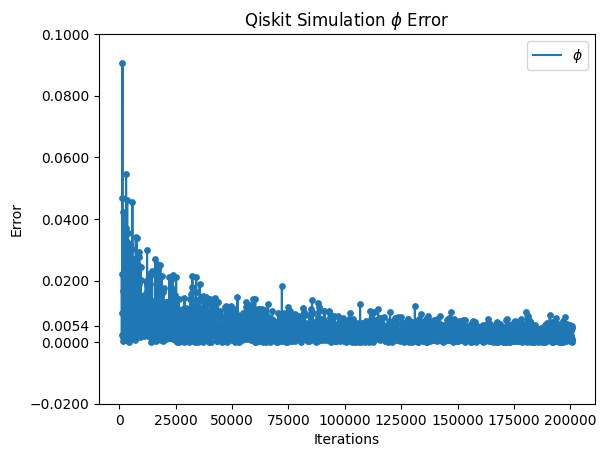

In [16]:
iters = []
for iter in range(2001):
    iters.append((iter+10)*100)

phi_list_2000 = list(enumerate(phi_err))


plt.title("Qiskit Simulation $\phi$ Error")
plt.scatter(iters,phi_err,s=15)
plt.plot(iters,phi_err, label = "$\phi$")

'''
for err in phi_list_2000:
    if err[1] < 0.001314:
        plt.scatter((err[0]+10)*100, err[1],s=15, color="cyan")
'''
specific_y_value = phi_err[-1]

# 현재 y축 틱 값 가져오기
current_ticks = plt.yticks()[0]

# 새로운 y축 틱 값 설정 (기존 값에 특정 값을 추가)
new_ticks = np.append(current_ticks, specific_y_value)

plt.yticks(new_ticks)
plt.xlabel("Iterations")
plt.ylabel("Error")
#plt.ylim(0,0.01)
plt.legend()
plt.show()

# QIP with Color

## Color Space

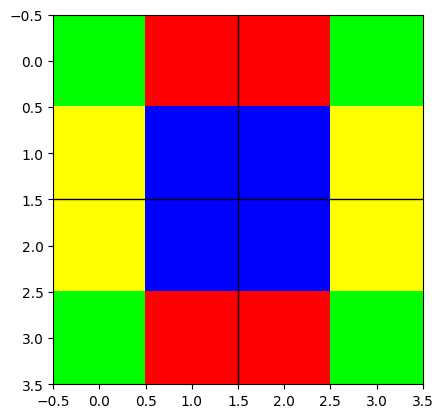

In [80]:
import os
os.path.abspath('')
image = 'rgby.png'
image = os.path.join(os.path.abspath(''),
                            image)
image = np.array(Image.open(image))
plt.imshow(image)
plt.axvline(x=1.5, color='black', linewidth=1)  # 세로선
plt.axhline(y=1.5, color='black', linewidth=1)  # 가로선

# 그래프 보여주기
plt.show()

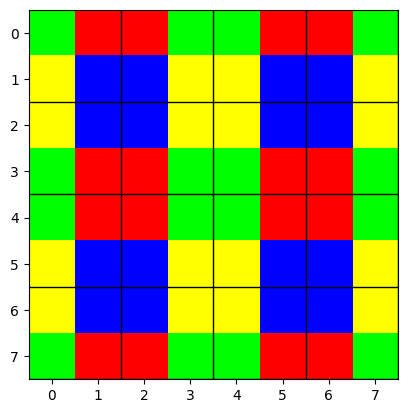

In [93]:
import os
os.path.abspath('')
image = '8by8.png'
image = os.path.join(os.path.abspath(''),
                            image)
image = np.array(Image.open(image))
plt.imshow(image)
plt.axvline(x=1.5, color='black', linewidth=1)  # 세로선
plt.axhline(y=1.5, color='black', linewidth=1)  # 가로선
plt.axvline(x=3.5, color='black', linewidth=1)  # 세로선
plt.axhline(y=3.5, color='black', linewidth=1)  # 가로선
plt.axvline(x=5.5, color='black', linewidth=1)  # 세로선
plt.axhline(y=5.5, color='black', linewidth=1)  # 가로선
plt.axvline(x=7.5, color='black', linewidth=1)  # 세로선
plt.axhline(y=7.5, color='black', linewidth=1)  # 가로선
# 그래프 보여주기
plt.show()

[[[233  10  86]
  [ 36 101 203]
  [131 221 105]
  [ 42  67 101]]

 [[ 30  95  60]
  [229 148 239]
  [188 220 138]
  [125 172 120]]

 [[209  32  25]
  [225 160 158]
  [167 122 229]
  [ 84  38 166]]

 [[ 36 207 148]
  [108 205  11]
  [ 85 224 253]
  [ 76 132 192]]]


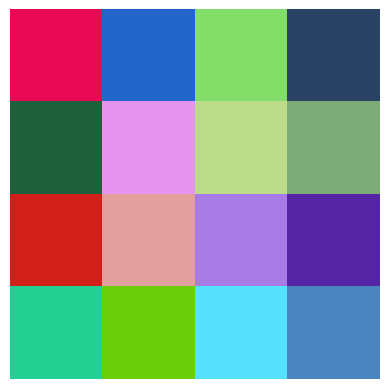

In [197]:
image = np.random.randint(0, 256, size=(4, 4, 3), dtype=np.int64)

plt.imshow(image, cmap = 'gray')
plt.axis('off')
print(image)

In [202]:
image[0][0][0] = 127
image[0][0][1] = 128
image[0][0][2] = 127

In [203]:
image

array([[[127, 128, 127],
        [ 36, 101, 203],
        [131, 221, 105],
        [ 42,  67, 101]],

       [[ 30,  95,  60],
        [229, 148, 239],
        [188, 220, 138],
        [125, 172, 120]],

       [[209,  32,  25],
        [225, 160, 158],
        [167, 122, 229],
        [ 84,  38, 166]],

       [[ 36, 207, 148],
        [108, 205,  11],
        [ 85, 224, 253],
        [ 76, 132, 192]]], dtype=int64)

In [204]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image,1000000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
#print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
#print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
#print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
#print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])
print(pixel_color_theta_recon[0])
print(pixel_color_phi_recon[0])

1.582374193598708
2.0938835855501594


In [243]:
file ='novel color_space_angle120.xlsx'
df = pd.read_excel(file)

theta_filtered = df[ (df['theta left'] < pixel_color_theta_recon[0]) & (df['theta right'] > pixel_color_theta_recon[0])]

result = theta_filtered[ (theta_filtered['phi left']< pixel_color_phi_recon[0]) & (theta_filtered['phi right'] > pixel_color_phi_recon[0])]

result

Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []

In [211]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image,5000000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']

print(pixel_color_theta_recon[0])
print(pixel_color_phi_recon[0])

theta_filtered = df[ (df['theta left'] < pixel_color_theta_recon[0]) & (df['theta right'] > pixel_color_theta_recon[0])]

result = theta_filtered[ (theta_filtered['phi left']< pixel_color_phi_recon[0]) & (theta_filtered['phi right'] > pixel_color_phi_recon[0])]

result

1.5680429070400554
2.1041317145398355


Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right]
Index: []

In [265]:
params = preprocess_image(image)
#print(params)2
for i in range(40):
    counts = create_and_simulate_quantum_circuit(image, 4000000, "simul")
    # 재구성된 값들 추출
    pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)

    print(pixel_color_theta_recon[0])
    print(pixel_color_phi_recon[0])

    theta_filtered = df[ (df['theta left'] < pixel_color_theta_recon[0]) & (df['theta right'] > pixel_color_theta_recon[0])]

    result = theta_filtered[ (theta_filtered['phi left']< pixel_color_phi_recon[0]) & (theta_filtered['phi right'] > pixel_color_phi_recon[0])]
    print(result)
    print("==============================================")

1.5669987884648127
2.1023517426594314
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
1.568326007922518
2.0876439166923046
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
1.56747491446563
2.101616917049113
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
1.566465648636908
2.0869025539161696
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
1.5663374292884005
2.099809402408478
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
1.5692533643388271
2.09911290527881
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi

In [270]:
params = preprocess_image(image)
#print(params)2
for i in range(80):
    counts = create_and_simulate_quantum_circuit(image, 1800000, "simul")
    # 재구성된 값들 추출
    pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
    print("iterations = ",i)
    print(pixel_color_theta_recon[0])
    print(pixel_color_phi_recon[0])

    theta_filtered = df[ (df['theta left'] < pixel_color_theta_recon[0]) & (df['theta right'] > pixel_color_theta_recon[0])]

    result = theta_filtered[ (theta_filtered['phi left']< pixel_color_phi_recon[0]) & (theta_filtered['phi right'] > pixel_color_phi_recon[0])]
    print(result)
    print("==============================================")

iterations =  0
1.562992061691804
2.12009193397678
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  1
1.5665358148184303
2.093657091158652
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  2
1.5603636305603408
2.103363297690175
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  3
1.5722186000663283
2.0870029894054065
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  4
1.5599663029233763
2.1044357428121407
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  5
1.5620661413217314
2.1115284036311

In [271]:
params = preprocess_image(image)
#print(params)2
for i in range(80):
    counts = create_and_simulate_quantum_circuit(image, 1800000, "simul")
    # 재구성된 값들 추출
    pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
    print("iterations = ",i)
    print(pixel_color_theta_recon[0])
    print(pixel_color_phi_recon[0])

    theta_filtered = df[ (df['theta left'] < pixel_color_theta_recon[0]) & (df['theta right'] > pixel_color_theta_recon[0])]

    result = theta_filtered[ (theta_filtered['phi left']< pixel_color_phi_recon[0]) & (theta_filtered['phi right'] > pixel_color_phi_recon[0])]
    print(result)

iterations =  0
1.5745358402024452
2.085302007163088
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  1
1.568649327363991
2.0988524375190423
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  2
1.567525645623081
2.0977028246192733
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  3
1.5799154307078667
2.0903026405590888
        Unnamed: 0            index     theta       phi  theta left  \
361341      361341  [125, 131, 125]  1.579892  2.094395    1.579844   
426622      426622  [126, 130, 126]  1.579940  2.094395    1.579892   

        theta right  phi left  phi right  theta range  phi range  
361341     1.579940  2.086695   2.102152     0.000096   0.015457  
426622     1.579988  2.08669

In [272]:
params = preprocess_image(image)
#print(params)2
for i in range(80):
    counts = create_and_simulate_quantum_circuit(image, 1800000, "simul")
    # 재구성된 값들 추출
    pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
    print("iterations = ",i)
    print(pixel_color_theta_recon[0])
    print(pixel_color_phi_recon[0])

    theta_filtered = df[ (df['theta left'] < pixel_color_theta_recon[0]) & (df['theta right'] > pixel_color_theta_recon[0])]

    result = theta_filtered[ (theta_filtered['phi left']< pixel_color_phi_recon[0]) & (theta_filtered['phi right'] > pixel_color_phi_recon[0])]
    print(result)

iterations =  0
1.5667975900687705
2.097235088038624
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  1
1.5679271365028233
2.0925748952872323
        Unnamed: 0            index     theta       phi  theta left  \
165242      165242  [122, 133, 122]  1.567957  2.094395    1.567909   
230523      230523  [123, 132, 123]  1.567909  2.094395    1.567861   

        theta right  phi left  phi right  theta range  phi range  
165242     1.568005  2.086695   2.102152     0.000096   0.015457  
230523     1.567957  2.086695   2.102152     0.000096   0.015457  
iterations =  2
1.5724347375578376
2.086298220824004
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  3
1.5665664062438265
2.0879741375137093
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi r

In [274]:
params = preprocess_image(image)
#print(params)2
for i in range(80):
    counts = create_and_simulate_quantum_circuit(image, 1800000, "simul")
    # 재구성된 값들 추출
    pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
    print("iterations = ",i)
    print(pixel_color_theta_recon[0])
    print(pixel_color_phi_recon[0])

    theta_filtered = df[ (df['theta left'] < pixel_color_theta_recon[0]) & (df['theta right'] > pixel_color_theta_recon[0])]

    result = theta_filtered[ (theta_filtered['phi left']< pixel_color_phi_recon[0]) & (theta_filtered['phi right'] > pixel_color_phi_recon[0])]
    print(result)

iterations =  0
1.573889225181169
2.0933371501502887
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  1
1.5751619028171786
2.0956247718910603
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  2
1.5650023868673557
2.0958270820794325
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  3
1.566190607878329
2.0977159782487904
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  4
1.5621018044811736
2.094516694615535
Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []
iterations =  5
1.5710803571899674
2.11197694337

In [257]:
params = preprocess_image(image)
counts = create_and_simulate_quantum_circuit(image, 1800000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)

print(pixel_color_theta_recon[0])
print(pixel_color_phi_recon[0])

theta_filtered = df[ (df['theta left'] < pixel_color_theta_recon[0]) & (df['theta right'] > pixel_color_theta_recon[0])]

result = theta_filtered[ (theta_filtered['phi left']< pixel_color_phi_recon[0]) & (theta_filtered['phi right'] > pixel_color_phi_recon[0])]
result

1.5727528575156153
2.097460301083722


Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta range, phi range]
Index: []

In [240]:
phi_filtered = df[ (df['phi left'] < pixel_color_phi_recon[0]) & (df['phi right'] > pixel_color_phi_recon[0])]

result = phi_filtered[ (phi_filtered['theta left']< pixel_color_theta_recon[0]) & (phi_filtered['theta right'] > pixel_color_theta_recon[0])]
result

Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right]
Index: []

In [ ]:
output = []
for i in range(len(color_phi)):
    theta_error = np.abs(color_theta[i]-pixel_color_theta_recon[i])
    phi_error = np.abs(color_phi[i]-pixel_color_phi_recon[i])
    num = int(value[i] // 8 + 1)
    file = f'novel color_space_angle{num}.xlsx'
    df = pd.read_excel(file)
    # 1. theta 값이 1.716682보다 크고 1.21783보다 작은 인덱스를 추출
    theta_filtered = df[(df['theta'] < color_theta[i]+theta_error) & (df['theta'] > color_theta[i]-theta_error)]
    # 2. 추출된 인덱스들 중에서 phi 값이 1.903954보다 크고 1.918318보다 작은 인덱스를 추출
    result = theta_filtered[(theta_filtered['phi'] > color_phi[i]-phi_error) & (theta_filtered['phi'] < color_phi[i]+phi_error)]
    final_indices = result['index']
    output.append(final_indices.values[0])
output

In [283]:
nth_row = df.iloc[[337165]]
nth_row

Unnamed: 0        index     theta  theta left  theta right       phi  \
337165      337165  [5, 37, 13]  1.600811    1.600786     1.600835  2.356194   

        phi left  phi right  theta less  theta more  phi less  phi more  
337165   2.35516   2.357221    1.600799    1.600823  2.355677  2.356708

In [316]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image, 2500000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
#print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
#print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
#print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
#print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])
print(pixel_color_theta_recon[-3])
print(pixel_color_phi_recon[-3])
file ='novel color_space_angle1.xlsx'
df = pd.read_excel(file)

previous_3rd_theta = df[df['theta'] < pixel_color_theta_recon[-3]]['theta'].drop_duplicates().nlargest(3).iloc[-1]

# 2. target_theta보다 큰 값 중에서 가장 작은 값의 3번째 값
next_3rd_theta = df[df['theta'] > pixel_color_theta_recon[-3]]['theta'].drop_duplicates().nsmallest(3).iloc[-1]

previous_3rd_phi = df[df['phi'] < pixel_color_phi_recon[-3]]['phi'].drop_duplicates().nlargest(3).iloc[-1]

# 2. target_theta보다 큰 값 중에서 가장 작은 값의 3번째 값
next_3rd_phi = df[df['phi'] > pixel_color_phi_recon[-3]]['phi'].drop_duplicates().nsmallest(3).iloc[-1]

theta_filtered = df[(df['theta less']<previous_3rd_theta) & (df['theta more']>next_3rd_theta)]

result = theta_filtered[ (theta_filtered['phi less']<previous_3rd_phi) & (theta_filtered['phi more']>next_3rd_phi)]

result

1.6019659162439888
2.455873648425855


Empty DataFrame
Columns: [Unnamed: 0, index, theta, theta left, theta right, phi, phi left, phi right, theta less, theta more, phi less, phi more]
Index: []

In [317]:
theta_filtered

Unnamed: 0          index     theta  theta left  theta right  \
394995      394995    [6, 6, 243]  1.601917    1.601892     1.601941   
395251      395251    [6, 7, 243]  1.601917    1.601892     1.601941   
395507      395507    [6, 8, 243]  1.601917    1.601892     1.601941   
395763      395763    [6, 9, 243]  1.601917    1.601892     1.601941   
396019      396019   [6, 10, 243]  1.601917    1.601892     1.601941   
...            ...            ...       ...         ...          ...   
455665      455665  [6, 243, 241]  1.601917    1.601892     1.601941   
455666      455666  [6, 243, 242]  1.601917    1.601892     1.601941   
455667      455667  [6, 243, 243]  1.601917    1.601892     1.601941   
460531      460531    [7, 6, 243]  1.601917    1.601892     1.601941   
520966      520966    [7, 243, 6]  1.601917    1.601892     1.601941   

             phi  phi left  phi right  theta less  theta more  phi less  \
394995  4.188790  4.184684   4.192897    1.601904    1.601929  4.186737   
395251  4.184372  4.184353   4.184390    1.601904    1.601929  4.184362   
395507  4.179953  4.179916   4.179990    1.601904    1.601929  4.179934   
395763  4.175535  4.175478   4.175590    1.601904    1.601929  4.175506   
396019  4.171116  4.171041   4.171141    1.601904    1.601929  4.171079   
...          ...       ...        ...         ...         ...       ...   
455665  3.132756  3.132718   3.132793    1.601904    1.601929  3.132737   
455666  3.137174  3.137155   3.137193    1.601904    1.601929  3.137165   
455667  3.141593  3.137486   3.145699    1.601904    1.601929  3.139539   
460531  4.193209  4.193190   4.193227    1.601904    1.601929  4.193199   
520966  2.089977  2.089958   2.089995    1.601904    1.601929  2.089967   

        phi more  
394995  4.190844  
395251  4.184381  
395507  4.179972  
395763  4.175562  
396019  4.171128  
...          ...  
455665  3.132774  
455666  3.137183  
455667  3.143646  
460531  4.193218  
520966  2.089986  

[477 rows x 12 columns]

In [320]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image, 2500000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
#print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
#print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
#print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
#print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])
print(pixel_color_theta_recon[-3])
print(pixel_color_phi_recon[-3])
file ='novel color_space_angle1.xlsx'
df = pd.read_excel(file)

previous_3rd_theta = df[df['theta'] < pixel_color_theta_recon[-3]]['theta'].drop_duplicates().nlargest(5).iloc[-1]

# 2. target_theta보다 큰 값 중에서 가장 작은 값의 3번째 값
next_3rd_theta = df[df['theta'] > pixel_color_theta_recon[-3]]['theta'].drop_duplicates().nsmallest(5).iloc[-1]

previous_3rd_phi = df[df['phi'] < pixel_color_phi_recon[-3]]['phi'].drop_duplicates().nlargest(5).iloc[-1]

# 2. target_theta보다 큰 값 중에서 가장 작은 값의 3번째 값
next_3rd_phi = df[df['phi'] > pixel_color_phi_recon[-3]]['phi'].drop_duplicates().nsmallest(5).iloc[-1]

theta_filtered = df[(df['theta less']<previous_3rd_theta) & (df['theta more']>next_3rd_theta)]

result = theta_filtered[ (theta_filtered['phi less']<previous_3rd_phi) & (theta_filtered['phi more']>next_3rd_phi)]

result

1.5926278754257155
2.452137069587108


Empty DataFrame
Columns: [Unnamed: 0, index, theta, theta left, theta right, phi, phi left, phi right, theta less, theta more, phi less, phi more]
Index: []

In [321]:
theta_filtered

Unnamed: 0        index     theta  theta left  theta right       phi  \
263291      263291  [4, 4, 123]  1.592527    1.592503     1.592552  4.188790   
263547      263547  [4, 5, 123]  1.592527    1.592503     1.592552  4.179990   
263803      263803  [4, 6, 123]  1.592527    1.592503     1.592552  4.171190   
264059      264059  [4, 7, 123]  1.592527    1.592503     1.592552  4.162390   
264315      264315  [4, 8, 123]  1.592527    1.592503     1.592552  4.153590   
...            ...          ...       ...         ...          ...       ...   
359172      359172  [5, 123, 4]  1.592527    1.592503     1.592552  2.085595   
394363      394363  [6, 4, 123]  1.592527    1.592503     1.592552  4.206390   
424708      424708  [6, 123, 4]  1.592527    1.592503     1.592552  2.076795   
459899      459899  [7, 4, 123]  1.592527    1.592503     1.592552  4.215190   
490244      490244  [7, 123, 4]  1.592527    1.592503     1.592552  2.067995   

        phi left  phi right  theta less  theta more  phi less  phi more  
263291  4.184684   4.192897    1.592515     1.59254  4.186737  4.190844  
263547  4.179953   4.180027    1.592515     1.59254  4.179972  4.180009  
263803  4.171141   4.171239    1.592515     1.59254  4.171166  4.171215  
264059  4.162346   4.162446    1.592515     1.59254  4.162368  4.162418  
264315  4.153548   4.153649    1.592515     1.59254  4.153569  4.153620  
...          ...        ...         ...         ...       ...       ...  
359172  2.085558   2.085632    1.592515     1.59254  2.085577  2.085614  
394363  4.206341   4.206440    1.592515     1.59254  4.206366  4.206415  
424708  2.076746   2.076844    1.592515     1.59254  2.076770  2.076820  
459899  4.215135   4.215235    1.592515     1.59254  4.215162  4.215212  
490244  2.067951   2.068051    1.592515     1.59254  2.067973  2.068023  

[245 rows x 12 columns]

In [325]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image, 5000000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
#print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
#print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
#print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
#print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])
print(pixel_color_theta_recon[-3])
print(pixel_color_phi_recon[-3])
file ='novel color_space_angle1.xlsx'
df = pd.read_excel(file)

previous_3rd_theta = df[df['theta'] < pixel_color_theta_recon[-3]]['theta'].drop_duplicates().nlargest(5).iloc[-1]

# 2. target_theta보다 큰 값 중에서 가장 작은 값의 3번째 값
next_3rd_theta = df[df['theta'] > pixel_color_theta_recon[-3]]['theta'].drop_duplicates().nsmallest(5).iloc[-1]

previous_3rd_phi = df[df['phi'] < pixel_color_phi_recon[-3]]['phi'].drop_duplicates().nlargest(5).iloc[-1]

# 2. target_theta보다 큰 값 중에서 가장 작은 값의 3번째 값
next_3rd_phi = df[df['phi'] > pixel_color_phi_recon[-3]]['phi'].drop_duplicates().nsmallest(5).iloc[-1]

theta_filtered = df[(df['theta less']<previous_3rd_theta) & (df['theta more']>next_3rd_theta)]

result = theta_filtered[ (theta_filtered['phi less']<previous_3rd_phi) & (theta_filtered['phi more']>next_3rd_phi)]

result

1.5981723837910806
2.4425332990775988


Empty DataFrame
Columns: [Unnamed: 0, index, theta, theta left, theta right, phi, phi left, phi right, theta less, theta more, phi less, phi more]
Index: []

In [326]:
theta_filtered

Unnamed: 0          index     theta  theta left  theta right  \
329109      329109    [5, 5, 149]  1.598062    1.598038     1.598087   
329365      329365    [5, 6, 149]  1.598062    1.598038     1.598087   
329621      329621    [5, 7, 149]  1.598062    1.598038     1.598087   
329877      329877    [5, 8, 149]  1.598062    1.598038     1.598087   
330133      330133    [5, 9, 149]  1.598062    1.598038     1.598087   
...            ...            ...       ...         ...          ...   
365973      365973  [5, 149, 149]  1.598062    1.598038     1.598087   
394645      394645    [6, 5, 149]  1.598062    1.598038     1.598087   
431365      431365    [6, 149, 5]  1.598062    1.598038     1.598087   
460181      460181    [7, 5, 149]  1.598062    1.598038     1.598087   
496901      496901    [7, 149, 5]  1.598062    1.598038     1.598087   

             phi  phi left  phi right  theta less  theta more  phi less  \
329109  4.188790  4.184684   4.192897     1.59805    1.598075  4.186737   
329365  4.181518  4.181467   4.181568     1.59805    1.598075  4.181493   
329621  4.174246  4.174178   4.174313     1.59805    1.598075  4.174212   
329877  4.166974  4.166882   4.167064     1.59805    1.598075  4.166928   
330133  4.159701  4.159585   4.159816     1.59805    1.598075  4.159643   
...          ...       ...        ...         ...         ...       ...   
365973  3.141593  3.137486   3.145699     1.59805    1.598075  3.139539   
394645  4.196062  4.196012   4.196113     1.59805    1.598075  4.196037   
431365  2.087123  2.087072   2.087173     1.59805    1.598075  2.087097   
460181  4.203335  4.203268   4.203402     1.59805    1.598075  4.203301   
496901  2.079851  2.079783   2.079918     1.59805    1.598075  2.079817   

        phi more  
329109  4.190844  
329365  4.181543  
329621  4.174279  
329877  4.167019  
330133  4.159759  
...          ...  
365973  3.143646  
394645  4.196088  
431365  2.087148  
460181  4.203368  
496901  2.079884  

[293 rows x 12 columns]

In [343]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image, 3000000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
#print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
#print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
#print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
#print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])
print(pixel_color_theta_recon[-3])
print(pixel_color_phi_recon[-3])
file ='novel color_space_angle1.xlsx'
df = pd.read_excel(file)
theta_filtered = df[(df['theta less']<pixel_color_theta_recon[-3]) & (df['theta more']>pixel_color_theta_recon[-3])]
result = theta_filtered[ (theta_filtered['phi less']<pixel_color_phi_recon[-3]) & (theta_filtered['phi more']>pixel_color_phi_recon[-3])]
result

1.5991476604155463
2.4498965156847117


Empty DataFrame
Columns: [Unnamed: 0, index, theta, theta left, theta right, phi, phi left, phi right, theta less, theta more, phi less, phi more]
Index: []

In [344]:
theta_filtered

Unnamed: 0          index     theta  theta left  theta right  \
329065      329065    [5, 5, 105]  1.599142    1.599118     1.599167   
329321      329321    [5, 6, 105]  1.599142    1.599118     1.599167   
329577      329577    [5, 7, 105]  1.599142    1.599118     1.599167   
329833      329833    [5, 8, 105]  1.599142    1.599118     1.599167   
330089      330089    [5, 9, 105]  1.599142    1.599118     1.599167   
...            ...            ...       ...         ...          ...   
354665      354665  [5, 105, 105]  1.599142    1.599118     1.599167   
394601      394601    [6, 5, 105]  1.599142    1.599118     1.599167   
420101      420101    [6, 105, 5]  1.599142    1.599118     1.599167   
460137      460137    [7, 5, 105]  1.599142    1.599118     1.599167   
485637      485637    [7, 105, 5]  1.599142    1.599118     1.599167   

             phi  phi left  phi right  theta less  theta more  phi less  \
329065  4.188790  4.184684   4.192897     1.59913    1.599154  4.186737   
329321  4.178318  4.178266   4.178370     1.59913    1.599154  4.178292   
329577  4.167846  4.167762   4.167930     1.59913    1.599154  4.167804   
329833  4.157374  4.157329   4.157437     1.59913    1.599154  4.157352   
330089  4.146902  4.146734   4.147069     1.59913    1.599154  4.146818   
...          ...       ...        ...         ...         ...       ...   
354665  3.141593  3.137486   3.145699     1.59913    1.599154  3.139539   
394601  4.199262  4.199210   4.199315     1.59913    1.599154  4.199236   
420101  2.083923  2.083871   2.083975     1.59913    1.599154  2.083897   
460137  4.209734  4.209651   4.209818     1.59913    1.599154  4.209692   
485637  2.073451  2.073367   2.073535     1.59913    1.599154  2.073409   

        phi more  
329065  4.190844  
329321  4.178344  
329577  4.167888  
329833  4.157406  
330089  4.146986  
...          ...  
354665  3.143646  
394601  4.199288  
420101  2.083949  
460137  4.209776  
485637  2.073493  

[205 rows x 12 columns]

In [358]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image, 2500000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
#print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
#print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
#print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
#print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])
print(pixel_color_theta_recon[-3])
print(pixel_color_phi_recon[-3])
file ='novel color_space_angle1.xlsx'
df = pd.read_excel(file)
theta_filtered = df[(df['theta less']<pixel_color_theta_recon[-3]) & (df['theta more']>pixel_color_theta_recon[-3])]
result = theta_filtered[ (theta_filtered['phi less']<pixel_color_phi_recon[-3]) & (theta_filtered['phi more']>pixel_color_phi_recon[-3])]
result

1.5984842774461108
2.4455266885963862


Empty DataFrame
Columns: [Unnamed: 0, index, theta, theta left, theta right, phi, phi left, phi right, theta less, theta more, phi less, phi more]
Index: []

In [363]:
theta_filtered

Unnamed: 0        index     theta  theta left  theta right       phi  \
329032      329032   [5, 5, 72]  1.599952    1.599927     1.599976  4.188790   
329288      329288   [5, 6, 72]  1.599952    1.599927     1.599976  4.173160   
329544      329544   [5, 7, 72]  1.599952    1.599927     1.599976  4.157531   
329800      329800   [5, 8, 72]  1.599952    1.599927     1.599976  4.141901   
330056      330056   [5, 9, 72]  1.599952    1.599927     1.599976  4.126271   
...            ...          ...       ...         ...          ...       ...   
346184      346184  [5, 72, 72]  1.599952    1.599927     1.599976  3.141593   
394568      394568   [6, 5, 72]  1.599952    1.599927     1.599976  4.204420   
411653      411653   [6, 72, 5]  1.599952    1.599927     1.599976  2.078765   
460104      460104   [7, 5, 72]  1.599952    1.599927     1.599976  4.220050   
477189      477189   [7, 72, 5]  1.599952    1.599927     1.599976  2.063135   

        phi left  phi right  theta less  theta more  phi less  phi more  
329032  4.184684   4.192897     1.59994    1.599964  4.186737  4.190844  
329288  4.173082   4.173238     1.59994    1.599964  4.173121  4.173199  
329544  4.157464   4.157597     1.59994    1.599964  4.157497  4.157564  
329800  4.141831   4.141964     1.59994    1.599964  4.141866  4.141933  
330056  4.126209   4.126343     1.59994    1.599964  4.126240  4.126307  
...          ...        ...         ...         ...       ...       ...  
346184  3.137486   3.145699     1.59994    1.599964  3.139539  3.143646  
394568  4.204343   4.204498     1.59994    1.599964  4.204381  4.204459  
411653  2.078687   2.078843     1.59994    1.599964  2.078726  2.078804  
460104  4.219983   4.220117     1.59994    1.599964  4.220017  4.220083  
477189  2.063069   2.063202     1.59994    1.599964  2.063102  2.063169  

[139 rows x 12 columns]

In [401]:
nth_row = df.iloc[[97222]]
nth_row

Unnamed: 0          index     theta       phi  theta left  theta right  \
97222       97222  [1, 123, 198]  0.001401  3.540272    0.001377     0.001425   

       phi left  phi right  theta lower  theta upper  phi lower  phi upper  
97222  3.540242   3.540296     0.001389     0.001413   3.540257   3.540284

In [403]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image, 2500000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
#print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
#print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
#print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
#print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])

print("Reconstructed theta = ",pixel_color_theta_recon[-2]-np.pi/2)
print("Reconstructed phi = ",pixel_color_phi_recon[-2])

file ='A novel color_space_angle1.xlsx'
df = pd.read_excel(file)
theta_filtered = df[(df['theta lower']<pixel_color_theta_recon[-2]-np.pi/2) & (df['theta upper']>pixel_color_theta_recon[-2]-np.pi/2)]
result = theta_filtered[ (theta_filtered['phi lower']<pixel_color_phi_recon[-2]) & (theta_filtered['phi upper']>pixel_color_phi_recon[-2])]
result

Reconstructed theta =  0.005159822664589031
Reconstructed phi =  3.5356466491463165


Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta lower, theta upper, phi lower, phi upper]
Index: []

In [402]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image, 1000000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
#print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
#print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
#print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
#print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])

print("Reconstructed theta = ",pixel_color_theta_recon[-2]-np.pi/2)
print("Reconstructed phi = ",pixel_color_phi_recon[-2])

file ='A novel color_space_angle1.xlsx'
df = pd.read_excel(file)
theta_filtered = df[(df['theta lower']<pixel_color_theta_recon[-2]-np.pi/2) & (df['theta upper']>pixel_color_theta_recon[-2]-np.pi/2)]
result = theta_filtered[ (theta_filtered['phi lower']<pixel_color_phi_recon[-2]) & (theta_filtered['phi upper']>pixel_color_phi_recon[-2])]
result

Reconstructed theta =  -0.003175414964261769
Reconstructed phi =  3.5201952561243655


Empty DataFrame
Columns: [Unnamed: 0, index, theta, phi, theta left, theta right, phi left, phi right, theta lower, theta upper, phi lower, phi upper]
Index: []

In [398]:
print(color_theta[-2]-np.pi/2)
print(color_phi[-2])

0.0014010947628466663
3.534956200739784


[[[169  86  74]
  [124 232  90]
  [107  29  36]
  [118 163  83]]

 [[101 255  89]
  [  1 143 133]
  [210  50 103]
  [205  44 175]]

 [[ 36  86 121]
  [  4 150 107]
  [164  61  44]
  [253 193   1]]

 [[ 88 247  12]
  [250  72 238]
  [  1 123 198]
  [131 164  60]]]


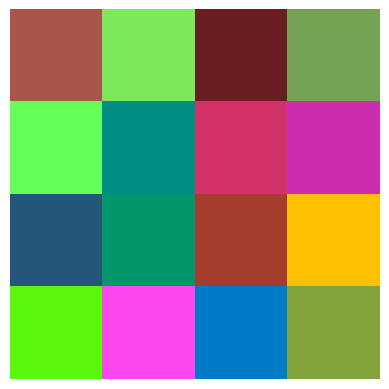

In [369]:
image = np.random.randint(0, 256, size=(4, 4, 3), dtype=np.int64)

plt.imshow(image, cmap = 'gray')
plt.axis('off')
print(image)

In [370]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image, 100000000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
#print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
#print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
#print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
#print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])

print(pixel_color_theta_recon[-2])
print(pixel_color_phi_recon[-2])

file ='novel color_space_angle1_.xlsx'
df = pd.read_excel(file)
theta_filtered = df[(df['theta less']<pixel_color_theta_recon[-2]) & (df['theta more']>pixel_color_theta_recon[-2])]
result = theta_filtered[ (theta_filtered['phi less']<pixel_color_phi_recon[-2]) & (theta_filtered['phi more']>pixel_color_phi_recon[-2])]
result

1.5728503107684377
3.53552222273743


Empty DataFrame
Columns: [Unnamed: 0, index, theta, theta left, theta right, phi, phi left, phi right, theta less, theta more, phi less, phi more]
Index: []

In [379]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image, 100000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
#print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
#print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
#print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
#print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])

print(pixel_color_theta_recon[-2])
print(pixel_color_phi_recon[-2])

file ='novel color_space_angle1_.xlsx'
df = pd.read_excel(file)
theta_filtered = df[(df['theta less']<pixel_color_theta_recon[-2]) and (df['theta more']>pixel_color_theta_recon[-2])]
result = theta_filtered[ (theta_filtered['phi less']<pixel_color_phi_recon[-2]) and (theta_filtered['phi more']>pixel_color_phi_recon[-2])]
result

1.579502904455791
3.517198225357284


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
theta_filtered

In [ ]:
output = []
for i in range(len(color_phi)):
    theta_error = np.abs(color_theta[i]-pixel_color_theta_recon[i])
    phi_error = np.abs(color_phi[i]-pixel_color_phi_recon[i])
    num = int(value[i] // 8 + 1)
    file = f'novel color_space_angle{num}.xlsx'
    df = pd.read_excel(file)
    # 1. theta 값이 1.716682보다 크고 1.21783보다 작은 인덱스를 추출
    theta_filtered = df[(df['theta'] < color_theta[i]+theta_error) & (df['theta'] > color_theta[i]-theta_error)]
    # 2. 추출된 인덱스들 중에서 phi 값이 1.903954보다 크고 1.918318보다 작은 인덱스를 추출
    result = theta_filtered[(theta_filtered['phi'] > color_phi[i]-phi_error) & (theta_filtered['phi'] < color_phi[i]+phi_error)]
    final_indices = result['index']
    output.append(final_indices.values[0])
output

In [146]:
output = []
for i in range(len(color_phi)):
    theta_error = np.abs(color_theta[i]-pixel_color_theta_recon[i])
    phi_error = np.abs(color_phi[i]-pixel_color_phi_recon[i])
    num = int(value[i] // 8 + 1)
    file = f'novel color_space_angle{num}.xlsx'
    df = pd.read_excel(file)
    # 1. theta 값이 1.716682보다 크고 1.21783보다 작은 인덱스를 추출
    theta_filtered = df[(df['theta'] < color_theta[i]+theta_error) & (df['theta'] > color_theta[i]-theta_error)]
    # 2. 추출된 인덱스들 중에서 phi 값이 1.903954보다 크고 1.918318보다 작은 인덱스를 추출
    result = theta_filtered[(theta_filtered['phi'] > color_phi[i]-phi_error) & (theta_filtered['phi'] < color_phi[i]+phi_error)]
    final_indices = result['index']
    output.append(final_indices.values[0])
output

['[16, 42, 21]',
 '[40, 93, 27]',
 '[224, 51, 140]',
 '[203, 208, 202]',
 '[168, 69, 182]',
 '[25, 46, 27]',
 '[144, 151, 120]',
 '[232, 188, 161]',
 '[40, 69, 129]',
 '[9, 10, 13]',
 '[176, 228, 83]',
 '[20, 30, 89]',
 '[248, 240, 98]',
 '[208, 222, 113]',
 '[17, 24, 30]',
 '[136, 74, 162]']

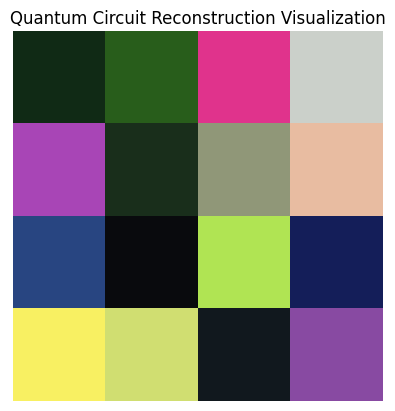

In [149]:
import ast

# 문자열을 정수형 리스트로 변환
rgb_values = [ast.literal_eval(item) for item in output]

# NumPy 배열로 변환
rgb_array = np.array(rgb_values)

# 이미지 형태로 재구성 (4x4 이미지)
# 각 픽셀은 [R, G, B] 형태를 가짐
image_size = (4, 4, 3)  # (높이, 너비, 색상채널)
rgb_image = rgb_array.reshape(image_size)

# 이미지 시각화
plt.imshow(rgb_image)
plt.axis('off')  # 축 숨기기
plt.title('Quantum Circuit Reconstruction Visualization')
plt.show()


In [15]:
print(params['origin_color_theta'][0])
print(params['origin_color_phi'][0])

0.3542925048433409
2.999784651865254


In [104]:
import pandas as pd
file = 'novel color_space_angle6.xlsx'

df = pd.read_excel(file)
df

Unnamed: 0           index     theta       phi
0                0      [40, 0, 0]  0.246399  0.000000
1                1      [40, 0, 1]  0.246399  6.257005
2                2      [40, 0, 2]  0.246399  6.230825
3                3      [40, 0, 3]  0.246399  6.204645
4                4      [40, 0, 4]  0.246399  6.178466
...            ...             ...       ...       ...
524283      524283  [47, 255, 251]  1.854185  3.121454
524284      524284  [47, 255, 252]  1.854185  3.126489
524285      524285  [47, 255, 253]  1.854185  3.131523
524286      524286  [47, 255, 254]  1.854185  3.136558
524287      524287  [47, 255, 255]  1.854185  3.141593

[524288 rows x 4 columns]

In [105]:
# 1. theta 값이 1.716682보다 크고 1.21783보다 작은 인덱스를 추출
theta_filtered = df[(df['theta'] < 1.721783) & (df['theta'] > 1.716682)]
# 2. 추출된 인덱스들 중에서 phi 값이 1.903954보다 크고 1.918318보다 작은 인덱스를 추출
result = theta_filtered[(theta_filtered['phi'] > 1.903954) & (theta_filtered['phi'] < 1.918318)]

result

Unnamed: 0          index     theta       phi
297497      297497  [44, 138, 25]  1.721783  1.918318
363033      363033  [45, 138, 25]  1.721783  1.909050
363289      363289  [45, 139, 25]  1.721756  1.910676
363545      363545  [45, 140, 25]  1.721729  1.912274
363801      363801  [45, 141, 25]  1.721703  1.913844
364057      364057  [45, 142, 25]  1.721676  1.915387
364313      364313  [45, 143, 25]  1.721649  1.916904
429337      429337  [46, 141, 25]  1.721703  1.904816
429593      429593  [46, 142, 25]  1.721676  1.906437
429849      429849  [46, 143, 25]  1.721649  1.908029
430105      430105  [46, 144, 25]  1.721623  1.909596
430361      430361  [46, 145, 25]  1.721596  1.911136
430617      430617  [46, 146, 25]  1.721569  1.912650
430873      430873  [46, 147, 25]  1.721543  1.914140
431129      431129  [46, 148, 25]  1.721516  1.915605
431385      431385  [46, 149, 25]  1.721489  1.917047
496153      496153  [47, 146, 25]  1.721569  1.903996
496409      496409  [47, 147, 25]  1.721543  1.905556
496665      496665  [47, 148, 25]  1.721516  1.907091
496921      496921  [47, 149, 25]  1.721489  1.908602
497177      497177  [47, 150, 25]  1.721463  1.910088
497433      497433  [47, 151, 25]  1.721436  1.911551
497689      497689  [47, 152, 25]  1.721409  1.912991
497945      497945  [47, 153, 25]  1.721383  1.914408
498201      498201  [47, 154, 25]  1.721356  1.915803
498457      498457  [47, 155, 25]  1.721329  1.917177

In [139]:
final_indices = result['index']
print(final_indices.values[0])

[44, 138, 25]


(-0.5, 3.5, 3.5, -0.5)

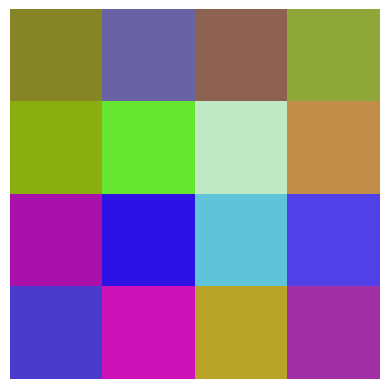

In [181]:
image = np.random.randint(0, 256, size=(4, 4, 3), dtype=np.int64)

plt.imshow(image, cmap = 'gray')
plt.axis('off')

In [182]:
image

array([[[133, 133,  38],
        [106,  99, 163],
        [141,  98,  81],
        [143, 166,  57]],

       [[138, 173,  16],
        [102, 230,  48],
        [192, 234, 198],
        [193, 142,  74]],

       [[170,  16, 171],
        [ 46,  17, 228],
        [ 96, 196, 216],
        [ 79,  65, 231]],

       [[ 74,  59, 204],
        [205,  18, 186],
        [184, 164,  38],
        [161,  47, 165]]], dtype=int64)

theta error =  0.009628285708343842 phi error =  0.005519209010831583
theta error =  0.01058315609189675 phi error =  0.013694515476756486
theta error =  0.007699574287665101 phi error =  0.008949673330651664
theta error =  0.009610838663990373 phi error =  0.01760671957795723
theta error =  0.0007671247775615786 phi error =  0.0018736758703048473
theta error =  0.003366345151249117 phi error =  0.008744271885811283
theta error =  0.007985962979349726 phi error =  0.028530064759788143
theta error =  0.01879288530944656 phi error =  0.019268693767888534
theta error =  0.00677655510071995 phi error =  0.010987813777293631
theta error =  0.0072273600924945836 phi error =  0.0005524589143632852
theta error =  0.0068891312524939075 phi error =  0.03291372296321082
theta error =  0.00900005418313743 phi error =  0.030302103827548166
theta error =  0.0020169415145265823 phi error =  0.029516870164113307
theta error =  0.0020046742413437624 phi error =  0.006956960866606465
theta error =  0.00

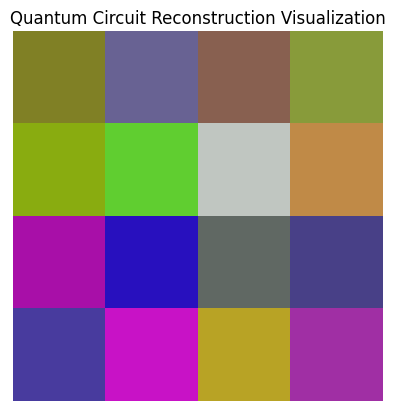

In [183]:
params = preprocess_image(image)
#print(params)
counts = create_and_simulate_quantum_circuit(image, 1000000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']

image_flat = image.reshape(-1,3)
value = [x[0] for x in image_flat]
output = []
for i in range(len(color_phi)):
    theta_error = np.abs(color_theta[i]-pixel_color_theta_recon[i])
    phi_error = np.abs(color_phi[i]-pixel_color_phi_recon[i])
    print("theta error = ",theta_error, "phi error = ", phi_error)
    num = int(value[i] // 8 + 1)
    file = f'novel color_space_angle{num}.xlsx'
    df = pd.read_excel(file)
    # 1. theta 값이 1.716682보다 크고 1.21783보다 작은 인덱스를 추출
    theta_filtered = df[(df['theta'] < color_theta[i]+theta_error) & (df['theta'] > color_theta[i]-theta_error)]
    # 2. 추출된 인덱스들 중에서 phi 값이 1.903954보다 크고 1.918318보다 작은 인덱스를 추출
    result = theta_filtered[(theta_filtered['phi'] > color_phi[i]-phi_error) & (theta_filtered['phi'] < color_phi[i]+phi_error)]
    final_indices = result['index']
    output.append(final_indices.values[0])
    
# 문자열을 정수형 리스트로 변환
rgb_values = [ast.literal_eval(item) for item in output]

# NumPy 배열로 변환
rgb_array = np.array(rgb_values)

# 이미지 형태로 재구성 (4x4 이미지)
# 각 픽셀은 [R, G, B] 형태를 가짐
image_size = (4, 4, 3)  # (높이, 너비, 색상채널)
rgb_image = rgb_array.reshape(image_size)

# 이미지 시각화
plt.imshow(rgb_image)
plt.axis('off')  # 축 숨기기
plt.title('Quantum Circuit Reconstruction Visualization')
plt.show()

In [184]:
output

['[128, 128, 37]',
 '[104, 98, 147]',
 '[136, 96, 80]',
 '[136, 155, 58]',
 '[137, 172, 16]',
 '[96, 206, 48]',
 '[192, 198, 193]',
 '[192, 138, 71]',
 '[168, 15, 168]',
 '[40, 16, 190]',
 '[96, 104, 99]',
 '[72, 64, 135]',
 '[72, 59, 158]',
 '[200, 18, 198]',
 '[184, 163, 37]',
 '[160, 47, 164]']

## Fidelity 측정

In [186]:
import numpy as np
from qiskit.quantum_info import Statevector, state_fidelity

def bloch_to_state(theta, phi):
    """Bloch 구면의 각도를 사용하여 큐비트 상태를 생성하는 함수."""
    # 큐비트 상태 생성
    return Statevector([
        np.cos(theta / 2),  # |0⟩ 성분
        np.exp(1j * phi) * np.sin(theta / 2)  # |1⟩ 성분
    ])

# 두 상태의 각도 정의
theta1, phi1 = 1.80219138202288, 1.0471975511966   # (133, 133, 38)
theta2, phi2 = 1.79615616510237, 1.0471975511966  # (128, 128, 37)

# Bloch 구면의 각도를 사용하여 상태 생성
psi = bloch_to_state(theta1, phi1)  # 첫 번째 상태
phi_state = bloch_to_state(theta2, phi2)  # 두 번째 상태

# 피델리티 계산
fidelity = state_fidelity(psi, phi_state)

print(f"피델리티: {fidelity}")


피델리티: 0.9999908940668201


## Image Rotation

In [1293]:
params = preprocess_image(image,rot=30)
counts = create_and_simulate_quantum_circuit(image, 1000000, "simul")
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)

back =  [array([4.02052454, 4.15042313, 0.        ]), array([3.95622479, 2.87499637, 0.        ]), array([4.04904411, 1.97835454, 0.        ]), array([4.01154717, 1.07658971, 0.        ]), array([2.94740015, 4.11012406, 0.        ]), array([3.04290111, 2.99142704, 0.        ]), array([3.01334475, 1.93019426, 0.        ]), array([3.0658705 , 0.98937019, 0.        ]), array([2.00066387, 4.00419642, 0.        ]), array([2.00029002, 3.07354769, 0.        ]), array([2.00843128, 2.07319052, 0.        ]), array([1.99325183, 1.02385798, 0.        ]), array([1.09446475, 3.95686004, 0.        ]), array([0.99293222, 3.05755763, 0.        ]), array([1.00162696, 1.96049409, 0.        ]), array([1.01466109, 0.97156504, 0.        ])]


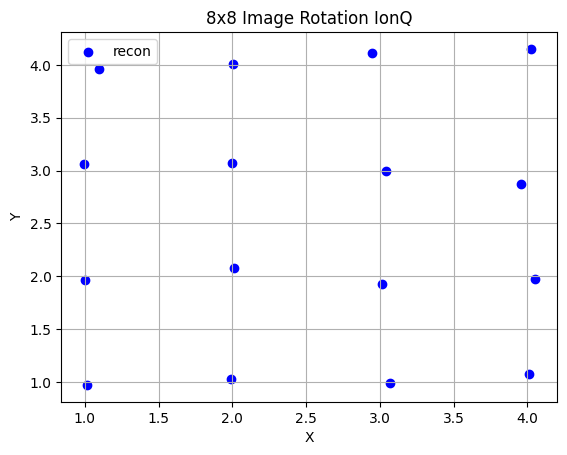

In [1294]:
recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))

back_recon_pixel= []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel[i][0] / k
    Y = recon_pixel[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)
#back_recon_pixel = list(reversed(back_recon_pixel))
print("back = ", back_recon_pixel)

x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

plt.scatter(x_values, y_values, color='blue', label='recon')
plt.title('8x8 Image Rotation IonQ')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [1179]:
params = preprocess_image(image,rot=30)
counts = create_and_simulate_quantum_circuit(image, 1000000, "simul")
# 재구성된 값들 추출
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']
print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])


color theta =  [0.3840256304784353, 0.2297844167925184, 0.24725895668472334, 0.1125172052402599, 0.06912311704860859, 0.16177359550208936, 0.06816377502967245, 0.47445731747869646, 0.6546535026923855, 0.23357082995658598, 0.05050190619607312, 0.1937370469585092, 0.12453655984317986, 0.13826920456344877, 0.17592593222097805, 0.3246282063952826]
color phi =  [4.345457554965409, 0.35825179383041506, 1.109463351538017, 1.4865390525606874, 1.278683325671635, 5.118255486913548, 0.4487989505128276, 4.974188368183842, 4.576641149674019, 3.8979019961206696, 1.6501294746128206, 1.8325957145940421, 6.095372702888892, 0.8361344788623997, 2.0210912738094335, 2.9699209238854327]
Recon color theta =  [0.3855287946815576, 0.23156615736846708, 0.25741422836566263, 0.11775656799251626, 0.07000121625325928, 0.1606988452863261, 0.07343881181467975, 0.47406101505479187, 0.6584007788497778, 0.23201940025437529, 0.055388418409814594, 0.18299221543332617, 0.11525185171988088, 0.1483337499796469, 0.17814363469

In [1213]:
print("color theta MSE = ", color_errors(color_theta, pixel_color_theta_recon)[0])
print("color theta MAE = ", color_errors(color_theta, pixel_color_theta_recon)[1])
print("color phi MSE = ", color_errors(color_phi, pixel_color_phi_recon)[0])
print("color phi MAE = ", color_errors(color_phi, pixel_color_phi_recon)[1])

color theta MSE =  3.477341132255654e-05
color theta MAE =  0.004706311689971064
color phi MSE =  0.0002791176372406301
color phi MAE =  0.012860216499089142


In [1214]:
position_error(pixel_theta_recon, pixel_phi_recon, Q)

Error = 0.06618710048558965


In [ ]:
pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)

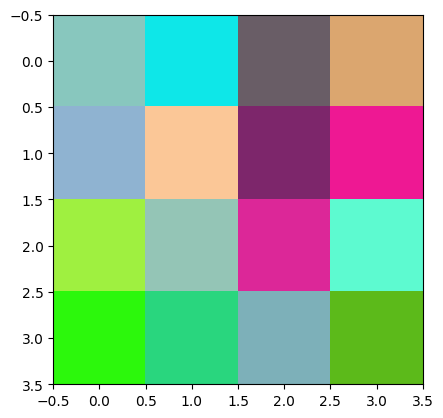

In [1215]:
image = np.random.randint(0, 256, size=(4, 4, 3), dtype=np.int64)

plt.imshow(image, cmap = 'gray')

In [1253]:
from qiskit import QuantumCircuit, Aer, execute
qc_bit = QuantumCircuit(1, 1) 
qc_bit.h(0)  # Hadamard 게이트로 |+⟩ 상태 준비 (슈퍼포지션 상태)

# 비트 플립 오류 시뮬레이션 (X 게이트 적용)
qc_bit.x(0) 
qc_bit.measure(0, 0)
backend = Aer.get_backend('qasm_simulator')

# 회로 실행
shots = 1000  # 반복 횟수
results = execute(qc_bit, backend, shots=shots).result()

# 측정 결과 가져오기
counts = results.get_counts(qc_bit)

# 오류율 계산
bit_flip_error_rate = counts.get('1', 0) / shots

print(f"비트 플립 오류율: {bit_flip_error_rate:.4f}")

비트 플립 오류율: 0.4790


In [1247]:
params = preprocess_image(image)
color_theta = params['origin_color_theta']
color_phi = params['origin_color_phi']

positionMSE = []
colorthetaMSE=[]
colorphiMSE=[]
for iter in range(200):
    counts = create_and_simulate_quantum_circuit(image, 256*(iter+400), "simul")
    # 재구성된 값들 추출    
    print("iteration = ",(iter+1)*256)
    pixel_theta_recon, pixel_phi_recon, pixel_color_theta_recon, pixel_color_phi_recon = reconstruct_values(counts)
    colorthetaMSE.append(color_errors(color_theta, pixel_color_theta_recon)[0])
    colorphiMSE.append(color_errors(color_phi, pixel_color_phi_recon)[0])
    positionMSE.append(position_error(pixel_theta_recon, pixel_phi_recon, Q))

    print("==========================================================================")

iteration =  256
MSE =  0.0006168649850289423 MAE = 0.019576413970157226
MSE =  0.0027351286660004647 MAE = 0.04235838239581551
Error = 0.20191745390670804
iteration =  512
MSE =  0.0007234516586053307 MAE = 0.0193056422273674
MSE =  0.0021181469690948734 MAE = 0.03613964689791406
Error = 0.25242675439611095
iteration =  768
MSE =  0.0001400445179991372 MAE = 0.010270339194724525
MSE =  0.0015928999040790174 MAE = 0.03307192498587345
Error = 0.21124857495226568
iteration =  1024
MSE =  0.0004161276322628947 MAE = 0.014226805843672977
MSE =  0.002782111957583248 MAE = 0.03677608271915936
Error = 0.23932336426824843
iteration =  1280
MSE =  0.00031204916622785885 MAE = 0.012504426589967789
MSE =  0.004312583709135185 MAE = 0.056285988856857296
Error = 0.20194620491626417
iteration =  1536
MSE =  0.00038007080995021647 MAE = 0.016287606153600385
MSE =  0.002215936753008685 MAE = 0.04195748944538494
Error = 0.20407621939612275
iteration =  1792
MSE =  0.0006442651599381934 MAE = 0.02197648

In [1248]:
iters = []
for iter in range(200):
    iters.append((iter+400)*256)
df = pd.DataFrame({"Iterations" : iters,
                   "Position MSE" : positionMSE,
                   "Margin" : [0.5]*200,
                   "Color Theta MSE" : colorthetaMSE,
                   "Color Phi MSE ": colorphiMSE})
df

Iterations  Position MSE  Margin  Color Theta MSE  Color Phi MSE 
0        102400      0.201917     0.5         0.000617        0.002735
1        102656      0.252427     0.5         0.000723        0.002118
2        102912      0.211249     0.5         0.000140        0.001593
3        103168      0.239323     0.5         0.000416        0.002782
4        103424      0.201946     0.5         0.000312        0.004313
..          ...           ...     ...              ...             ...
195      152320      0.217958     0.5         0.000275        0.001782
196      152576      0.170589     0.5         0.000309        0.000819
197      152832      0.176030     0.5         0.000330        0.001185
198      153088      0.185280     0.5         0.000757        0.001214
199      153344      0.124125     0.5         0.000363        0.001863

[200 rows x 5 columns]

In [1254]:
df.to_excel("Image Encoding Simulation position with color 8by8.xlsx")

In [ ]:
a = (1 - 1) * np.pi / 510 + np.pi * (256 - 255) / (510 * (256 - 1))
b =(1 - 1) * np.pi / 510 + np.pi * (256 - 255) / (510 * (256 - 2))

In [ ]:
phi = (y - z) * np.pi / (3 * (x - z))

In [1258]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np

# 양자 회로 초기화
qc = QuantumCircuit(1, 1)  # 1 큐비트, 1 클래식 비트

# 초기 상태 설정 (|0⟩)
qc.h(0)  # Hadamard 게이트로 |+⟩ 상태 준비 (슈퍼포지션 상태)

# 비트 플립 오류 시뮬레이션 (X 게이트 적용)
qc.x(0)  # X 게이트는 비트 플립 오류를 시뮬레이션

# 측정 추가
qc.measure(0, 0)

# 시뮬레이터 백엔드 설정
backend = Aer.get_backend('qasm_simulator')

# 회로 실행
shots = 1000  # 반복 횟수
results = execute(qc, backend, shots=shots).result()

# 측정 결과 가져오기
counts = results.get_counts(qc)

# 오류율 계산
bit_flip_error_rate = counts.get('1', 0) / shots

print(f"비트 플립 오류율: {bit_flip_error_rate:.4f}")


비트 플립 오류율: 0.4920


In [1259]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np

# 양자 회로 초기화
qc = QuantumCircuit(1, 1)  # 1 큐비트, 1 클래식 비트

# 초기 상태 설정 (|0⟩)
qc.h(0)  # Hadamard 게이트로 |+⟩ 상태 준비 (슈퍼포지션 상태)

# 비트 플립 오류 시뮬레이션 (X 게이트 적용)
#qc.x(0)  # X 게이트는 비트 플립 오류를 시뮬레이션

# 측정 추가
qc.measure(0, 0)

# 시뮬레이터 백엔드 설정
backend = Aer.get_backend('qasm_simulator')

# 회로 실행
shots = 1000  # 반복 횟수
results = execute(qc, backend, shots=shots).result()

# 측정 결과 가져오기
counts = results.get_counts(qc)

# 오류율 계산
bit_flip_error_rate = counts.get('1', 0) / shots

print(f"비트 플립 오류율: {bit_flip_error_rate:.4f}")


비트 플립 오류율: 0.5050


In [1260]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Statevector, state_fidelity

# 2 큐비트 Grover 알고리즘 예시
qc = QuantumCircuit(2)

# 초기 상태 |00⟩
qc.h([0, 1])  # 모든 큐비트에 Hadamard 게이트 적용
qc.cz(0, 1)   # Grover diffusion 연산 (CZ 게이트 사용)
qc.h([0, 1])  # Grover 연산 반복
qc.measure_all()

# 목표 상태 정의 (예: |11⟩ 상태)
target_state = Statevector.from_label('11')

# 시뮬레이터 백엔드 설정
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result()
final_state = result.get_statevector()

# Fidelity 계산
fidelity = state_fidelity(final_state, target_state)
print(f"Grover 알고리즘의 Fidelity: {fidelity:.4f}")


Grover 알고리즘의 Fidelity: 0.0000


In [1031]:
qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=1000000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
#counts['1111000']=0
'''
counts['1001000']=0
counts['1011000']=0
counts['1101000']=0
counts['1111000']=0
'''
reconstruct_quantum_circuit_results(counts, P, Q, size_list, radius)

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\2589862629.py:89: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


Reconstructed color = [array([28.33333333,  0.        , 23.61111111]), array([14.16666667, 28.33333333,  0.        ]), array([18.88888889, 28.33333333,  0.        ]), array([28.33333333, 56.66666667,  0.        ]), array([  0.        ,   0.        , 113.33333333]), array([56.66666667, 85.        ,  0.        ]), array([ 0.        ,  9.44444444, 28.33333333]), array([0., 0., 0.]), array([28.33333333, 14.16666667,  0.        ]), array([ 18.88888889,   0.        , 113.33333333]), array([ 0.        , 56.66666667, 28.33333333]), array([28.33333333,  0.        ,  4.72222222]), array([ 0.        , 28.33333333, 56.66666667]), array([ 0.,  0., 85.]), array([56.66666667, 56.66666667,  0.        ]), array([141.66666667,  94.44444444,   0.        ])]
Reconstructed pixel = [array([0.97543904, 1.02937922, 0.        ]), array([1.08035614, 1.94231289, 0.        ]), array([1.09519429, 3.002145  , 0.        ]), array([1.09808197, 3.94754335, 0.        ]), array([2.02593266, 0.93027086, 0.        ]), arr

In [918]:
image

array([[[254,  41, 169],
        [ 94, 156,  20],
        [102, 143,  39],
        [140, 232,  52]],

       [[198, 114, 163],
        [198, 241,  95],
        [ 22,  39, 121],
        [  4,  82, 136]],

       [[216, 134,  37],
        [139, 124, 191],
        [ 63, 251, 124],
        [180,  22,  28]],

       [[ 47,  53, 141],
        [ 98,  94, 225],
        [218, 216,  65],
        [241, 210, 155]]], dtype=int64)

In [1007]:
color_theta, color_phi, origin_theta, origin_phi = map_colors_to_sphere(image)
print("Theta values:", color_theta)
print("Phi values:", color_phi)
print("================================================================================")
print("Origin Theta values :", origin_theta)
print("Origin Phi values:", origin_phi)

Theta values: [0.12322836300127406, 0.059824944849017986, 0.11864359352741068, 0.1574419847733293, 0.34929721136019076, 0.28980627882859444, 0.06645676767209177, 0.010706641629881181, 0.11144229647705937, 0.38035577722940594, 0.1910393460130215, 0.06568018829149098, 0.14337440157038697, 0.28702871151806525, 0.19773231248495043, 0.4747763155090224]
Phi values: [1.3630775637054307, 0.38114910870758517, 0.3650087618353525, 0.3956079637853813, 1.0627808480894043, 0.33890468694547426, 0.9440644590332964, 0.8845645981698533, 0.14186894199171785, 1.1058093544352132, 0.6493449382419848, 1.5244014985773258, 0.8995872580758006, 1.0551914256332129, 0.2583771735795527, 0.16742984103433975]
Origin Theta values : [0.24645672600254812, 0.11964988969803597, 0.23728718705482135, 0.3148839695466586, 0.6985944227203815, 0.5796125576571889, 0.13291353534418354, 0.021413283259762363, 0.22288459295411875, 0.7607115544588119, 0.382078692026043, 0.13136037658298197, 0.28674880314077394, 0.5740574230361305, 0.

In [1011]:
print(list(reversed(pixel_color_theta_recon_ionq)))
print(list(reversed(pixel_color_phi_recon_ionq)))

[0.25688701474398373, 0.12297580770191906, 0.24015733074815304, 0.3203085273066083, 0.6939689210499356, 0.5706799257402722, 0.13194227818057175, 0.02253506226835694, 0.23299214778057023, 0.7778688284541153, 0.374314507072039, 0.13432786160210958, 0.27295927333398406, 0.5773611944327355, 0.3910765566841504, 0.9490773843696892]
[5.435735617898625, 1.497079570587318, 1.458519888738462, 1.5950170726735917, 4.29121385722687, 1.3382937958062349, 3.7855573591263703, 3.5365156173387535, 0.551541231647371, 4.445424767615932, 2.5854380675838002, 6.099323970361791, 3.6015295791095605, 4.206368116004438, 1.054215562090323, 0.6690147291576206]


### Simulation

In [1016]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = np.arctan2(P[i][1], P[i][0])
    if phi <0:
        phi = (2*np.pi-abs(phi))/4
        phis.append(phi)
    else:
        phi = phi/4
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = np.arccos(P[i][2])/2
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG

'''
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]

'''
# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'q2')
c = QuantumRegister(1,'q1')
p = QuantumRegister(1, 'q3')
color = QuantumRegister(1, "q4")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "classical")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=1000000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
#counts['1111000']=0
'''
counts['1001000']=0
counts['1011000']=0
counts['1101000']=0
counts['1111000']=0
'''
reconstruct_quantum_circuit_results(counts, P, Q, size_list, radius)

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\572190283.py:149: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


Reconstructed color = [array([28.33333333,  0.        , 23.61111111]), array([14.16666667, 28.33333333,  0.        ]), array([18.88888889, 28.33333333,  0.        ]), array([28.33333333, 56.66666667,  0.        ]), array([  0.        ,   0.        , 113.33333333]), array([56.66666667, 85.        ,  0.        ]), array([ 0.        ,  9.44444444, 28.33333333]), array([0., 0., 0.]), array([28.33333333, 14.16666667,  0.        ]), array([ 18.88888889,   0.        , 113.33333333]), array([ 0.        , 56.66666667, 28.33333333]), array([28.33333333,  0.        ,  4.72222222]), array([ 0.        , 28.33333333, 56.66666667]), array([ 0.,  0., 85.]), array([56.66666667, 56.66666667,  0.        ]), array([141.66666667,  94.44444444,   0.        ])]
Reconstructed pixel = [array([0.98645424, 1.02197599, 0.        ]), array([1.00455379, 1.98668181, 0.        ]), array([0.95529358, 2.99269797, 0.        ]), array([0.90257325, 4.0356444 , 0.        ]), array([2.00995039, 0.99042872, 0.        ]), arr

In [1010]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = np.arctan2(P[i][1], P[i][0])
    if phi <0:
        phi = (2*np.pi-abs(phi))/4
        phis.append(phi)
    else:
        phi = phi/4
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = np.arccos(P[i][2])/2
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG

'''
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]

'''
# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'q2')
c = QuantumRegister(1,'q1')
p = QuantumRegister(1, 'q3')
color = QuantumRegister(1, "q4")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "classical")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=1000000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
#counts['1111000']=0
'''
counts['1001000']=0
counts['1011000']=0
counts['1101000']=0
counts['1111000']=0
'''
pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:-2]
        angle_decision = int(key[-2])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)



phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



theta_state_0_ionq = []
for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
#print(color_phi_result_list)


color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):
    if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,k_recon,0]))
    
    elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

    elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon,k_recon]))

    elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

    elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([k_recon,0,n_recon]))

    elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))


color_recon_ionq = list(reversed(color_recon_ionq))
print("Reconstructed color = ",color_recon_ionq)

# Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
print("Reconstructed pixel =",color_list_ionq)
x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]

end = time.time()
print(f"{end - start:.5f} sec")
error_ionq = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values_ionq[i]
    del_y = y_Q[i] - y_values_ionq[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d

print("Error =",error_ionq)


C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\2309992131.py:149: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


Reconstructed color =  [array([28.33333333,  0.        , 23.61111111]), array([14.16666667, 28.33333333,  0.        ]), array([18.88888889, 28.33333333,  0.        ]), array([28.33333333, 56.66666667,  0.        ]), array([ 18.88888889,   0.        , 113.33333333]), array([56.66666667, 85.        ,  0.        ]), array([ 0.        ,  9.44444444, 28.33333333]), array([0., 0., 0.]), array([28.33333333, 14.16666667,  0.        ]), array([ 18.88888889,   0.        , 113.33333333]), array([ 0.        , 56.66666667, 28.33333333]), array([28.33333333,  0.        ,  4.72222222]), array([ 0.        , 28.33333333, 56.66666667]), array([ 0.,  0., 85.]), array([56.66666667, 56.66666667,  0.        ]), array([141.66666667,  94.44444444,   0.        ])]
Reconstructed pixel = [[array([0.97989823, 1.02257057, 0.        ])], [array([0.98254161, 2.01233406, 0.        ])], [array([1.03804462, 2.97308223, 0.        ])], [array([0.98264166, 3.93778839, 0.        ])], [array([1.98535691, 1.00851329, 0.     

In [885]:
print("phi=",pixel_color_phi_recon_ionq)
print("theta=" ,pixel_color_theta_recon_ionq)

phi= [0.6681820854064359, 1.0375475981350508, 1.0623945035711546, 0.969899338096582, 0.07899525095389874, 2.5799673551796665, 1.3362314617366249, 0.5354053453369477, 0.49864399365530415, 0.8345802127435774, 1.3855197164667097, 1.4762872126405662, 1.5872661657843987, 1.4483317107723677, 1.5554693485940032, 1.5506984410670406]
theta= [0.9505430988314072, 0.3962817597133479, 1.4143043376488615, 0.8718085626288611, 0.16511296240847506, 0.7561205752692286, 1.183297634859649, 0.22622239959243812, 0.8562093811335232, 0.7534443443737032, 0.5605952440506266, 0.9938099918652528, 0.28568159754789163, 0.23034262132856606, 0.12198652217018831, 1.0408704958580342]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


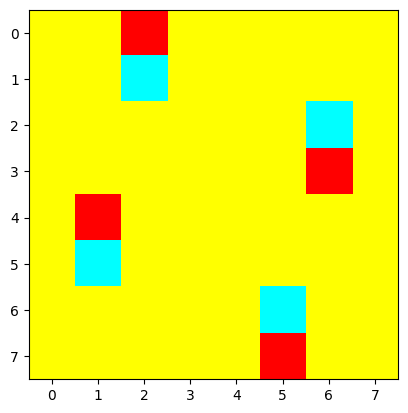

In [880]:
recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
recon_color_array_3 = np.rot90(recon_color_array,k=2)
recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))

color_row1 = np.concatenate((recon_color_array_2,recon_color_array_3), axis=1)
color_row2 = np.concatenate((recon_color_array,recon_color_array_4), axis=1)
final_color_array = np.concatenate((color_row1,color_row2),axis=0)
plt.imshow(final_color_array, cmap = 'gray')

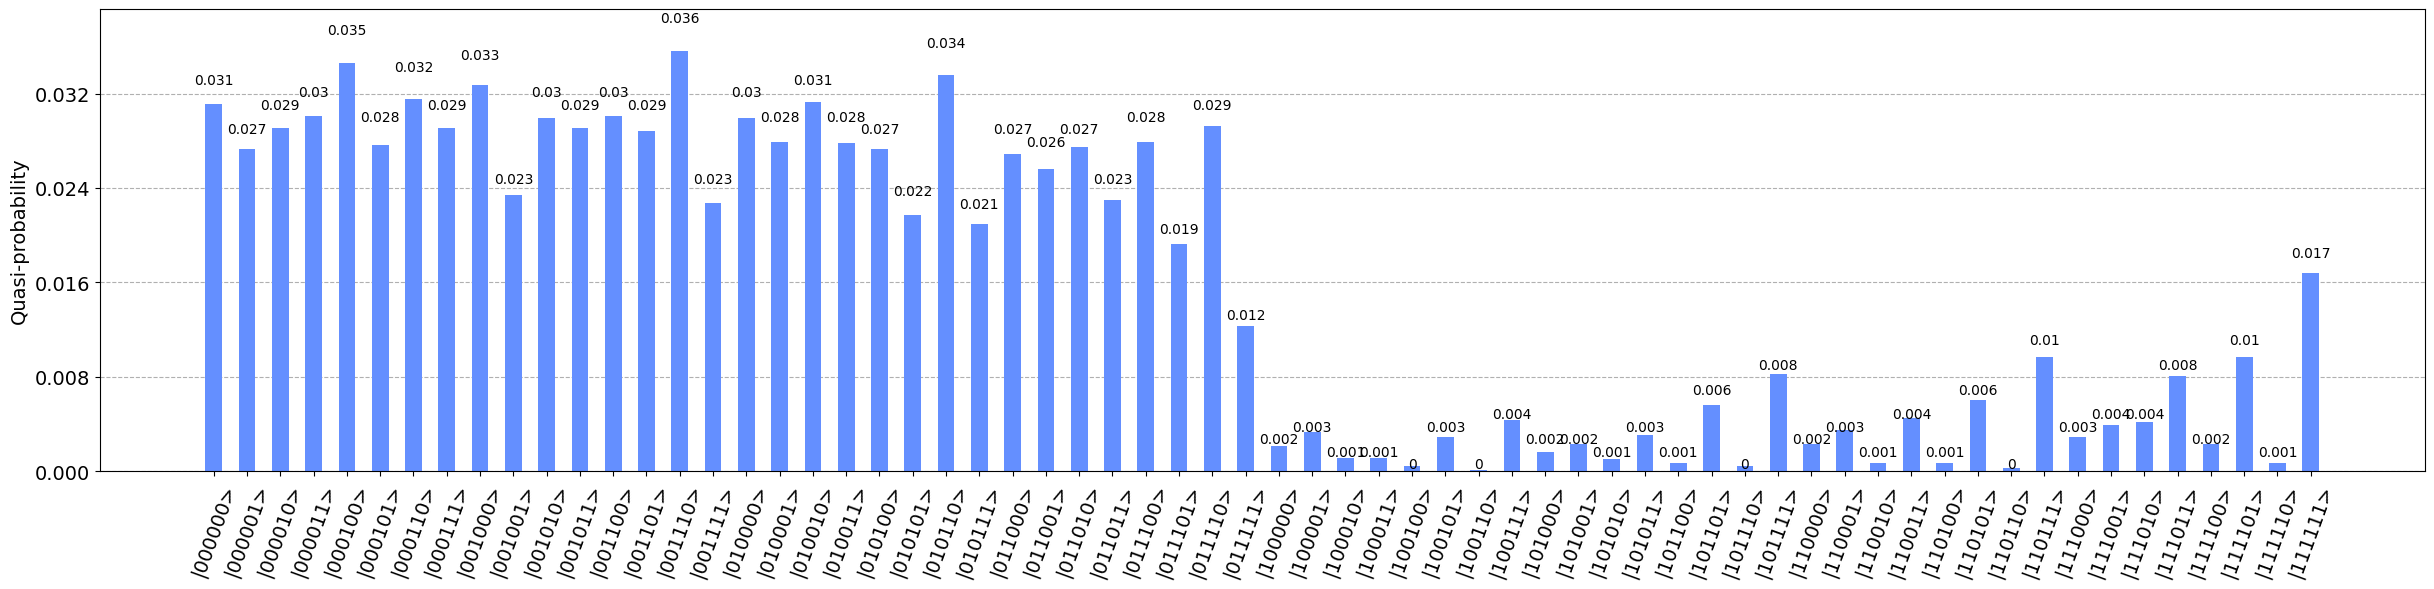

In [770]:
stereo_simul_8by8 = {}
for i in counts:
    stereo_simul_8by8[f"|{i}>"]=counts[i] / 144384
plot_histogram(simul_8by8, figsize=(30,6))

#### position MSE / color MSE에 따라 iteration

In [709]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=144384)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
'''
counts['1001000']=0
counts['1011000']=0
counts['1101000']=0
counts['1111000']=0
'''
pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:-2]
        angle_decision = int(key[-2])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)



phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



theta_state_0_ionq = []
for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
#print(color_phi_result_list)


color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):
    if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,k_recon,0]))
    
    elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

    elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon,k_recon]))

    elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

    elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([k_recon,0,n_recon]))

    elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))


color_recon_ionq = list(reversed(color_recon_ionq))
print("Reconstructed color = ",color_recon_ionq)

# Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
print("Reconstructed pixel =",color_list_ionq)
x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]

end = time.time()
print(f"{end - start:.5f} sec")
error_ionq = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values_ionq[i]
    del_y = y_Q[i] - y_values_ionq[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d

print("Error =",error_ionq)


C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\1899277316.py:147: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


Reconstructed color =  [array([ 42.5, 255. ,   0. ]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.])]
Reconstructed pixel = [[array([1.01319337, 0.93749297, 0.        ])], [array([1.00135535, 1.97080555, 0.        ])], [array([1.12078373, 2.91098052, 0.        ])], [array([1.01345295, 3.99150014, 0.        ])], [array([1.97323616, 0.88962503, 0.        ])], [array([2.02635327, 2.05393948, 0.        ])], [array([1.99647991, 3.24542105, 0.        ])], [array([1.86432509, 4.0154209 , 0.        ])], [array([3.18190103, 0.86887183, 0.        ])], [array([2.94543091, 1.88002955, 0.        ])], [array([3.1573952 , 3.09323931, 0.        ])], [

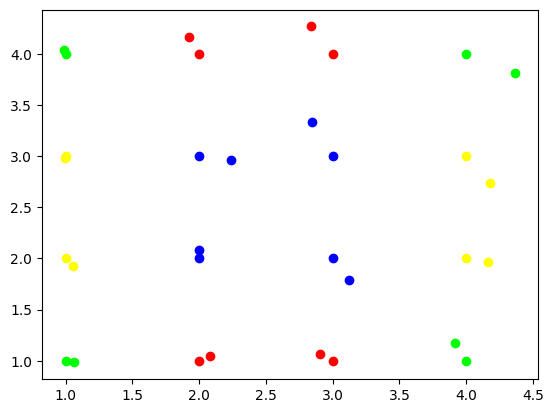

In [651]:
for i in range(len(color_recon_ionq)):
    result_array = (color_recon_ionq[i] / 255 > 0).astype(int)
    plt.scatter(back_recon_pixel_ionq[i][0],back_recon_pixel_ionq[i][1],color=result_array, marker='o')
    plt.scatter(Q[i][0],Q[i][1],color=result_array)
plt.show()

#### Stereographic Projection으로 8x8 확장

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\2701382970.py:147: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


Reconstructed color =  [array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.])]
Reconstructed pixel = [[array([1.05032554, 0.90373848, 0.        ])], [array([0.97264909, 1.98066027, 0.        ])], [array([0.89458077, 3.09050367, 0.        ])], [array([0.8778388 , 4.07130597, 0.        ])], [array([1.98035324, 1.12908656, 0.        ])], [array([1.7720701 , 2.07254611, 0.        ])], [array([1.75787349, 3.13709101, 0.        ])], [array([1.78346849, 3.91651184, 0.        ])], [array([3.05879655, 0.96144676, 0.        ])], [array([2.86031551, 1.94670133, 0.        ])], [array([2.83231505, 2.9415092 , 0.        ])], [arr

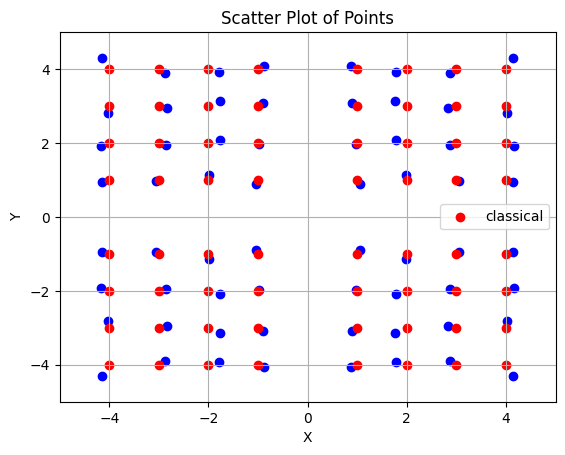

Error = [0.03000375854986949, 0.0655288974993972, 0.2016589724170086, 0.13807728776753725, 0.12661467583492597, 0.11832817159992814, 0.16230407065963554, 0.34135207023383557, 0.10807426388294529, 0.15982234091321887, 0.1557851356650639, 0.24442159758781437, 0.316013913321327, 0.32586707314151575, 0.21037088351233313, 0.37154128060040725]


In [785]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits,"q2")
c = QuantumRegister(1,"q1")
p = QuantumRegister(1,"q3")
color = QuantumRegister(1,"q4")
cr = ClassicalRegister(O.size+c.size+p.size+color.size,"cl")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=144384)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
'''
counts['1001000']=0
counts['1011000']=0
counts['1101000']=0
counts['1111000']=0
'''
pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:-2]
        angle_decision = int(key[-2])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)



phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



theta_state_0_ionq = []
for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
#print(color_phi_result_list)


color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):


    #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
    #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

    if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,k_recon,0]))
    
    elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

    elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon,k_recon]))

    elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

    elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([k_recon,0,n_recon]))

    elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
    

color_recon_ionq = list(reversed(color_recon_ionq))
print("Reconstructed color = ",color_recon_ionq)

# Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
print("Reconstructed pixel =",color_list_ionq)


back_2 = [y_axis_reflection(point) for point in back_recon_pixel_ionq]
back_3 = [origin_reflection(point) for point in back_recon_pixel_ionq]
back_4 = [x_axis_reflection(point) for point in back_recon_pixel_ionq]

back_stereo_pixel = back_recon_pixel_ionq + back_2 + back_3 + back_4

x_stereo = [point[0] for point in back_stereo_pixel]
y_stereo = [point[1] for point in back_stereo_pixel]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]
end = time.time()
print(f"{end - start:.5f} sec")


origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)

x_Q_origin = [point[0] for point in Q_origin]
y_Q_origin = [point[1] for point in Q_origin]

# 시각화
plt.scatter(x_stereo, y_stereo, color='blue')
plt.scatter(x_Q_origin, y_Q_origin, color='red', label = 'classical')
plt.title('Scatter Plot of Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.legend()
plt.grid(True)
plt.show()

error_ionq = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values_ionq[i]
    del_y = y_Q[i] - y_values_ionq[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d

print("Error =",error_ionq)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


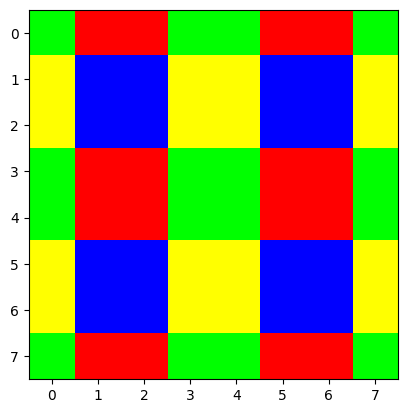

In [786]:
recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
recon_color_array_3 = np.rot90(recon_color_array,k=2)
recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))

color_row1 = np.concatenate((recon_color_array_2,recon_color_array_3), axis=1)
color_row2 = np.concatenate((recon_color_array,recon_color_array_4), axis=1)
final_color_array = np.concatenate((color_row1,color_row2),axis=0)
plt.imshow(final_color_array, cmap = 'gray')

In [787]:
#recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array = np.array(color_recon_ionq).reshape(4,4,3)
color_recon_ionq_1 = recon_color_array.reshape(-1,3).tolist()

recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
color_recon_ionq_2 = recon_color_array_2.reshape(-1,3).tolist()

recon_color_array_3 = np.rot90(recon_color_array,k=2)
color_recon_ionq_3 = recon_color_array_3.reshape(-1,3).tolist()

recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))
color_recon_ionq_4 = recon_color_array_4.reshape(-1,3).tolist()

color_recon_point = color_recon_ionq_1 + color_recon_ionq_2 + color_recon_ionq_3 + color_recon_ionq_4
final_color = np.array(color_recon_point)

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\130674980.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o', label = 'Recon')


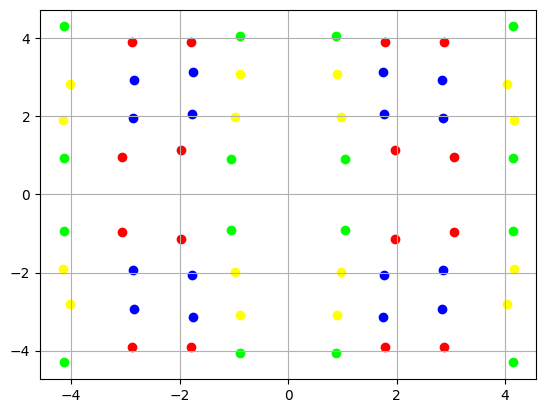

In [788]:
for i in range(len(back_stereo_pixel)):
    result_array = (final_color[i] / 255 > 0).astype(int)
    plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o', label = 'Recon')
    #plt.scatter(Q_origin[i][0],Q_origin[i][1],c="gray", label = 'Classical')
    plt.grid(True)
plt.show()

#### Iteration에 따른 성능 분석

In [504]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterposMSE = []
itercolorMSE = []
red_error = []
green_error = []
blue_error = []
for iter in range(500):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc_image, aer_sim)
    qobj = assemble(t_qc, shots=1024*(iter+1))
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()
    '''
    counts['1001000']=0
    counts['1011000']=0
    counts['1101000']=0
    counts['1111000']=0
    '''
    pixel_theta_recon_ionq = []
    pixel_phi_recon_ionq = []

    pixel_theta_ionq = []
    pixel_phi_ionq = []

    pixel_color_theta_recon_ionq = []
    pixel_color_phi_recon_ionq = []

    pixel_color_theta_ionq = []
    pixel_color_phi_ionq = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            bin_coord = key[1:-2]
            angle_decision = int(key[-2])
            switch = int(key[-1]) # switch = 1, position, and switch = 0, color
            int_coord = int(bin_coord, 2)
            if switch == 1:
                if int_coord == i and angle_decision == 1:
                    pixel_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_phi_ionq.append((state,bin_coord, amount))
            elif switch == 0:
                if int_coord == i and angle_decision == 1:
                    pixel_color_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_color_phi_ionq.append((state,bin_coord, amount))

    # position
    # ======================== phi ====================================
    phi_result_dict_ionq = {}
    for state in pixel_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict_ionq:
            phi_result_dict_ionq[key] += value  
        else:
            phi_result_dict_ionq[key] = value  

    phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
    #print(phi_result_list)



    phi_state_0_ionq = []
    for state, phi, amount in pixel_phi_ionq:
        if not int(state):
            phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
            pixel_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict_ionq = {}
    for state in pixel_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict_ionq:
            theta_result_dict_ionq[key] += value  
        else:
            theta_result_dict_ionq[key] = value  

    theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



    theta_state_0_ionq = []
    for state, theta, amount in pixel_theta_ionq:
        if not int(state):
            theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
            pixel_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # color
    # ======================== phi ====================================
    color_phi_result_dict_ionq = {}
    for state in pixel_color_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in color_phi_result_dict_ionq:
            color_phi_result_dict_ionq[key] += value  
        else:
            color_phi_result_dict_ionq[key] = value  

    color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
    #print(color_phi_result_list)


    color_phi_state_0_ionq = []
    for state, phi, amount in pixel_color_phi_ionq:
        if not int(state):
            color_phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
            pixel_color_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    color_theta_result_dict_ionq = {}
    for state in pixel_color_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in color_theta_result_dict_ionq:
            color_theta_result_dict_ionq[key] += value  
        else:
            color_theta_result_dict_ionq[key] = value  

    color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

    color_theta_state_0_ionq = []

    for state, theta, amount in pixel_color_theta_ionq:
        if not int(state):
            color_theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
            pixel_color_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
    # 좌표들의 phi 각도를 보며 유추 할 수 있으므로
    # 순서대로 G,Y,R,B
    color_recon_ionq = []
    for i in range(len(pixel_color_phi_recon_ionq)):
        #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
        #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))
        
        if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,k_recon,0]))
        
        elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

        elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon,k_recon]))

        elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

        elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([k_recon,0,n_recon]))

        elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
    
    color_recon_ionq = list(reversed(color_recon_ionq))
    #print("Reconstructed color = ",color_recon_ionq)

    # Visualization
    recon_pixel_ionq = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        z = np.cos(pixel_theta_recon_ionq[i])
        recon_pixel_ionq.append(np.array([x,y,z]))
    back_recon_pixel_ionq = []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel_ionq[i][0] / k
        Y = recon_pixel_ionq[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel_ionq.append(back_P)
    back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

    color_list_ionq = []
    for i in range(len(back_recon_pixel_ionq)):
        color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)
    x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
    y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    x_Q = [point[0] for point in Q]
    y_Q = [point[1] for point in Q]

    error_ionq = []
    for i in range(len(Q)):
        del_x = x_Q[i] - x_values_ionq[i]
        del_y = y_Q[i] - y_values_ionq[i]
        err_ionq = np.sqrt(del_x**2+del_y**2)
        error_ionq.append(err_ionq)
    MSE = sum(error_ionq)/len(Q)
    iterposMSE.append(MSE)


    error_color = []
    for i in range(len(Q)):
        del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
        del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
        del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
        del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
        error_color.append(del_color)
    colorMSE = sum(error_color)/len(Q)
    itercolorMSE.append(colorMSE)
    red_error.append(del_color_r)
    green_error.append(del_color_g)
    blue_error.append(del_color_b)

    print("iteration = ",(iter+1)*1024)
    print("MSE = ", MSE)
    #print("Red Error = ",del_color_r, "Green Error = ", del_color_g, "Blue Error = ", del_color_b)
    print("Color Error = ", colorMSE)
    print("==========================================================================")

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\1111141049.py:153: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


iteration =  1024
MSE =  2.1210667253233284
Color Error =  106.69474584330709
iteration =  2048
MSE =  1.879206988163759
Color Error =  61.03497497097598
iteration =  3072
MSE =  1.2486071389664366
Color Error =  48.09036410445117
iteration =  4096
MSE =  1.0093330538938106
Color Error =  45.651150416890744
iteration =  5120
MSE =  1.011647003985008
Color Error =  40.17352790276337
iteration =  6144
MSE =  0.6850048552860427
Color Error =  38.882962466166376
iteration =  7168
MSE =  0.7462875561702939
Color Error =  20.21266985003568
iteration =  8192
MSE =  0.7951094426193738
Color Error =  30.5425309611468
iteration =  9216
MSE =  0.7495450672065196
Color Error =  35.49699797587295
iteration =  10240
MSE =  0.7079432918874771
Color Error =  21.098086516702352
iteration =  11264
MSE =  0.553979833886373
Color Error =  17.118055555555557
iteration =  12288
MSE =  0.7106016328742158
Color Error =  21.345568209192365
iteration =  13312
MSE =  0.6417805007400589
Color Error =  18.99463352

In [505]:
iters = []
for iter in range(500):
    iters.append((iter+1)*1024)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterposMSE,
                   "Margin" : [0.5]*500,
                   "Color MSE" : itercolorMSE})
df.to_excel("8by8 Image Encoding IonQ color and position.xlsx")

### IonQ

Reconstructed color =  [array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.])]
Reconstructed pixel = [[array([0.98030397, 1.01058909, 0.        ])], [array([0.95211929, 1.97704317, 0.        ])], [array([1.01544988, 2.91777941, 0.        ])], [array([0.95067398, 4.14550318, 0.        ])], [array([1.9756244 , 0.95526484, 0.        ])], [array([2.0857675 , 1.92516874, 0.        ])], [array([2.12612547, 3.05509124, 0.        ])], [array([2.24816357, 4.17634979, 0.        ])], [array([2.99524623, 1.19903771, 0.        ])], [array([3.01016142, 1.85961639, 0.        ])], [array([2.86784293, 3.05849619, 0.        ])], [arr

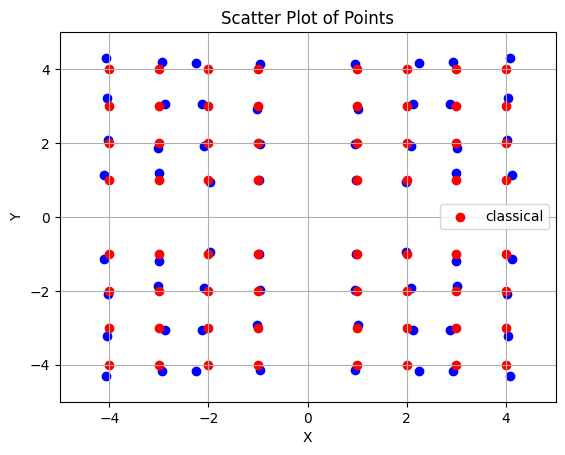

Error = [0.03000375854986949, 0.0655288974993972, 0.2016589724170086, 0.13807728776753725, 0.12661467583492597, 0.11832817159992814, 0.16230407065963554, 0.34135207023383557, 0.10807426388294529, 0.15982234091321887, 0.1557851356650639, 0.24442159758781437, 0.316013913321327, 0.32586707314151575, 0.21037088351233313, 0.37154128060040725]


In [792]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits,"q2")
c = QuantumRegister(1,"q1")
p = QuantumRegister(1,"q3")
color = QuantumRegister(1,"q4")
cr = ClassicalRegister(O.size+c.size+p.size+color.size,"cl")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=244736)
result = job.result()
counts = result.get_counts()
'''
counts['1001000']=0
counts['1011000']=0
counts['1101000']=0
counts['1111000']=0
'''
pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:-2]
        angle_decision = int(key[-2])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)



phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



theta_state_0_ionq = []
for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
#print(color_phi_result_list)


color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):


    #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
    #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

    if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,k_recon,0]))
    
    elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

    elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon,k_recon]))

    elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

    elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([k_recon,0,n_recon]))

    elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
    

color_recon_ionq = list(reversed(color_recon_ionq))
print("Reconstructed color = ",color_recon_ionq)

# Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
print("Reconstructed pixel =",color_list_ionq)


back_2 = [y_axis_reflection(point) for point in back_recon_pixel_ionq]
back_3 = [origin_reflection(point) for point in back_recon_pixel_ionq]
back_4 = [x_axis_reflection(point) for point in back_recon_pixel_ionq]

back_stereo_pixel = back_recon_pixel_ionq + back_2 + back_3 + back_4

x_stereo = [point[0] for point in back_stereo_pixel]
y_stereo = [point[1] for point in back_stereo_pixel]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]
end = time.time()
print(f"{end - start:.5f} sec")


origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)

x_Q_origin = [point[0] for point in Q_origin]
y_Q_origin = [point[1] for point in Q_origin]

# 시각화
plt.scatter(x_stereo, y_stereo, color='blue')
plt.scatter(x_Q_origin, y_Q_origin, color='red', label = 'classical')
plt.title('Scatter Plot of Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.legend()
plt.grid(True)
plt.show()

error_ionq = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values_ionq[i]
    del_y = y_Q[i] - y_values_ionq[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d

print("Error =",error_ionq)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


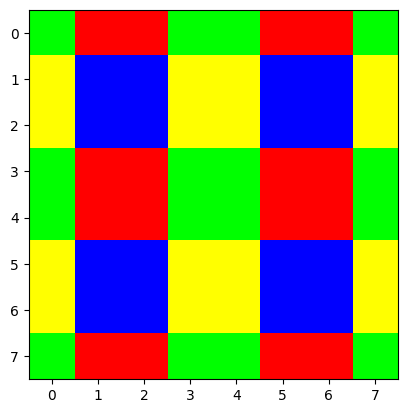

In [793]:
recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
recon_color_array_3 = np.rot90(recon_color_array,k=2)
recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))

color_row1 = np.concatenate((recon_color_array_2,recon_color_array_3), axis=1)
color_row2 = np.concatenate((recon_color_array,recon_color_array_4), axis=1)
final_color_array = np.concatenate((color_row1,color_row2),axis=0)
plt.imshow(final_color_array, cmap = 'gray')

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\4049431078.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o', label = 'Recon')


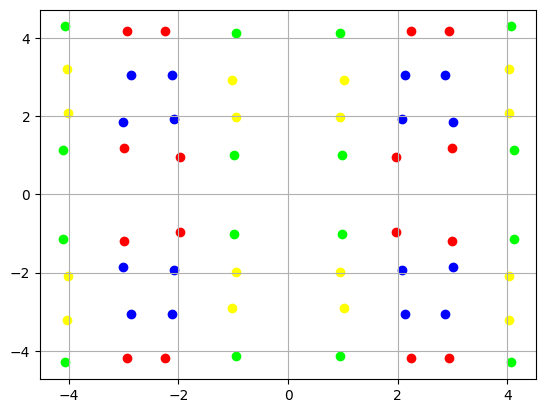

In [794]:
#recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array = np.array(color_recon_ionq).reshape(4,4,3)
color_recon_ionq_1 = recon_color_array.reshape(-1,3).tolist()

recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
color_recon_ionq_2 = recon_color_array_2.reshape(-1,3).tolist()

recon_color_array_3 = np.rot90(recon_color_array,k=2)
color_recon_ionq_3 = recon_color_array_3.reshape(-1,3).tolist()

recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))
color_recon_ionq_4 = recon_color_array_4.reshape(-1,3).tolist()

color_recon_point = color_recon_ionq_1 + color_recon_ionq_2 + color_recon_ionq_3 + color_recon_ionq_4
final_color = np.array(color_recon_point)

for i in range(len(back_stereo_pixel)):
    result_array = (final_color[i] / 255 > 0).astype(int)
    plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o', label = 'Recon')
    #plt.scatter(Q_origin[i][0],Q_origin[i][1],c="gray", label = 'Classical')
    plt.grid(True)
plt.show()

#### iteration에 따른 분석

In [508]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterposMSE = []
itercolorMSE = []
red_error = []
green_error = []
blue_error = []

for iter in range(500):
    ionq_sim = provider.get_backend("ionq_simulator")
    t_qc_image = transpile(qc_image, ionq_sim)
    job = ionq_sim.run(t_qc_image, shots=1024*(iter+1))
    result = job.result()
    counts = result.get_counts()
    '''
    counts['1001000']=0
    counts['1011000']=0
    counts['1101000']=0
    counts['1111000']=0
    '''
    pixel_theta_recon_ionq = []
    pixel_phi_recon_ionq = []

    pixel_theta_ionq = []
    pixel_phi_ionq = []

    pixel_color_theta_recon_ionq = []
    pixel_color_phi_recon_ionq = []

    pixel_color_theta_ionq = []
    pixel_color_phi_ionq = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            bin_coord = key[1:-2]
            angle_decision = int(key[-2])
            switch = int(key[-1]) # switch = 1, position, and switch = 0, color
            int_coord = int(bin_coord, 2)
            if switch == 1:
                if int_coord == i and angle_decision == 1:
                    pixel_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_phi_ionq.append((state,bin_coord, amount))
            elif switch == 0:
                if int_coord == i and angle_decision == 1:
                    pixel_color_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_color_phi_ionq.append((state,bin_coord, amount))

    # position
    # ======================== phi ====================================
    phi_result_dict_ionq = {}
    for state in pixel_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict_ionq:
            phi_result_dict_ionq[key] += value  
        else:
            phi_result_dict_ionq[key] = value  

    phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
    #print(phi_result_list)



    phi_state_0_ionq = []
    for state, phi, amount in pixel_phi_ionq:
        if not int(state):
            phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
            pixel_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict_ionq = {}
    for state in pixel_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict_ionq:
            theta_result_dict_ionq[key] += value  
        else:
            theta_result_dict_ionq[key] = value  

    theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



    theta_state_0_ionq = []
    for state, theta, amount in pixel_theta_ionq:
        if not int(state):
            theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
            pixel_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # color
    # ======================== phi ====================================
    color_phi_result_dict_ionq = {}
    for state in pixel_color_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in color_phi_result_dict_ionq:
            color_phi_result_dict_ionq[key] += value  
        else:
            color_phi_result_dict_ionq[key] = value  

    color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
    #print(color_phi_result_list)


    color_phi_state_0_ionq = []
    for state, phi, amount in pixel_color_phi_ionq:
        if not int(state):
            color_phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
            pixel_color_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    color_theta_result_dict_ionq = {}
    for state in pixel_color_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in color_theta_result_dict_ionq:
            color_theta_result_dict_ionq[key] += value  
        else:
            color_theta_result_dict_ionq[key] = value  

    color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

    color_theta_state_0_ionq = []

    for state, theta, amount in pixel_color_theta_ionq:
        if not int(state):
            color_theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
            pixel_color_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
    # 좌표들의 phi 각도를 보며 유추 할 수 있으므로
    # 순서대로 G,Y,R,B
    color_recon_ionq = []
    for i in range(len(pixel_color_phi_recon_ionq)):
        #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
        #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))
        
        if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,k_recon,0]))
        
        elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

        elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon,k_recon]))

        elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

        elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([k_recon,0,n_recon]))

        elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
    
    color_recon_ionq = list(reversed(color_recon_ionq))
    #print("Reconstructed color = ",color_recon_ionq)

    # Visualization
    recon_pixel_ionq = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        z = np.cos(pixel_theta_recon_ionq[i])
        recon_pixel_ionq.append(np.array([x,y,z]))
    back_recon_pixel_ionq = []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel_ionq[i][0] / k
        Y = recon_pixel_ionq[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel_ionq.append(back_P)
    back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

    color_list_ionq = []
    for i in range(len(back_recon_pixel_ionq)):
        color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)
    x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
    y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    x_Q = [point[0] for point in Q]
    y_Q = [point[1] for point in Q]

    error_ionq = []
    for i in range(len(Q)):
        del_x = x_Q[i] - x_values_ionq[i]
        del_y = y_Q[i] - y_values_ionq[i]
        err_ionq = np.sqrt(del_x**2+del_y**2)
        error_ionq.append(err_ionq)
    MSE = sum(error_ionq)/len(Q)
    iterposMSE.append(MSE)


    error_color = []
    for i in range(len(Q)):
        del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
        del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
        del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
        del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
        error_color.append(del_color)
    colorMSE = sum(error_color)/len(Q)
    itercolorMSE.append(colorMSE)
    red_error.append(del_color_r)
    green_error.append(del_color_g)
    blue_error.append(del_color_b)

    print("iteration = ",(iter+1)*1024)
    print("MSE = ", MSE)
    #print("Red Error = ",del_color_r, "Green Error = ", del_color_g, "Blue Error = ", del_color_b)
    print("Color Error = ", colorMSE)
    print("==========================================================================")

iteration =  1024
MSE =  2.542415866634442
Color Error =  114.40182100467362
iteration =  2048
MSE =  2.027788137494402
Color Error =  54.31309251515858
iteration =  3072
MSE =  1.270278404432562
Color Error =  60.92432542675769
iteration =  4096
MSE =  1.2055543573258485
Color Error =  46.76314360926814
iteration =  5120
MSE =  1.0749947304092409
Color Error =  38.62132825644947
iteration =  6144
MSE =  1.1479266272662123
Color Error =  18.95722718054467
iteration =  7168
MSE =  0.9506441942322721
Color Error =  28.04639876891935
iteration =  8192
MSE =  0.7865719130958221
Color Error =  46.078557910129966
iteration =  9216
MSE =  0.8658937649118201
Color Error =  22.330770215707297
iteration =  10240
MSE =  0.7289613735961347
Color Error =  30.0205914750248
iteration =  11264
MSE =  0.6147862692333345
Color Error =  32.760416666666664
iteration =  12288
MSE =  0.56002183792354
Color Error =  33.14118020250487
iteration =  13312
MSE =  0.5538072227670781
Color Error =  14.166666666666

In [509]:
iters = []
for iter in range(500):
    iters.append((iter+1)*1024)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterposMSE,
                   "Margin" : [0.5]*500,
                   "Color MSE" : itercolorMSE})
df.to_excel("8by8 Image Encoding real IonQ color and position.xlsx")

## Rotation

In [576]:
rotate_angle = 30
Q_rot = Rotation(Q, rotate_angle)

In [795]:
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

rotate_angle = 30
Q_rot = Rotation(Q, rotate_angle)

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

phis_rot = []
for i in range(len(P_rot)):
    phi = round(np.arctan2(P_rot[i][1], P_rot[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_rot.append(phi)
    else:
        phi = round(phi/4,4)
        phis_rot.append(phi)

rotate = []
for i in range(len(P)):
    angle = round((phis_rot[i] - phis[i]),4)
    rotate.append(angle)        

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    
qc_image.x(p)
qc_image.x(O)

for i, (angle, theta) in enumerate(zip(rotate, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            pass
        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*angle,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
qc_image.x(p)
qc_image.x(O)
# reset

qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterposMSE = []
itercolorMSE = []
red_error = []
green_error = []
blue_error = []
for iter in range(500):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc_image, aer_sim)
    qobj = assemble(t_qc, shots=1024*(iter+1))
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()

    pixel_theta_recon_ionq = []
    pixel_phi_recon_ionq = []

    pixel_theta_ionq = []
    pixel_phi_ionq = []

    pixel_color_theta_recon_ionq = []
    pixel_color_phi_recon_ionq = []

    pixel_color_theta_ionq = []
    pixel_color_phi_ionq = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            bin_coord = key[1:-2]
            angle_decision = int(key[-2])
            switch = int(key[-1]) # switch = 1, position, and switch = 0, color
            int_coord = int(bin_coord, 2)
            if switch == 1:
                if int_coord == i and angle_decision == 1:
                    pixel_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_phi_ionq.append((state,bin_coord, amount))
            elif switch == 0:
                if int_coord == i and angle_decision == 1:
                    pixel_color_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_color_phi_ionq.append((state,bin_coord, amount))

    # position
    # ======================== phi ====================================
    phi_result_dict_ionq = {}
    for state in pixel_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict_ionq:
            phi_result_dict_ionq[key] += value  
        else:
            phi_result_dict_ionq[key] = value  

    phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
    #print(phi_result_list)



    phi_state_0_ionq = []
    for state, phi, amount in pixel_phi_ionq:
        if not int(state):
            phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
            pixel_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict_ionq = {}
    for state in pixel_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict_ionq:
            theta_result_dict_ionq[key] += value  
        else:
            theta_result_dict_ionq[key] = value  

    theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



    theta_state_0_ionq = []
    for state, theta, amount in pixel_theta_ionq:
        if not int(state):
            theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
            pixel_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # color
    # ======================== phi ====================================
    color_phi_result_dict_ionq = {}
    for state in pixel_color_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in color_phi_result_dict_ionq:
            color_phi_result_dict_ionq[key] += value  
        else:
            color_phi_result_dict_ionq[key] = value  

    color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
    #print(color_phi_result_list)


    color_phi_state_0_ionq = []
    for state, phi, amount in pixel_color_phi_ionq:
        if not int(state):
            color_phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
            pixel_color_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    color_theta_result_dict_ionq = {}
    for state in pixel_color_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in color_theta_result_dict_ionq:
            color_theta_result_dict_ionq[key] += value  
        else:
            color_theta_result_dict_ionq[key] = value  

    color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

    color_theta_state_0_ionq = []

    for state, theta, amount in pixel_color_theta_ionq:
        if not int(state):
            color_theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
            pixel_color_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
    # 좌표들의 phi 각도를 보며 유추 할 수 있으므로
    # 순서대로 G,Y,R,B
    color_recon_ionq = []
    for i in range(len(pixel_color_phi_recon_ionq)):


        #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
        #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

        if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,k_recon,0]))
        
        elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

        elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon,k_recon]))

        elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

        elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([k_recon,0,n_recon]))

        elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
        

    color_recon_ionq = list(reversed(color_recon_ionq))
    #print("Reconstructed color = ",color_recon_ionq)

    # Visualization
    recon_pixel_ionq = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        z = np.cos(pixel_theta_recon_ionq[i])
        recon_pixel_ionq.append(np.array([x,y,z]))
    back_recon_pixel_ionq = []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel_ionq[i][0] / k
        Y = recon_pixel_ionq[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel_ionq.append(back_P)
    back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

    color_list_ionq = []
    for i in range(len(back_recon_pixel_ionq)):
        color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)

    x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
    y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    # Visualization
    recon_pixel_ionq = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        z = np.cos(pixel_theta_recon_ionq[i])
        recon_pixel_ionq.append(np.array([x,y,z]))
    back_recon_pixel_ionq = []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel_ionq[i][0] / k
        Y = recon_pixel_ionq[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel_ionq.append(back_P)
    back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

    color_list_ionq = []
    for i in range(len(back_recon_pixel_ionq)):
        color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)

    x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
    y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    if rotate_angle % 90 == 0:
        back_2 = [y_axis_reflection(point) for point in back_recon_pixel]
        back_3 = [origin_reflection(point) for point in back_recon_pixel]
        back_4 = [x_axis_reflection(point) for point in back_recon_pixel]
    else:
        back_2 = [rotate_y_axis(point, rotate_angle) for point in back_recon_pixel]
        back_3 = [origin_reflection(point) for point in back_recon_pixel]
        back_4 = [rotate_x_axis(point, rotate_angle) for point in back_recon_pixel]

    x_Q_rot = [point[0] for point in Q_rot]
    y_Q_rot = [point[1] for point in Q_rot]

    error_ionq = []
    for i in range(len(Q)):
        del_x = x_Q_rot[i] - x_values_ionq[i]
        del_y = y_Q_rot[i] - y_values_ionq[i]
        err_ionq = np.sqrt(del_x**2+del_y**2)
        error_ionq.append(err_ionq)
    error_ionq # a,b,c,d
    MSE = sum(error_ionq)/len(Q)
    iterposMSE.append(MSE)
    error_color = []
    for i in range(len(Q)):
        del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
        del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
        del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
        del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
        error_color.append(del_color)
    colorMSE = sum(error_color)/len(Q)
    itercolorMSE.append(colorMSE)
    red_error.append(del_color_r)
    green_error.append(del_color_g)
    blue_error.append(del_color_b)

    print("iteration = ",(iter+1)*1024)
    print("MSE = ", MSE)
    #print("Red Error = ",del_color_r, "Green Error = ", del_color_g, "Blue Error = ", del_color_b)
    print("Color Error = ", colorMSE)
    print("==========================================================================")

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\1075744873.py:200: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)
C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\1075744873.py:312: RuntimeWarning: invalid value encountered in arccos
  phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))


IndexError: list index out of range

In [601]:
iters = []
for iter in range(500):
    iters.append((iter+1)*1024)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterposMSE,
                   "Margin" : [0.5]*500,
                   "Color MSE" : itercolorMSE})
df.to_excel("8by8 Image Rotation Simulation color and position.xlsx")

In [346]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

rotate_angle = 30
Q_rot = Rotation(Q, rotate_angle)

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

phis_rot = []
for i in range(len(P_rot)):
    phi = round(np.arctan2(P_rot[i][1], P_rot[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_rot.append(phi)
    else:
        phi = round(phi/4,4)
        phis_rot.append(phi)

rotate = []
for i in range(len(P)):
    angle = round((phis_rot[i] - phis[i]),4)
    rotate.append(angle)        

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    
qc_image.x(p)
qc_image.x(O)

for i, (angle, theta) in enumerate(zip(rotate, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            pass
        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*angle,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
qc_image.x(p)
qc_image.x(O)
# reset

qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterposMSE = []
itercolorMSE = []
red_error = []
green_error = []
blue_error = []


aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=175104)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:-2]
        angle_decision = int(key[-2])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)



phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



theta_state_0_ionq = []
for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

    # color
    # ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
    #print(color_phi_result_list)


color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
    # ======================== theta ====================================
            
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

    # theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
    # 좌표들의 phi 각도를 보며 유추 할 수 있으므로
    # 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):


        #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
        #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

    if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,k_recon,0]))
        
    elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

    elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon,k_recon]))

    elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

    elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([k_recon,0,n_recon]))

    elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
        

color_recon_ionq = list(reversed(color_recon_ionq))
    #print("Reconstructed color = ",color_recon_ionq)

    # Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)

x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    # Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)

x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

if rotate_angle % 90 == 0:
    back_2 = [y_axis_reflection(point) for point in back_recon_pixel_ionq]
    back_3 = [origin_reflection(point) for point in back_recon_pixel_ionq]
    back_4 = [x_axis_reflection(point) for point in back_recon_pixel_ionq]
else:
    back_2 = [rotate_y_axis(point, rotate_angle) for point in back_recon_pixel_ionq]
    back_3 = [origin_reflection(point) for point in back_recon_pixel_ionq]
    back_4 = [rotate_x_axis(point, rotate_angle) for point in back_recon_pixel_ionq]

back_stereo_pixel = back_recon_pixel_ionq + back_2 + back_3 + back_4

x_stereo = [point[0] for point in back_stereo_pixel]
y_stereo = [point[1] for point in back_stereo_pixel]

end = time.time()
print(f"{end - start:.5f} sec")


x_Q_rot = [point[0] for point in Q_rot]
y_Q_rot = [point[1] for point in Q_rot]

x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)
Q_oritin_rot = Rotation(Q_origin,30)

x_Q_origin = [point[0] for point in Q_oritin_rot]
y_Q_origin = [point[1] for point in Q_oritin_rot]

# 시각화
plt.scatter(x_stereo, y_stereo, color='blue')
plt.scatter(x_Q_origin, y_Q_origin, color='red', label = 'classical')
plt.title('Scatter Plot of Points')
plt.xlabel('X')
plt.ylabel('Y')
#plt.xlim(-5,5)
#plt.ylim(-5,5)
plt.legend()
plt.grid(True)
plt.show()

error_ionq = []
for i in range(len(Q)):
    del_x = x_Q_rot[i] - x_values_ionq[i]
    del_y = y_Q_rot[i] - y_values_ionq[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d
MSE = sum(error_ionq)/len(Q)
iterposMSE.append(MSE)
error_color = []
for i in range(len(Q)):
    del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
    del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
    del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
    del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
    error_color.append(del_color)
colorMSE = sum(error_color)/len(Q)
itercolorMSE.append(colorMSE)
red_error.append(del_color_r)
green_error.append(del_color_g)
blue_error.append(del_color_b)

#print("iteration = ",(iter+1)*1024)
print("MSE = ", MSE)
#print("Red Error = ",del_color_r, "Green Error = ", del_color_g, "Blue Error = ", del_color_b)
print("Color Error = ", colorMSE)
print("==========================================================================")

NameError: name 'P_rot' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


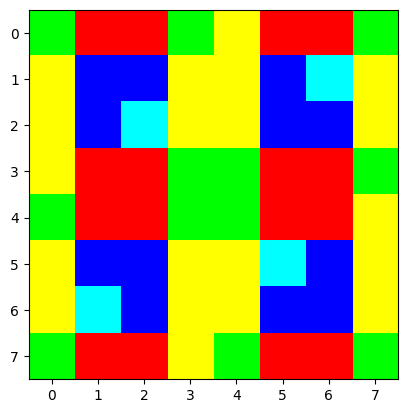

In [797]:
recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
recon_color_array_3 = np.rot90(recon_color_array,k=2)
recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))

color_row1 = np.concatenate((recon_color_array_2,recon_color_array_3), axis=1)
color_row2 = np.concatenate((recon_color_array,recon_color_array_4), axis=1)
final_color_array = np.concatenate((color_row1,color_row2),axis=0)
plt.imshow(final_color_array, cmap = 'gray')

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\1732180051.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o')


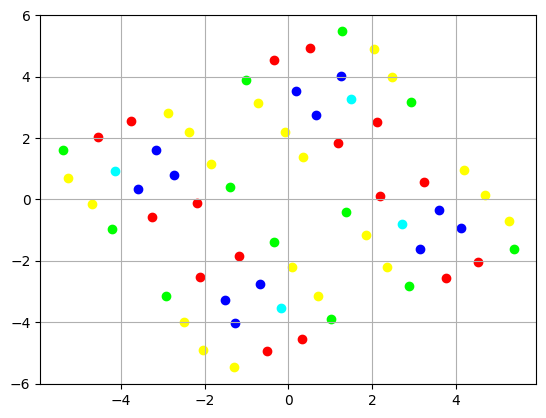

In [798]:
#recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array = np.array(color_recon_ionq).reshape(4,4,3)
color_recon_ionq_1 = recon_color_array.reshape(-1,3).tolist()

recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
color_recon_ionq_2 = recon_color_array_2.reshape(-1,3).tolist()

recon_color_array_3 = np.rot90(recon_color_array,k=2)
color_recon_ionq_3 = recon_color_array_3.reshape(-1,3).tolist()

recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))
color_recon_ionq_4 = recon_color_array_4.reshape(-1,3).tolist()

color_recon_point = color_recon_ionq_1 + color_recon_ionq_2 + color_recon_ionq_3 + color_recon_ionq_4
final_color = np.array(color_recon_point)

for i in range(len(back_stereo_pixel)):
    result_array = (final_color[i] / 255 > 0).astype(int)
    plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o')
    #plt.scatter(Q_origin_rot[i][0],Q_origin_rot[i][1],c="gray")
    plt.grid(True)
plt.show()

#### IonQ

In [624]:
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

rotate_angle = 30
Q_rot = Rotation(Q, rotate_angle)

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

phis_rot = []
for i in range(len(P_rot)):
    phi = round(np.arctan2(P_rot[i][1], P_rot[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_rot.append(phi)
    else:
        phi = round(phi/4,4)
        phis_rot.append(phi)

rotate = []
for i in range(len(P)):
    angle = round((phis_rot[i] - phis[i]),4)
    rotate.append(angle)        

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    
qc_image.x(p)
qc_image.x(O)

for i, (angle, theta) in enumerate(zip(rotate, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            pass
        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*angle,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
qc_image.x(p)
qc_image.x(O)
# reset

qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterposMSE = []
itercolorMSE = []
red_error = []
green_error = []
blue_error = []
for iter in range(500):
    ionq_sim = provider.get_backend("ionq_simulator")
    t_qc_image = transpile(qc_image, ionq_sim)
    job = ionq_sim.run(t_qc_image, shots=1024*(iter+1))
    result = job.result()
    counts = result.get_counts()

    pixel_theta_recon_ionq = []
    pixel_phi_recon_ionq = []

    pixel_theta_ionq = []
    pixel_phi_ionq = []

    pixel_color_theta_recon_ionq = []
    pixel_color_phi_recon_ionq = []

    pixel_color_theta_ionq = []
    pixel_color_phi_ionq = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            bin_coord = key[1:-2]
            angle_decision = int(key[-2])
            switch = int(key[-1]) # switch = 1, position, and switch = 0, color
            int_coord = int(bin_coord, 2)
            if switch == 1:
                if int_coord == i and angle_decision == 1:
                    pixel_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_phi_ionq.append((state,bin_coord, amount))
            elif switch == 0:
                if int_coord == i and angle_decision == 1:
                    pixel_color_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_color_phi_ionq.append((state,bin_coord, amount))

    # position
    # ======================== phi ====================================
    phi_result_dict_ionq = {}
    for state in pixel_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict_ionq:
            phi_result_dict_ionq[key] += value  
        else:
            phi_result_dict_ionq[key] = value  

    phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
    #print(phi_result_list)



    phi_state_0_ionq = []
    for state, phi, amount in pixel_phi_ionq:
        if not int(state):
            phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
            pixel_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict_ionq = {}
    for state in pixel_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict_ionq:
            theta_result_dict_ionq[key] += value  
        else:
            theta_result_dict_ionq[key] = value  

    theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



    theta_state_0_ionq = []
    for state, theta, amount in pixel_theta_ionq:
        if not int(state):
            theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
            pixel_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # color
    # ======================== phi ====================================
    color_phi_result_dict_ionq = {}
    for state in pixel_color_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in color_phi_result_dict_ionq:
            color_phi_result_dict_ionq[key] += value  
        else:
            color_phi_result_dict_ionq[key] = value  

    color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
    #print(color_phi_result_list)


    color_phi_state_0_ionq = []
    for state, phi, amount in pixel_color_phi_ionq:
        if not int(state):
            color_phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
            pixel_color_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    color_theta_result_dict_ionq = {}
    for state in pixel_color_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in color_theta_result_dict_ionq:
            color_theta_result_dict_ionq[key] += value  
        else:
            color_theta_result_dict_ionq[key] = value  

    color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

    color_theta_state_0_ionq = []

    for state, theta, amount in pixel_color_theta_ionq:
        if not int(state):
            color_theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
            pixel_color_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
    # 좌표들의 phi 각도를 보며 유추 할 수 있으므로
    # 순서대로 G,Y,R,B
    color_recon_ionq = []
    for i in range(len(pixel_color_phi_recon_ionq)):


        #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
        #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

        if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,k_recon,0]))
        
        elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

        elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon,k_recon]))

        elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

        elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([k_recon,0,n_recon]))

        elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
        

    color_recon_ionq = list(reversed(color_recon_ionq))
    #print("Reconstructed color = ",color_recon_ionq)

    # Visualization
    recon_pixel_ionq = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        z = np.cos(pixel_theta_recon_ionq[i])
        recon_pixel_ionq.append(np.array([x,y,z]))
    back_recon_pixel_ionq = []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel_ionq[i][0] / k
        Y = recon_pixel_ionq[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel_ionq.append(back_P)
    back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

    color_list_ionq = []
    for i in range(len(back_recon_pixel_ionq)):
        color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)

    x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
    y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    # Visualization
    recon_pixel_ionq = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        z = np.cos(pixel_theta_recon_ionq[i])
        recon_pixel_ionq.append(np.array([x,y,z]))
    back_recon_pixel_ionq = []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel_ionq[i][0] / k
        Y = recon_pixel_ionq[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel_ionq.append(back_P)
    back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

    color_list_ionq = []
    for i in range(len(back_recon_pixel_ionq)):
        color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)

    x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
    y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    if rotate_angle % 90 == 0:
        back_2 = [y_axis_reflection(point) for point in back_recon_pixel]
        back_3 = [origin_reflection(point) for point in back_recon_pixel]
        back_4 = [x_axis_reflection(point) for point in back_recon_pixel]
    else:
        back_2 = [rotate_y_axis(point, rotate_angle) for point in back_recon_pixel]
        back_3 = [origin_reflection(point) for point in back_recon_pixel]
        back_4 = [rotate_x_axis(point, rotate_angle) for point in back_recon_pixel]

    x_Q_rot = [point[0] for point in Q_rot]
    y_Q_rot = [point[1] for point in Q_rot]

    error_ionq = []
    for i in range(len(Q)):
        del_x = x_Q_rot[i] - x_values_ionq[i]
        del_y = y_Q_rot[i] - y_values_ionq[i]
        err_ionq = np.sqrt(del_x**2+del_y**2)
        error_ionq.append(err_ionq)
    error_ionq # a,b,c,d
    MSE = sum(error_ionq)/len(Q)
    iterposMSE.append(MSE)
    error_color = []
    for i in range(len(Q)):
        del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
        del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
        del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
        del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
        error_color.append(del_color)
    colorMSE = sum(error_color)/len(Q)
    itercolorMSE.append(colorMSE)
    red_error.append(del_color_r)
    green_error.append(del_color_g)
    blue_error.append(del_color_b)

    print("iteration = ",(iter+1)*1024)
    print("MSE = ", MSE)
    #print("Red Error = ",del_color_r, "Green Error = ", del_color_g, "Blue Error = ", del_color_b)
    print("Color Error = ", colorMSE)
    print("==========================================================================")

iteration =  1024
MSE =  2.2176882507288513
Color Error =  102.61584376140831
iteration =  2048
MSE =  2.1501960635308754
Color Error =  59.500767079971936
iteration =  3072
MSE =  1.1302223328603629
Color Error =  41.367475349705884
iteration =  4096
MSE =  0.9778194087718107
Color Error =  48.87560390751058
iteration =  5120
MSE =  0.9159862106886879
Color Error =  39.69919468875602
iteration =  6144
MSE =  0.8855199615688758
Color Error =  44.15581109349898
iteration =  7168
MSE =  0.5970587001660739
Color Error =  32.37566886680263
iteration =  8192
MSE =  0.5678119438228161
Color Error =  32.696782188691444
iteration =  9216
MSE =  0.6831553283173025
Color Error =  22.430555555555554
iteration =  10240
MSE =  0.5033820572162457
Color Error =  20.954861111111107
iteration =  11264
MSE =  0.774143279163558
Color Error =  37.36158292972125
iteration =  12288
MSE =  0.5462589219169315
Color Error =  22.13541666666667
iteration =  13312
MSE =  0.613857761841841
Color Error =  24.791666

In [625]:
iters = []
for iter in range(500):
    iters.append((iter+1)*1024)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterposMSE,
                   "Margin" : [0.5]*500,
                   "Color MSE" : itercolorMSE})
df.to_excel("8by8 Image Rotation IonQ color and position.xlsx")

5.12178 sec


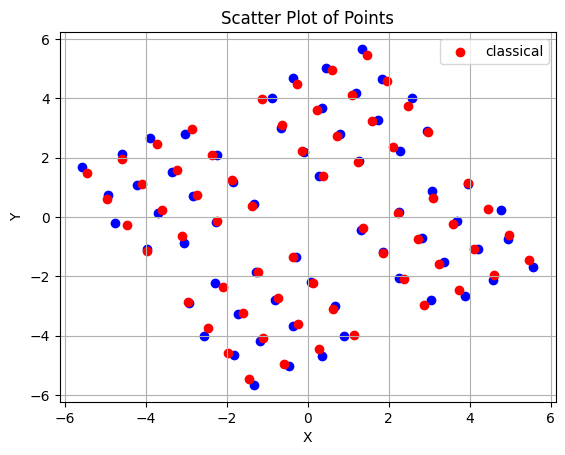

MSE =  0.15173880064647852
Color Error =  2.65625


In [799]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

rotate_angle = 30
Q_rot = Rotation(Q, rotate_angle)

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

phis_rot = []
for i in range(len(P_rot)):
    phi = round(np.arctan2(P_rot[i][1], P_rot[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_rot.append(phi)
    else:
        phi = round(phi/4,4)
        phis_rot.append(phi)

rotate = []
for i in range(len(P)):
    angle = round((phis_rot[i] - phis[i]),4)
    rotate.append(angle)        

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    
qc_image.x(p)
qc_image.x(O)

for i, (angle, theta) in enumerate(zip(rotate, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            pass
        else:
            qc_image.x(p) # p = 0, phi

            qc_image.mcry(theta=2*angle,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
qc_image.x(p)
qc_image.x(O)
# reset

qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterposMSE = []
itercolorMSE = []
red_error = []
green_error = []
blue_error = []


ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=164864)
result = job.result()
counts = result.get_counts()

pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:-2]
        angle_decision = int(key[-2])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)



phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



theta_state_0_ionq = []
for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

    # color
    # ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
    #print(color_phi_result_list)


color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
    # ======================== theta ====================================
            
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

    # theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
    # 좌표들의 phi 각도를 보며 유추 할 수 있으므로
    # 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):


        #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
        #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

    if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,k_recon,0]))
        
    elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

    elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon,k_recon]))

    elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

    elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([k_recon,0,n_recon]))

    elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
        

color_recon_ionq = list(reversed(color_recon_ionq))
    #print("Reconstructed color = ",color_recon_ionq)

    # Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)

x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    # Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)

x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

if rotate_angle % 90 == 0:
    back_2 = [y_axis_reflection(point) for point in back_recon_pixel_ionq]
    back_3 = [origin_reflection(point) for point in back_recon_pixel_ionq]
    back_4 = [x_axis_reflection(point) for point in back_recon_pixel_ionq]
else:
    back_2 = [rotate_y_axis(point, rotate_angle) for point in back_recon_pixel_ionq]
    back_3 = [origin_reflection(point) for point in back_recon_pixel_ionq]
    back_4 = [rotate_x_axis(point, rotate_angle) for point in back_recon_pixel_ionq]

back_stereo_pixel = back_recon_pixel_ionq + back_2 + back_3 + back_4

x_stereo = [point[0] for point in back_stereo_pixel]
y_stereo = [point[1] for point in back_stereo_pixel]

end = time.time()
print(f"{end - start:.5f} sec")


x_Q_rot = [point[0] for point in Q_rot]
y_Q_rot = [point[1] for point in Q_rot]

x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)
Q_oritin_rot = Rotation(Q_origin,30)

x_Q_origin = [point[0] for point in Q_oritin_rot]
y_Q_origin = [point[1] for point in Q_oritin_rot]

# 시각화
plt.scatter(x_stereo, y_stereo, color='blue')
plt.scatter(x_Q_origin, y_Q_origin, color='red', label = 'classical')
plt.title('Scatter Plot of Points')
plt.xlabel('X')
plt.ylabel('Y')
#plt.xlim(-5,5)
#plt.ylim(-5,5)
plt.legend()
plt.grid(True)
plt.show()

error_ionq = []
for i in range(len(Q)):
    del_x = x_Q_rot[i] - x_values_ionq[i]
    del_y = y_Q_rot[i] - y_values_ionq[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d
MSE = sum(error_ionq)/len(Q)
iterposMSE.append(MSE)
error_color = []
for i in range(len(Q)):
    del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
    del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
    del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
    del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
    error_color.append(del_color)
colorMSE = sum(error_color)/len(Q)
itercolorMSE.append(colorMSE)
red_error.append(del_color_r)
green_error.append(del_color_g)
blue_error.append(del_color_b)

#print("iteration = ",(iter+1)*1024)
print("MSE = ", MSE)
#print("Red Error = ",del_color_r, "Green Error = ", del_color_g, "Blue Error = ", del_color_b)
print("Color Error = ", colorMSE)
print("==========================================================================")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


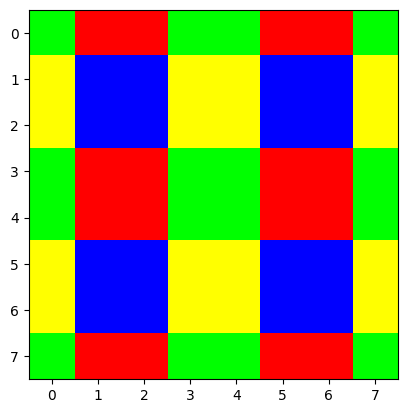

In [800]:
recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
recon_color_array_3 = np.rot90(recon_color_array,k=2)
recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))

color_row1 = np.concatenate((recon_color_array_2,recon_color_array_3), axis=1)
color_row2 = np.concatenate((recon_color_array,recon_color_array_4), axis=1)
final_color_array = np.concatenate((color_row1,color_row2),axis=0)
plt.imshow(final_color_array, cmap = 'gray')

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\3539636243.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o', label = 'Recon')


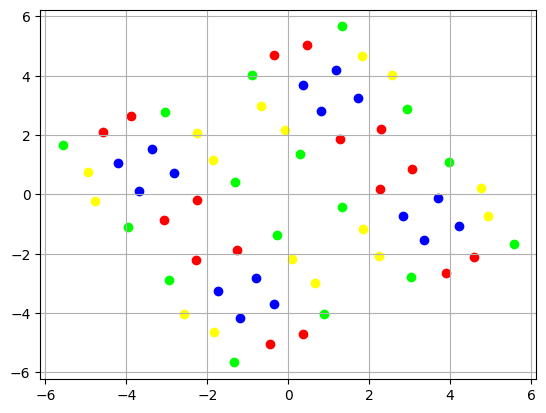

In [801]:
#recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array = np.array(color_recon_ionq).reshape(4,4,3)
color_recon_ionq_1 = recon_color_array.reshape(-1,3).tolist()

recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
color_recon_ionq_2 = recon_color_array_2.reshape(-1,3).tolist()

recon_color_array_3 = np.rot90(recon_color_array,k=2)
color_recon_ionq_3 = recon_color_array_3.reshape(-1,3).tolist()

recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))
color_recon_ionq_4 = recon_color_array_4.reshape(-1,3).tolist()

color_recon_point = color_recon_ionq_1 + color_recon_ionq_2 + color_recon_ionq_3 + color_recon_ionq_4
final_color = np.array(color_recon_point)

for i in range(len(back_stereo_pixel)):
    result_array = (final_color[i] / 255 > 0).astype(int)
    plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o', label = 'Recon')
    #plt.scatter(Q_oritin_rot[i][0],Q_oritin_rot[i][1],c="gray", label = 'Classical')
    plt.grid(True)
plt.show()

## Translation

In [515]:
Q_tra = Transition(Q,2,3)

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\3799803917.py:201: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


Reconstructed color =  [array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.])]
Reconstructed pixel = [[array([3.27388935, 4.19145183, 0.        ])], [array([3.06760199, 4.74910482, 0.        ])], [array([3.2133536 , 5.84932473, 0.        ])], [array([3.25121653, 7.77178638, 0.        ])], [array([3.89348387, 3.79142898, 0.        ])], [array([3.79930824, 5.33446749, 0.        ])], [array([3.98327732, 6.07828959, 0.        ])], [array([4.16871558, 7.03052641, 0.        ])], [array([5.25867266, 3.42979682, 0.        ])], [array([5.23857165, 4.4265019 , 0.        ])], [array([5.48736459, 5.45711898, 0.        ])], [arr

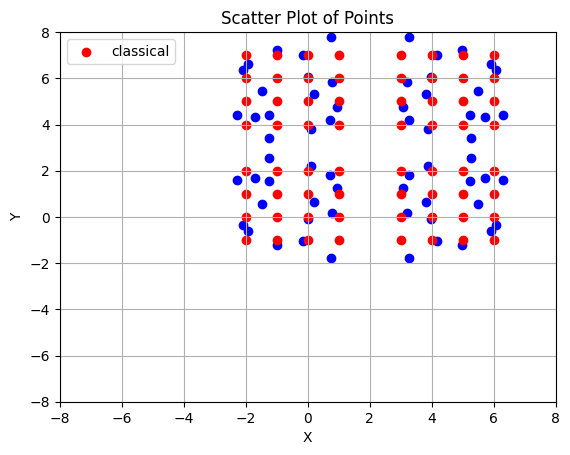

Error = [0.334169389828692, 0.2598430693101439, 0.261194938107059, 0.8116427588579285, 0.23419555371549725, 0.3900585703875101, 0.08005565839620911, 0.17145497148693434, 0.6261335444000243, 0.6211412897970584, 0.7295505788882828, 0.23477160779066428, 0.4395440084217874, 0.6667340488676637, 0.38057382565968406, 0.37868699843195436]
MSE =  0.41373442577169334
Color Error =  0.0


In [805]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

phis_tra = []
for i in range(len(P_tra)):
    phi = round(np.arctan2(P_tra[i][1], P_tra[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_tra.append(phi)
    else:
        phi = round(phi/4,4)
        phis_tra.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

thetas_tra = []
for i in range(len(P_tra)):
    theta = round(np.arccos(P_tra[i][2])/2,4)
    thetas_tra.append(theta)

thetas_del = []
phis_del = []
for i in range(len(thetas)):
    theta_del = round(thetas_tra[i]-thetas[i],4)
    thetas_del.append(theta_del)
    phi_del = round(phis_tra[i]-phis[i],4)
    phis_del.append(phi_del)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
# reset

for i, (phi, theta) in enumerate(zip(phis_del, thetas_del)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
qc_image.x(p)
qc_image.x(O)
# reset

qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=198656)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
'''
counts['1001000']=0
counts['1011000']=0
counts['1101000']=0
counts['1111000']=0
'''
pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:-2]
        angle_decision = int(key[-2])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)



phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



theta_state_0_ionq = []
for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
#print(color_phi_result_list)


color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):


    #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
    #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

    if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,k_recon,0]))
    
    elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

    elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon,k_recon]))

    elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

    elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([k_recon,0,n_recon]))

    elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
    

color_recon_ionq = list(reversed(color_recon_ionq))
print("Reconstructed color = ",color_recon_ionq)

# Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
print("Reconstructed pixel =",color_list_ionq)


back_2 = [y_axis_transition(point,3) for point in back_recon_pixel_ionq]
back_3 = [origin_transition(point,2,3) for point in back_recon_pixel_ionq]
back_4 = [x_axis_transition(point,2) for point in back_recon_pixel_ionq]

back_stereo_pixel = back_recon_pixel_ionq + back_2 + back_3 + back_4

x_stereo = [point[0] for point in back_stereo_pixel]
y_stereo = [point[1] for point in back_stereo_pixel]


end = time.time()
print(f"{end - start:.5f} sec")

x_Q_tra = [point[0] for point in Q_tra]
y_Q_tra = [point[1] for point in Q_tra]

x_values = [point[0] for point in back_recon_pixel_ionq]
y_values = [point[1] for point in back_recon_pixel_ionq]

origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)
Q_oritin_tra = Transition(Q_origin,2,3)

x_Q_origin = [point[0] for point in Q_oritin_tra]
y_Q_origin = [point[1] for point in Q_oritin_tra]

# 시각화
plt.scatter(x_stereo, y_stereo, color='blue')
plt.scatter(x_Q_origin, y_Q_origin, color='red', label = 'classical')
plt.title('Scatter Plot of Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.legend()
plt.grid(True)
plt.show()

error_ionq = []
for i in range(len(Q)):
    del_x = x_Q_tra[i] - x_values[i]
    del_y = y_Q_tra[i] - y_values[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d
MSE = sum(error_ionq)/len(Q)

error_color = []
for i in range(len(Q)):
    del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
    del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
    del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
    del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
    error_color.append(del_color)
colorMSE = sum(error_color)/len(Q)
red_error.append(del_color_r)
green_error.append(del_color_g)
blue_error.append(del_color_b)

print("Error =",error_ionq)
print("=============================")
print("MSE = ",MSE)
print("Color Error = ", colorMSE)
print("==========================================================================")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


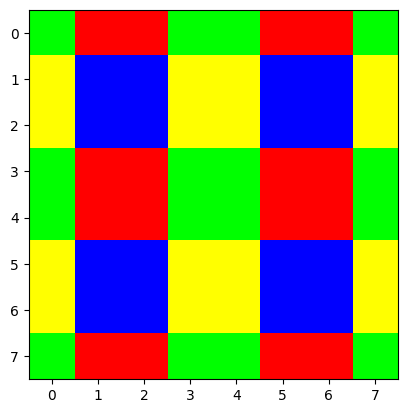

In [806]:
recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
recon_color_array_3 = np.rot90(recon_color_array,k=2)
recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))

color_row1 = np.concatenate((recon_color_array_2,recon_color_array_3), axis=1)
color_row2 = np.concatenate((recon_color_array,recon_color_array_4), axis=1)
final_color_array = np.concatenate((color_row1,color_row2),axis=0)
plt.imshow(final_color_array, cmap = 'gray')

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\1372476462.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o')


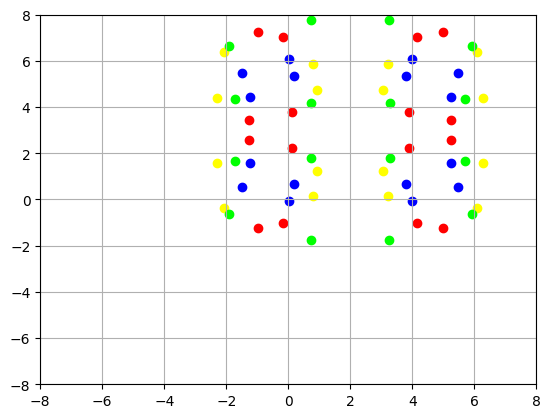

In [807]:
#recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array = np.array(color_recon_ionq).reshape(4,4,3)
color_recon_ionq_1 = recon_color_array.reshape(-1,3).tolist()

recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
color_recon_ionq_2 = recon_color_array_2.reshape(-1,3).tolist()

recon_color_array_3 = np.rot90(recon_color_array,k=2)
color_recon_ionq_3 = recon_color_array_3.reshape(-1,3).tolist()

recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))
color_recon_ionq_4 = recon_color_array_4.reshape(-1,3).tolist()

color_recon_point = color_recon_ionq_1 + color_recon_ionq_2 + color_recon_ionq_3 + color_recon_ionq_4
final_color = np.array(color_recon_point)

for i in range(len(back_stereo_pixel)):
    result_array = (final_color[i] / 255 > 0).astype(int)
    plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o')
    #plt.scatter(Q_oritin_tra[i][0],Q_oritin_tra[i][1],c="gray")
    plt.xlim(-8,8)
    plt.ylim(-8,8)
    plt.grid(True)
plt.show()

#### Iteration에 따른 성능 분석

In [574]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

phis_tra = []
for i in range(len(P_tra)):
    phi = round(np.arctan2(P_tra[i][1], P_tra[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_tra.append(phi)
    else:
        phi = round(phi/4,4)
        phis_tra.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

thetas_tra = []
for i in range(len(P_tra)):
    theta = round(np.arccos(P_tra[i][2])/2,4)
    thetas_tra.append(theta)

thetas_del = []
phis_del = []
for i in range(len(thetas)):
    theta_del = round(thetas_tra[i]-thetas[i],4)
    thetas_del.append(theta_del)
    phi_del = round(phis_tra[i]-phis[i],4)
    phis_del.append(phi_del)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
# reset

for i, (phi, theta) in enumerate(zip(phis_del, thetas_del)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
qc_image.x(p)
qc_image.x(O)
# reset

qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterposMSE = []
itercolorMSE = []
red_error = []
green_error = []
blue_error = []
for iter in range(500):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc_image, aer_sim)
    qobj = assemble(t_qc, shots=1024*(iter+1))
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()
    '''
    counts['1001000']=0
    counts['1011000']=0
    counts['1101000']=0
    counts['1111000']=0
    '''
    pixel_theta_recon_ionq = []
    pixel_phi_recon_ionq = []

    pixel_theta_ionq = []
    pixel_phi_ionq = []

    pixel_color_theta_recon_ionq = []
    pixel_color_phi_recon_ionq = []

    pixel_color_theta_ionq = []
    pixel_color_phi_ionq = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            bin_coord = key[1:-2]
            angle_decision = int(key[-2])
            switch = int(key[-1]) # switch = 1, position, and switch = 0, color
            int_coord = int(bin_coord, 2)
            if switch == 1:
                if int_coord == i and angle_decision == 1:
                    pixel_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_phi_ionq.append((state,bin_coord, amount))
            elif switch == 0:
                if int_coord == i and angle_decision == 1:
                    pixel_color_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_color_phi_ionq.append((state,bin_coord, amount))

    # position
    # ======================== phi ====================================
    phi_result_dict_ionq = {}
    for state in pixel_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict_ionq:
            phi_result_dict_ionq[key] += value  
        else:
            phi_result_dict_ionq[key] = value  

    phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
    #print(phi_result_list)



    phi_state_0_ionq = []
    for state, phi, amount in pixel_phi_ionq:
        if not int(state):
            phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
            pixel_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict_ionq = {}
    for state in pixel_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict_ionq:
            theta_result_dict_ionq[key] += value  
        else:
            theta_result_dict_ionq[key] = value  

    theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



    theta_state_0_ionq = []
    for state, theta, amount in pixel_theta_ionq:
        if not int(state):
            theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
            pixel_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # color
    # ======================== phi ====================================
    color_phi_result_dict_ionq = {}
    for state in pixel_color_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in color_phi_result_dict_ionq:
            color_phi_result_dict_ionq[key] += value  
        else:
            color_phi_result_dict_ionq[key] = value  

    color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
    #print(color_phi_result_list)


    color_phi_state_0_ionq = []
    for state, phi, amount in pixel_color_phi_ionq:
        if not int(state):
            color_phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
            pixel_color_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    color_theta_result_dict_ionq = {}
    for state in pixel_color_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in color_theta_result_dict_ionq:
            color_theta_result_dict_ionq[key] += value  
        else:
            color_theta_result_dict_ionq[key] = value  

    color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

    color_theta_state_0_ionq = []

    for state, theta, amount in pixel_color_theta_ionq:
        if not int(state):
            color_theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
            pixel_color_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
    # 좌표들의 phi 각도를 보며 유추 할 수 있으므로
    # 순서대로 G,Y,R,B
    color_recon_ionq = []
    for i in range(len(pixel_color_phi_recon_ionq)):


        #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
        #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

        if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,k_recon,0]))
        
        elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

        elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon,k_recon]))

        elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

        elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([k_recon,0,n_recon]))

        elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
        

    color_recon_ionq = list(reversed(color_recon_ionq))
    #print("Reconstructed color = ",color_recon_ionq)

    # Visualization
    recon_pixel_ionq = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        z = np.cos(pixel_theta_recon_ionq[i])
        recon_pixel_ionq.append(np.array([x,y,z]))
    back_recon_pixel_ionq = []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel_ionq[i][0] / k
        Y = recon_pixel_ionq[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel_ionq.append(back_P)
    back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

    color_list_ionq = []
    for i in range(len(back_recon_pixel_ionq)):
        color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)

    x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
    y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    x_Q_tra = [point[0] for point in Q_tra]
    y_Q_tra = [point[1] for point in Q_tra]

    error_ionq = []
    for i in range(len(Q)):
        del_x = x_Q_tra[i] - x_values_ionq[i]
        del_y = y_Q_tra[i] - y_values_ionq[i]
        err_ionq = np.sqrt(del_x**2+del_y**2)
        error_ionq.append(err_ionq)
    error_ionq # a,b,c,d
    MSE = sum(error_ionq)/len(Q)
    iterposMSE.append(MSE)
    error_color = []
    for i in range(len(Q)):
        del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
        del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
        del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
        del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
        error_color.append(del_color)
    colorMSE = sum(error_color)/len(Q)
    itercolorMSE.append(colorMSE)
    red_error.append(del_color_r)
    green_error.append(del_color_g)
    blue_error.append(del_color_b)

    print("iteration = ",(iter+1)*1024)
    print("MSE = ", MSE)
    #print("Red Error = ",del_color_r, "Green Error = ", del_color_g, "Blue Error = ", del_color_b)
    print("Color Error = ", colorMSE)
    print("==========================================================================")

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\4006273675.py:207: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


iteration =  1024
MSE =  5.773177939909979
Color Error =  122.3457632788812
iteration =  2048
MSE =  4.386656804456798
Color Error =  61.37233817924256
iteration =  3072
MSE =  3.870393368338102
Color Error =  50.64173384204739
iteration =  4096
MSE =  3.291289093577083
Color Error =  48.15928327910677
iteration =  5120
MSE =  2.976851111138635
Color Error =  36.550480146428306
iteration =  6144
MSE =  2.553273732209062
Color Error =  40.61414442683232
iteration =  7168
MSE =  2.2551044159042384
Color Error =  30.725301968574456
iteration =  8192
MSE =  2.671399699643395
Color Error =  32.40164329980256
iteration =  9216
MSE =  1.388476968976728
Color Error =  23.164058738924574
iteration =  10240
MSE =  1.6684315091325086
Color Error =  43.22092064175605
iteration =  11264
MSE =  1.6253448130621404
Color Error =  22.93725814169147
iteration =  12288
MSE =  1.11486535829164
Color Error =  24.34039716382424
iteration =  13312
MSE =  1.5134933687638306
Color Error =  19.62239207225791
it

In [575]:
iters = []
for iter in range(500):
    iters.append((iter+1)*1024)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterposMSE,
                   "Margin" : [0.5]*500,
                   "Color MSE" : itercolorMSE})
df.to_excel("8by8 Image Translation Simulation color and position.xlsx")

### IonQ

Reconstructed color =  [array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.])]
Reconstructed pixel = [[array([2.87067796, 4.18568308, 0.        ])], [array([2.9198881 , 5.09405395, 0.        ])], [array([2.81575004, 5.6790285 , 0.        ])], [array([2.77311386, 7.1562283 , 0.        ])], [array([4.27456914, 4.05812638, 0.        ])], [array([3.99771155, 4.91913944, 0.        ])], [array([3.86974404, 5.59663694, 0.        ])], [array([3.97198712, 7.13076293, 0.        ])], [array([4.80488409, 4.25479681, 0.        ])], [array([4.9867325 , 5.40860182, 0.        ])], [array([5.49417024, 5.62967519, 0.        ])], [arr

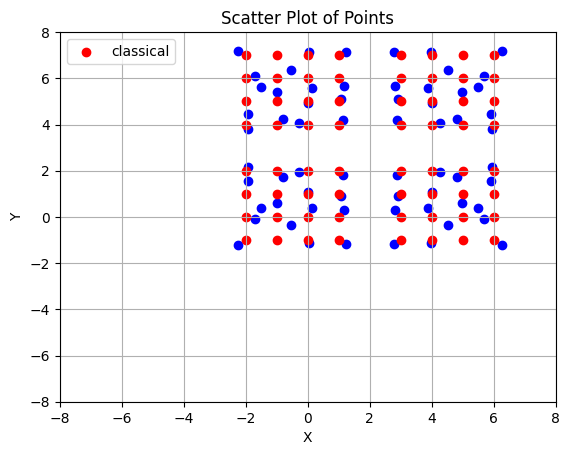

Error = [0.22627946734150706, 0.12354781283378415, 0.3700955942367775, 0.2754715998688421, 0.28065439233498085, 0.08089293739323776, 0.42387306402029995, 0.13372981714415863, 0.3209230901401601, 0.408817160851033, 0.617531126093691, 0.7939067828699936, 0.1924790346328774, 0.5628235606016027, 0.31513544080298694, 0.32952670998555544]
MSE =  0.340980474446968
Color Error =  0.0


In [814]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

phis_tra = []
for i in range(len(P_tra)):
    phi = round(np.arctan2(P_tra[i][1], P_tra[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_tra.append(phi)
    else:
        phi = round(phi/4,4)
        phis_tra.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

thetas_tra = []
for i in range(len(P_tra)):
    theta = round(np.arccos(P_tra[i][2])/2,4)
    thetas_tra.append(theta)

thetas_del = []
phis_del = []
for i in range(len(thetas)):
    theta_del = round(thetas_tra[i]-thetas[i],4)
    thetas_del.append(theta_del)
    phi_del = round(phis_tra[i]-phis[i],4)
    phis_del.append(phi_del)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
# reset

for i, (phi, theta) in enumerate(zip(phis_del, thetas_del)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
qc_image.x(p)
qc_image.x(O)
# reset

qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=205824)
result = job.result()
counts = result.get_counts()
'''
counts['1001000']=0
counts['1011000']=0
counts['1101000']=0
counts['1111000']=0
'''
pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:-2]
        angle_decision = int(key[-2])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)



phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



theta_state_0_ionq = []
for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
#print(color_phi_result_list)


color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):


    #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
    #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

    if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,k_recon,0]))
    
    elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

    elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon,k_recon]))

    elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

    elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([k_recon,0,n_recon]))

    elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
    

color_recon_ionq = list(reversed(color_recon_ionq))
print("Reconstructed color = ",color_recon_ionq)

# Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
print("Reconstructed pixel =",color_list_ionq)


back_2 = [y_axis_transition(point,3) for point in back_recon_pixel_ionq]
back_3 = [origin_transition(point,2,3) for point in back_recon_pixel_ionq]
back_4 = [x_axis_transition(point,2) for point in back_recon_pixel_ionq]

back_stereo_pixel = back_recon_pixel_ionq + back_2 + back_3 + back_4

x_stereo = [point[0] for point in back_stereo_pixel]
y_stereo = [point[1] for point in back_stereo_pixel]


end = time.time()
print(f"{end - start:.5f} sec")

x_Q_tra = [point[0] for point in Q_tra]
y_Q_tra = [point[1] for point in Q_tra]

x_values = [point[0] for point in back_recon_pixel_ionq]
y_values = [point[1] for point in back_recon_pixel_ionq]

origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)
Q_oritin_tra = Transition(Q_origin,2,3)

x_Q_origin = [point[0] for point in Q_oritin_tra]
y_Q_origin = [point[1] for point in Q_oritin_tra]

# 시각화
plt.scatter(x_stereo, y_stereo, color='blue')
plt.scatter(x_Q_origin, y_Q_origin, color='red', label = 'classical')
plt.title('Scatter Plot of Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.legend()
plt.grid(True)
plt.show()

error_ionq = []
for i in range(len(Q)):
    del_x = x_Q_tra[i] - x_values[i]
    del_y = y_Q_tra[i] - y_values[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d
MSE = sum(error_ionq)/len(Q)

error_color = []
for i in range(len(Q)):
    del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
    del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
    del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
    del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
    error_color.append(del_color)
colorMSE = sum(error_color)/len(Q)
red_error.append(del_color_r)
green_error.append(del_color_g)
blue_error.append(del_color_b)

print("Error =",error_ionq)
print("=============================")
print("MSE = ",MSE)
print("Color Error = ", colorMSE)
print("==========================================================================")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


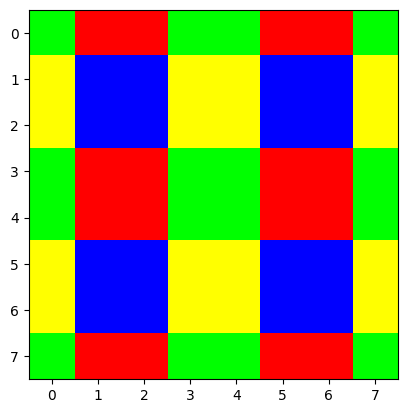

In [815]:
recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
recon_color_array_3 = np.rot90(recon_color_array,k=2)
recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))

color_row1 = np.concatenate((recon_color_array_2,recon_color_array_3), axis=1)
color_row2 = np.concatenate((recon_color_array,recon_color_array_4), axis=1)
final_color_array = np.concatenate((color_row1,color_row2),axis=0)
plt.imshow(final_color_array, cmap = 'gray')

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\1372476462.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o')


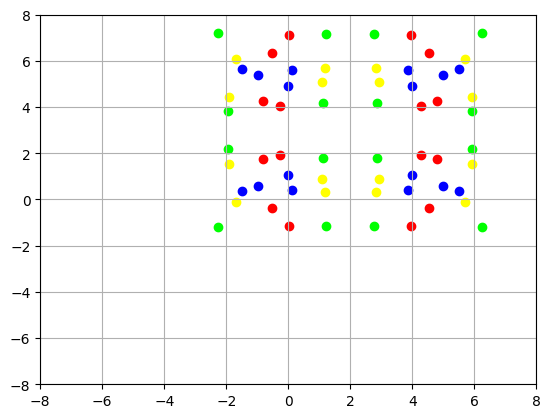

In [816]:
#recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array = np.array(color_recon_ionq).reshape(4,4,3)
color_recon_ionq_1 = recon_color_array.reshape(-1,3).tolist()

recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
color_recon_ionq_2 = recon_color_array_2.reshape(-1,3).tolist()

recon_color_array_3 = np.rot90(recon_color_array,k=2)
color_recon_ionq_3 = recon_color_array_3.reshape(-1,3).tolist()

recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))
color_recon_ionq_4 = recon_color_array_4.reshape(-1,3).tolist()

color_recon_point = color_recon_ionq_1 + color_recon_ionq_2 + color_recon_ionq_3 + color_recon_ionq_4
final_color = np.array(color_recon_point)

for i in range(len(back_stereo_pixel)):
    result_array = (final_color[i] / 255 > 0).astype(int)
    plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o')
    #plt.scatter(Q_oritin_tra[i][0],Q_oritin_tra[i][1],c="gray")
    plt.xlim(-8,8)
    plt.ylim(-8,8)
    plt.grid(True)
plt.show()

#### Iteration에 따른 성능분석

In [622]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

phis_tra = []
for i in range(len(P_tra)):
    phi = round(np.arctan2(P_tra[i][1], P_tra[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_tra.append(phi)
    else:
        phi = round(phi/4,4)
        phis_tra.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

thetas_tra = []
for i in range(len(P_tra)):
    theta = round(np.arccos(P_tra[i][2])/2,4)
    thetas_tra.append(theta)

thetas_del = []
phis_del = []
for i in range(len(thetas)):
    theta_del = round(thetas_tra[i]-thetas[i],4)
    thetas_del.append(theta_del)
    phi_del = round(phis_tra[i]-phis[i],4)
    phis_del.append(phi_del)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
# reset

for i, (phi, theta) in enumerate(zip(phis_del, thetas_del)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
qc_image.x(p)
qc_image.x(O)
# reset

qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

iterposMSE = []
itercolorMSE = []
red_error = []
green_error = []
blue_error = []

for iter in range(500):
    ionq_sim = provider.get_backend("ionq_simulator")
    t_qc_image = transpile(qc_image, ionq_sim)
    job = ionq_sim.run(t_qc_image, shots=1024*(iter+1))
    result = job.result()
    counts = result.get_counts()
    '''
    counts['1001000']=0
    counts['1011000']=0
    counts['1101000']=0
    counts['1111000']=0
    '''
    pixel_theta_recon_ionq = []
    pixel_phi_recon_ionq = []

    pixel_theta_ionq = []
    pixel_phi_ionq = []

    pixel_color_theta_recon_ionq = []
    pixel_color_phi_recon_ionq = []

    pixel_color_theta_ionq = []
    pixel_color_phi_ionq = []

    for i in range(0, len(P)):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            bin_coord = key[1:-2]
            angle_decision = int(key[-2])
            switch = int(key[-1]) # switch = 1, position, and switch = 0, color
            int_coord = int(bin_coord, 2)
            if switch == 1:
                if int_coord == i and angle_decision == 1:
                    pixel_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_phi_ionq.append((state,bin_coord, amount))
            elif switch == 0:
                if int_coord == i and angle_decision == 1:
                    pixel_color_theta_ionq.append((state,bin_coord, amount))
                elif int_coord == i and angle_decision == 0:
                    pixel_color_phi_ionq.append((state,bin_coord, amount))

    # position
    # ======================== phi ====================================
    phi_result_dict_ionq = {}
    for state in pixel_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in phi_result_dict_ionq:
            phi_result_dict_ionq[key] += value  
        else:
            phi_result_dict_ionq[key] = value  

    phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
    #print(phi_result_list)



    phi_state_0_ionq = []
    for state, phi, amount in pixel_phi_ionq:
        if not int(state):
            phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
            pixel_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    theta_result_dict_ionq = {}
    for state in pixel_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict_ionq:
            theta_result_dict_ionq[key] += value  
        else:
            theta_result_dict_ionq[key] = value  

    theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



    theta_state_0_ionq = []
    for state, theta, amount in pixel_theta_ionq:
        if not int(state):
            theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
            pixel_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # color
    # ======================== phi ====================================
    color_phi_result_dict_ionq = {}
    for state in pixel_color_phi_ionq:
        key = state[1]
        value = state[2] 
        if key in color_phi_result_dict_ionq:
            color_phi_result_dict_ionq[key] += value  
        else:
            color_phi_result_dict_ionq[key] = value  

    color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
    #print(color_phi_result_list)


    color_phi_state_0_ionq = []
    for state, phi, amount in pixel_color_phi_ionq:
        if not int(state):
            color_phi_state_0_ionq.append((phi, amount))

    for i in range(0, len(P)):
        try:
            phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
            pixel_color_phi_recon_ionq.append(phi*4)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================
            
    color_theta_result_dict_ionq = {}
    for state in pixel_color_theta_ionq:
        key = state[1]
        value = state[2] 
        if key in color_theta_result_dict_ionq:
            color_theta_result_dict_ionq[key] += value  
        else:
            color_theta_result_dict_ionq[key] = value  

    color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

    color_theta_state_0_ionq = []

    for state, theta, amount in pixel_color_theta_ionq:
        if not int(state):
            color_theta_state_0_ionq.append((theta, amount))

    for i in range(0, len(P)):
        try:
            theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
            pixel_color_theta_recon_ionq.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    # theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
    # 좌표들의 phi 각도를 보며 유추 할 수 있으므로
    # 순서대로 G,Y,R,B
    color_recon_ionq = []
    for i in range(len(pixel_color_phi_recon_ionq)):


        #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
        #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

        if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,k_recon,0]))
        
        elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

        elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon,k_recon]))

        elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

        elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([k_recon,0,n_recon]))

        elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
            n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
            k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
            color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
        

    color_recon_ionq = list(reversed(color_recon_ionq))
    #print("Reconstructed color = ",color_recon_ionq)

    # Visualization
    recon_pixel_ionq = []
    for i in range(len(P)):
        x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
        z = np.cos(pixel_theta_recon_ionq[i])
        recon_pixel_ionq.append(np.array([x,y,z]))
    back_recon_pixel_ionq = []
    for i in range(len(P)):
        k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
        k = k / size_list[i]
        X = recon_pixel_ionq[i][0] / k
        Y = recon_pixel_ionq[i][1] / k
        back_P = np.array([X,Y,0])
        back_recon_pixel_ionq.append(back_P)
    back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

    color_list_ionq = []
    for i in range(len(back_recon_pixel_ionq)):
        color_list_ionq.append([back_recon_pixel_ionq[i]])
    #print("Reconstructed pixel =",color_list_ionq)

    x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
    y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

    x_Q_tra = [point[0] for point in Q_tra]
    y_Q_tra = [point[1] for point in Q_tra]

    error_ionq = []
    for i in range(len(Q)):
        del_x = x_Q_tra[i] - x_values_ionq[i]
        del_y = y_Q_tra[i] - y_values_ionq[i]
        err_ionq = np.sqrt(del_x**2+del_y**2)
        error_ionq.append(err_ionq)
    error_ionq # a,b,c,d
    MSE = sum(error_ionq)/len(Q)
    iterposMSE.append(MSE)
    error_color = []
    for i in range(len(Q)):
        del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
        del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
        del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
        del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
        error_color.append(del_color)
    colorMSE = sum(error_color)/len(Q)
    itercolorMSE.append(colorMSE)
    red_error.append(del_color_r)
    green_error.append(del_color_g)
    blue_error.append(del_color_b)

    print("iteration = ",(iter+1)*1024)
    print("MSE = ", MSE)
    #print("Red Error = ",del_color_r, "Green Error = ", del_color_g, "Blue Error = ", del_color_b)
    print("Color Error = ", colorMSE)
    print("==========================================================================")

iteration =  1024
MSE =  6.388455874250733
Color Error =  111.93204596059415
iteration =  2048
MSE =  4.377768412222722
Color Error =  89.64155900177647
iteration =  3072
MSE =  3.9055169034839485
Color Error =  59.493120000723685
iteration =  4096
MSE =  3.0078441895941945
Color Error =  45.95439794121488
iteration =  5120
MSE =  2.303106387255192
Color Error =  40.04219305842499
iteration =  6144
MSE =  2.3489999807354915
Color Error =  37.013742666821244
iteration =  7168
MSE =  1.9374278456524898
Color Error =  31.66509423430143
iteration =  8192
MSE =  2.080976738044712
Color Error =  33.194402744008734
iteration =  9216
MSE =  2.6396523834504375
Color Error =  17.444051968574456
iteration =  10240
MSE =  2.125608767490506
Color Error =  34.19540275465049
iteration =  11264
MSE =  1.6304998926653813
Color Error =  29.118964660151736
iteration =  12288
MSE =  1.8485299649334423
Color Error =  35.29687483309833
iteration =  13312
MSE =  1.6202040327720508
Color Error =  18.59375
ite

In [623]:
iters = []
for iter in range(500):
    iters.append((iter+1)*1024)
df = pd.DataFrame({"Iterations" : iters,
                   "MSE" : iterposMSE,
                   "Margin" : [0.5]*500,
                   "Color MSE" : itercolorMSE})
df.to_excel("8by8 Image Translation IonQ color and position.xlsx")

Reconstructed color =  [array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([255.,   0.,   0.]), array([  0.,   0., 255.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([  0., 255.,   0.]), array([255., 255.,   0.]), array([255., 255.,   0.]), array([  0., 255.,   0.])]
Reconstructed pixel = [[array([2.74502056, 4.29218437, 0.        ])], [array([3.10783563, 5.21261417, 0.        ])], [array([2.57940973, 5.90870336, 0.        ])], [array([2.6252814 , 6.53864908, 0.        ])], [array([3.96586466, 3.76679423, 0.        ])], [array([4.03609046, 4.93000405, 0.        ])], [array([3.82297413, 5.72910158, 0.        ])], [array([3.31267765, 7.37474991, 0.        ])], [array([5.12181918, 4.14384171, 0.        ])], [array([5.37205071, 4.99755972, 0.        ])], [array([5.12856749, 6.08306053, 0.        ])], [arr

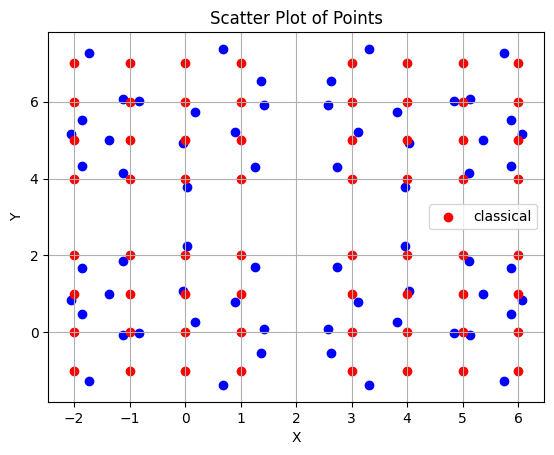

Error = [0.3877966230123825, 0.23839737243738435, 0.4303850071886822, 0.5943557019375789, 0.23569080013027047, 0.07875248716163509, 0.32361105369543386, 0.7828470502294045, 0.18849496144005506, 0.3720587126338974, 0.15306420278123728, 0.9905359909875792, 0.35307435558639233, 0.16835800425410133, 0.48732797510437337, 0.38113928498913846]
MSE =  0.3853680989730967
Color Error =  0.0


In [676]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

phis_tra = []
for i in range(len(P_tra)):
    phi = round(np.arctan2(P_tra[i][1], P_tra[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis_tra.append(phi)
    else:
        phi = round(phi/4,4)
        phis_tra.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

thetas_tra = []
for i in range(len(P_tra)):
    theta = round(np.arccos(P_tra[i][2])/2,4)
    thetas_tra.append(theta)

thetas_del = []
phis_del = []
for i in range(len(thetas)):
    theta_del = round(thetas_tra[i]-thetas[i],4)
    thetas_del.append(theta_del)
    phi_del = round(phis_tra[i]-phis[i],4)
    phis_del.append(phi_del)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  [g,y,y,g, r,b,b,r, r,b,b,r,  g,y,y,g] #BRYG
color_theta = [np.pi/4]*16

color_phi = [np.pi/6,np.pi/12,np.pi/12,np.pi/6,
             0,4*np.pi/12,4*np.pi/12, 0,
             0,4*np.pi/12,4*np.pi/12, 0,
             np.pi/6,np.pi/12,np.pi/12,np.pi/6]


# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
# reset

for i, (phi, theta) in enumerate(zip(phis_del, thetas_del)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)

            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
qc_image.x(p)
qc_image.x(O)
# reset

qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=205824)
result = job.result()
counts = result.get_counts()
'''
counts['1001000']=0
counts['1011000']=0
counts['1101000']=0
counts['1111000']=0
'''
pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:-2]
        angle_decision = int(key[-2])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)



phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]



theta_state_0_ionq = []
for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
#print(color_phi_result_list)


color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):


    #color_recon_ionq.append([round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1),round(pixel_color_phi_recon_ionq[i]* 180 / np.pi,-1),0])
    #print(f"{i} th pixel phi, theta angle",round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1), round(pixel_color_theta_recon_ionq[i] * 180 / np.pi,-1))

    if round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 60.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round(pixel_color_phi_recon_ionq[i] * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,k_recon,0]))
    
    elif 60.0 <round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 120.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-1.0472)  * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon-k_recon,n_recon,0]))

    elif 120.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 180.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-2*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon,k_recon]))

    elif 180.0< round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 240.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-3*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([0,n_recon-k_recon,n_recon]))

    elif 240.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 300.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-4*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([k_recon,0,n_recon]))

    elif 300.0 < round(pixel_color_phi_recon_ionq[i]* 180 / np.pi, -1) <= 360.0:
        n_recon = round(pixel_color_theta_recon_ionq[i]* 180 / np.pi, -1) * 510 / 180
        k_recon = round((pixel_color_phi_recon_ionq[i]-5*1.0472) * 180 / np.pi,-1) * 3 * n_recon / 180
        color_recon_ionq.append(np.array([n_recon,0,n_recon-k_recon]))
    

color_recon_ionq = list(reversed(color_recon_ionq))
print("Reconstructed color = ",color_recon_ionq)

# Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
print("Reconstructed pixel =",color_list_ionq)


back_2 = [y_axis_transition(point,3) for point in back_recon_pixel_ionq]
back_3 = [origin_transition(point,2,3) for point in back_recon_pixel_ionq]
back_4 = [x_axis_transition(point,2) for point in back_recon_pixel_ionq]

back_stereo_pixel = back_recon_pixel_ionq + back_2 + back_3 + back_4

x_stereo = [point[0] for point in back_stereo_pixel]
y_stereo = [point[1] for point in back_stereo_pixel]


end = time.time()
print(f"{end - start:.5f} sec")

x_Q_tra = [point[0] for point in Q_tra]
y_Q_tra = [point[1] for point in Q_tra]

x_values = [point[0] for point in back_recon_pixel_ionq]
y_values = [point[1] for point in back_recon_pixel_ionq]

origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)
Q_oritin_tra = Transition(Q_origin,2,3)

x_Q_origin = [point[0] for point in Q_oritin_tra]
y_Q_origin = [point[1] for point in Q_oritin_tra]

# 시각화
plt.scatter(x_stereo, y_stereo, color='blue')
plt.scatter(x_Q_origin, y_Q_origin, color='red', label = 'classical')
plt.title('Scatter Plot of Points')
plt.xlabel('X')
plt.ylabel('Y')
#plt.xlim(-5,5)
#plt.ylim(-5,5)
plt.legend()
plt.grid(True)
plt.show()

error_ionq = []
for i in range(len(Q)):
    del_x = x_Q_tra[i] - x_values[i]
    del_y = y_Q_tra[i] - y_values[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d
MSE = sum(error_ionq)/len(Q)

error_color = []
for i in range(len(Q)):
    del_color_r = image_resize[i][0] - color_recon_ionq[i][0]
    del_color_g = image_resize[i][1] - color_recon_ionq[i][1]
    del_color_b = image_resize[i][2] - color_recon_ionq[i][2]
    del_color = np.sqrt(del_color_r**2+del_color_g**2+del_color_b**2)
    error_color.append(del_color)
colorMSE = sum(error_color)/len(Q)
red_error.append(del_color_r)
green_error.append(del_color_g)
blue_error.append(del_color_b)

print("Error =",error_ionq)
print("=============================")
print("MSE = ",MSE)
print("Color Error = ", colorMSE)
print("==========================================================================")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


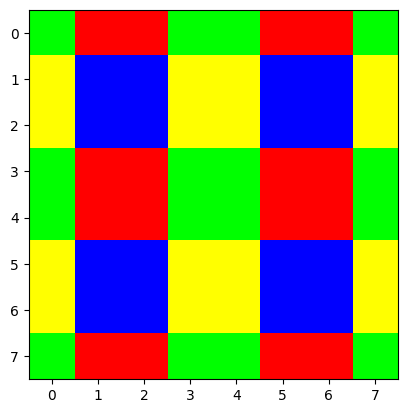

In [678]:
recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
recon_color_array_3 = np.rot90(recon_color_array,k=2)
recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))

color_row1 = np.concatenate((recon_color_array_2,recon_color_array_3), axis=1)
color_row2 = np.concatenate((recon_color_array,recon_color_array_4), axis=1)
final_color_array = np.concatenate((color_row1,color_row2),axis=0)
plt.imshow(final_color_array, cmap = 'gray')

C:\Users\HCI\AppData\Local\Temp\ipykernel_9684\4046372070.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o')


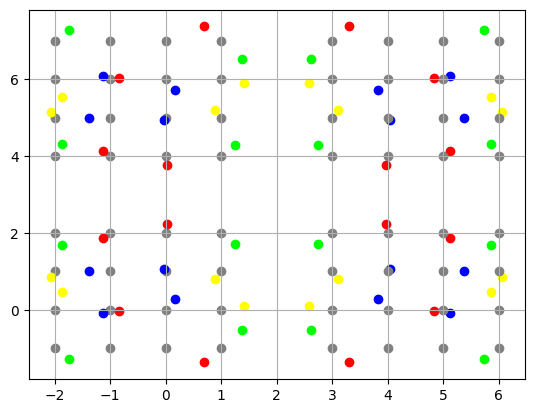

In [679]:
#recon_color_array = np.flipud(np.rot90(np.array(color_recon_ionq).reshape(4,4,3),k=3))
recon_color_array = np.array(color_recon_ionq).reshape(4,4,3)
color_recon_ionq_1 = recon_color_array.reshape(-1,3).tolist()

recon_color_array_2 = np.flipud(np.rot90(recon_color_array,k=2))
color_recon_ionq_2 = recon_color_array_2.reshape(-1,3).tolist()

recon_color_array_3 = np.rot90(recon_color_array,k=2)
color_recon_ionq_3 = recon_color_array_3.reshape(-1,3).tolist()

recon_color_array_4 = np.fliplr(np.rot90(recon_color_array,k=2))
color_recon_ionq_4 = recon_color_array_4.reshape(-1,3).tolist()

color_recon_point = color_recon_ionq_1 + color_recon_ionq_2 + color_recon_ionq_3 + color_recon_ionq_4
final_color = np.array(color_recon_point)

for i in range(len(back_stereo_pixel)):
    result_array = (final_color[i] / 255 > 0).astype(int)
    plt.scatter(back_stereo_pixel[i][0],back_stereo_pixel[i][1],c=result_array, marker='o')
    plt.scatter(Q_oritin_tra[i][0],Q_oritin_tra[i][1],c="gray")
    plt.grid(True)
plt.show()